# Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')

import seaborn as sns

params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [18, 6],
   }

plt.rcParams.update(params)

import pandas as pd
pd.options.display.max_rows = 500
pd.options.display.max_seq_items = 500

import numpy as np
from numpy import percentile
np.random.seed(42)

import copy
import math
import os
import sys
import json
from datetime import datetime
from collections import Counter
import time
import string
import glob
import calendar
from tqdm.notebook import tqdm

from tabulate import tabulate

from scipy import stats
from scipy.stats import skew, kurtosis

In [2]:
TITLE_SIZE = 24
TITLE_PADDING = 20

# EDA: San Fransisco Purchasing Commodity Data
---

## The data set
- The San Francisco Controller's Office maintains a **database of purchasing activity** from fiscal year 2007 onward. 
- **The data represents detailed commodity-level information by purchase order to contractors and vendors that provide goods and/or services to the City.** 
- The data includes payments made for tax and fee refunds, rebates, settlements, etc. too.
- The data is made available [here](https://data.sfgov.org/City-Management-and-Ethics/Purchasing-Commodity-Data/ebsh-uavg) as part of SF's OpenData Initiative.
- The **data set was created in March 2016** and **entails 3.5 million rows** (as of time of writing), each row being one purchase. 
- **New data is added daily and published on a weekly basis.**
- The data is available in Excel and CSV format as well as JSON through an [API endpoint](https://data.sfgov.org/resource/ebsh-uavg.json).
- A data description can be downloaded [here.](https://data.sfgov.org/api/views/ebsh-uavg/files/1dca9419-620b-4784-b462-42db98afadd5?download=true&filename=N:\All%20Departments\DataCoordination\Metadata%20Spring%20Cleaning\CON_DataDictionary_Purchasing-Commodity-Data.pdf)

**Important**
- The **fiscal year in the data is defined as the time frame from July to June**. E.g., the fiscal year of 2021 startes July 2020 and ends June 2021. 

## Import data

In [3]:
columns = [
    'Fiscal Year',
    'Purchase Order Date',
    'Purchase Order',
    'Purchase Order Line',
    'Purchasing Department',
    'Purchasing Department Title',
    'Commodity Code',
    'Commodity Title',
    'Supplier & Other Non-Supplier Payees',
    'Post Date - Original',
    'Post Date - Current',
    'Encumbered Quantity',
    'Encumbered Amount'
    ]

In [4]:
df = pd.read_csv("_data/Purchasing_Commodity_Data.csv", usecols=columns, low_memory=False)

In [5]:
df.columns = df.columns.str.lower().str.replace(" ", "_").str.replace("-", "").str.replace("&", "").str.replace("__", "_")

cols = ['fiscal_year', 'order_date', 'order',
       'order_line', 'purchasing_department',
       'dept_title', 'post_date_original',
       'post_date_current', 'commodity_code', 'commodity_title',
       'supplier_name', 'quantity', 'price']
df.columns = cols

df.fiscal_year = df.fiscal_year.astype("int16")
df.order_date = pd.to_datetime(df.order_date)
df.post_date_original = pd.to_datetime(df.post_date_original)
df.post_date_current = pd.to_datetime(df.post_date_current)
df.commodity_code = df.commodity_code.astype("str")

## First insights

- **3'488'941 samples** in dataset
- 1.6 GB memory consumption
- Categorical, continuous and time based features 
- Features are in sensible order
- **Many missing values**, mainly in dates and commodity titles

In [6]:
display(df.info(memory_usage="deep", verbose=True, show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3488941 entries, 0 to 3488940
Data columns (total 13 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   fiscal_year            3488941 non-null  int16         
 1   order_date             2046957 non-null  datetime64[ns]
 2   order                  3488941 non-null  object        
 3   order_line             3488914 non-null  float64       
 4   purchasing_department  3488940 non-null  object        
 5   dept_title             3488940 non-null  object        
 6   post_date_original     1438911 non-null  datetime64[ns]
 7   post_date_current      1438765 non-null  datetime64[ns]
 8   commodity_code         3488941 non-null  object        
 9   commodity_title        3422542 non-null  object        
 10  supplier_name          3488941 non-null  object        
 11  quantity               3488941 non-null  float64       
 12  price                  34889

None

- **A quick sum of all collected transactions in the data set reveals a total of almost 2 trillion USD.**
- **This does not seem plausible** given that the [city's total yearly budget for 2020-21 is «just» 13.6 billion](https://openbook.sfgov.org/webreports/details3.aspx?id=2925).

In [7]:
print(f"Absolute sum of all transactions:         {np.sum(np.abs(df.price)):,.0f} USD")
print(f"Sum of transactions with negative price:        {np.abs(df[df.price<0].price.sum()):,.0f} USD")

Absolute sum of all transactions:         1,996,726,684,348 USD
Sum of transactions with negative price:        281,232,381 USD


In [8]:
display(pd.concat([df.head(3), df.tail(3)]))

fiscal_year order_date         order  order_line  \
0               1999        NaT  POPT99009447         2.0   
1               1999        NaT  POPT99009447         3.0   
2               2002        NaT  POAR02000042         1.0   
3488938         2022 2021-07-19    000480867A         1.0   
3488939         2022 2021-07-30    000520936A         1.0   
3488940         2022 2021-07-30    000520936A         2.0   

        purchasing_department                             dept_title  \
0                        DPT2  PUB TRANSPORT - N/M GRANTS & PROJECTS   
1                        DPT2  PUB TRANSPORT - N/M GRANTS & PROJECTS   
2                         ART                         ART COMMISSION   
3488938                   DPH                      DPH Public Health   
3488939                   DPH                      DPH Public Health   
3488940                   DPH                      DPH Public Health   

        post_date_original post_date_current commodity_code  \
0               1999-04-01        1999-04-01         955815   
1               1999-04-01        1999-04-01         955815   
2               2002-01-25        2002-01-25         725010   
3488938                NaT               NaT          34580   
3488939                NaT               NaT          47050   
3488940                NaT               NaT          95847   

                                           commodity_title  \
0        LIGHT RAIL TRANSIT VEHICLE EQPT, PARTS, MATLS ...   
1        LIGHT RAIL TRANSIT VEHICLE EQPT, PARTS, MATLS ...   
2                                  SVC,CONSULTING;ART WORK   
3488938  Respiratory Protection Equipment and Parts (In...   
3488939                            Lifting Devices Patient   
3488940                        Freight Management Services   

                           supplier_name  quantity       price  
0        THALES TRANSPORT & SECURITY INC       0.0  2088625.00  
1        THALES TRANSPORT & SECURITY INC       0.0   208862.50  
2                             TERRY HOFF       0.0   235924.00  
3488938           MEDLINE INDUSTRIES INC      10.0     1916.91  
3488939                              CME      12.0     3734.40  
3488940                              CME       1.0       65.79

In [9]:
# Printing some random samples
display(df.sample(3, random_state=42).T)

861521   \
fiscal_year                                               2013   
order_date                                                 NaT   
order                                             DPWP13001821   
order_line                                                 3.0   
purchasing_department                                      CWP   
dept_title                                         CLEAN WATER   
post_date_original                         2013-03-18 00:00:00   
post_date_current                          2013-03-18 00:00:00   
commodity_code                                          945073   
commodity_title        HARDWARE;FASTENER,BOLT/NUT/SCREW/WASHER   
supplier_name                            HARRISON & BONINI INC   
quantity                                                   2.0   
price                                                    33.89   

                                                                 716189   \
fiscal_year                                                         2012   
order_date                                                           NaT   
order                                                       DPUW12002792   
order_line                                                           5.0   
purchasing_department                                                WTR   
dept_title                                                 SF WATER DEPT   
post_date_original                                   2011-12-21 00:00:00   
post_date_current                                    2012-02-23 00:00:00   
commodity_code                                                  99470806   
commodity_title        CHARGE,FUEL TAX;MOTOR VEHICLE LICENSE(GAS)/CAL...   
supplier_name                                         WESTERN STATES OIL   
quantity                                                             0.0   
price                                                             9000.0   

                                                                 3465868  
fiscal_year                                                         2022  
order_date                                           2021-09-05 00:00:00  
order                                                         0000556046  
order_line                                                           6.0  
purchasing_department                                                DPH  
dept_title                                             DPH Public Health  
post_date_original                                                   NaT  
post_date_current                                                    NaT  
commodity_code                                                     46502  
commodity_title        Anesthesia and Respiration Equipment Hospital:...  
supplier_name                                     MEDLINE INDUSTRIES INC  
quantity                                                             4.0  
price                                                               3.04

## Missing values

**We have many missing values in the data**, mainly in features `order_date`, `post_date_original`, `post_date_current`, `commodity_title`

In [10]:
print(f"The total count of missing values is {df.isna().sum().sum()}")
print()
display(df.isna().sum())

The total count of missing values is 5608618



fiscal_year                    0
order_date               1441984
order                          0
order_line                    27
purchasing_department          1
dept_title                     1
post_date_original       2050030
post_date_current        2050176
commodity_code                 0
commodity_title            66399
supplier_name                  0
quantity                       0
price                          0
dtype: int64

## Duplicates

- We **do not have exact duplicates** in our data.
- **Omitting fiscal year and order date I see 306 duplicates.**

In [11]:
print(f"There are {df.duplicated().sum()} exact duplicates in the data set.")
print(f'There are {df.drop(["fiscal_year", "order_date"], axis=1).duplicated().sum()} duplicates in the data set, omitting fiscal year and order date.')

There are 0 exact duplicates in the data set.
There are 306 duplicates in the data set, omitting fiscal year and order date.


## Examining the features

### Value counts
Printing value counts for each feature reveals:
- **Data is available from years 1999 to 2022.**
- **Full data is available from 2007 onward**, as mentioned in data description.
- Data for 2022 is available too. However, it is incomplete. The fiscal year of 2022 ends June 2022.
- There are **133 unique codes for departments** (168 titles), **~10k commodity codes/titles** and **~15.8k supplier names**.  
- **Commodity code is `Unspecified` for 66'399 samples.**
- **Many samples have a price and/or quantity of 0 or below**.

In [12]:
# cols = ["order"]

# for feature in df.drop(cols, axis=1):
#     print("-"*80)
#     print(feature, "|", df[feature].dtype, "|", df[feature].nunique())
#     print(df[feature].value_counts(dropna=False).sort_index())
#     print()

**What are these purchases with a price/quantity of 0 or below?**
- These transactions account for a total of 1.9 trillion USD which is 99.6% of the sum of all transactions. As such these samples are hugely relevant.
- The data description states: *«For some non-discrete purchases, like professional service contracts, the Encumbered Quantity is zero.»* However, 1.9 trillion USD is a unreasonably large sum of money.
- Most of the purchases with a negative price have a negative quantity. These seem to be reimbursements or other transactions that aren't purchases of goods. 

In [13]:
total_special_transactions = np.sum(np.abs(df[(df.price<=0) | (df.quantity<=0)].price))
total_all = np.sum(np.abs(df.price))
share_special = 100 / total_all * total_special_transactions             
print(f"Transactions with a price/quantity of 0 or below account for {total_special_transactions:,.0f} USD\nwhich is {share_special:.2f}% of the sum of all transactions.")
print()

print(f"{df[df.price==0].shape[0]:,.0f} purchases with a price of 0.")
print(f"{df[df.price<0].shape[0]:,.0f} purchases with a price below 0.                      {df[df.price<0].price.sum():,.0f} USD total sum")
print(f"  {df[df.quantity<0].shape[0]:,.0f} purchases with a quantity below 0.                    {df[df.quantity<0].price.sum():,.0f} USD total sum")
print(f"  {df[(df.price<=0) & (df.quantity<0)].shape[0]:,.0f} purchases with a quantity below 0 & negative price.   {df[df.quantity<0].price.sum():,.0f} USD total sum")
print()
print(f"{df[df.quantity==0].shape[0]:,.0f} purchases with an exact quantity of 0.        {df[df.quantity==0].price.sum():,.0f} USD total sum")
print()

Transactions with a price/quantity of 0 or below account for 1,988,100,289,834 USD
which is 99.57% of the sum of all transactions.

8,025 purchases with a price of 0.
6,320 purchases with a price below 0.                      -281,232,381 USD total sum
  943 purchases with a quantity below 0.                    -18,424,865 USD total sum
  917 purchases with a quantity below 0 & negative price.   -18,424,865 USD total sum

451,784 purchases with an exact quantity of 0.        1,987,569,170,247 USD total sum



**Printing the top 10 departments, goods and suppliers of these zero-quantity-orders we see that these are mostly related to public health goods and services.**

- **It's hard to make sense of these zero quantity orders and decide how we can best deal with these.**
- **Because these orders account for such a substantial share of the total budget I will keep these in the data for now.**
- I decide to remove orders with a price of 0 and below as well as orders with a negative quantity.

In [14]:
df[df.quantity==0].sort_values('price', ascending=False).head(10)

fiscal_year order_date       order  order_line purchasing_department  \
2008289         2019 2019-06-24  0000212808         1.0                   DPH   
2468041         2020 2020-05-08  0000327943         1.0                   DPH   
1586916         2018 2017-11-30  0000109360         1.0                   DPH   
2984142         2021 2020-09-23  0000445131         1.0                   DPH   
2010073         2019 2019-05-28  0000213364         1.0                   DPH   
3100325         2021 2020-10-22  0000473101         1.0                   DPH   
2978745         2021 2020-07-21  0000443442         1.0                   DPH   
3195538         2021 2021-01-14  0000493847         1.0                   DPH   
2507482         2020 2020-02-06  0000341219         1.0                   DPH   
1953909         2019 2019-06-19  0000197170         1.0                   DPH   

                dept_title post_date_original post_date_current  \
2008289  DPH Public Health                NaT               NaT   
2468041  DPH Public Health                NaT               NaT   
1586916  DPH Public Health                NaT               NaT   
2984142  DPH Public Health                NaT               NaT   
2010073  DPH Public Health                NaT               NaT   
3100325  DPH Public Health                NaT               NaT   
2978745  DPH Public Health                NaT               NaT   
3195538  DPH Public Health                NaT               NaT   
2507482  DPH Public Health                NaT               NaT   
1953909  DPH Public Health                NaT               NaT   

        commodity_code            commodity_title         supplier_name  \
2008289          26900  DRUGS AND PHARMACEUTICALS  MCKESSON CORPORATION   
2468041          26900  DRUGS AND PHARMACEUTICALS  MCKESSON CORPORATION   
1586916          26900  DRUGS AND PHARMACEUTICALS  MCKESSON CORPORATION   
2984142          26900  DRUGS AND PHARMACEUTICALS  MCKESSON CORPORATION   
2010073          26900  DRUGS AND PHARMACEUTICALS  MCKESSON CORPORATION   
3100325          26900  DRUGS AND PHARMACEUTICALS  MCKESSON CORPORATION   
2978745          26900  DRUGS AND PHARMACEUTICALS  MCKESSON CORPORATION   
3195538          26900  DRUGS AND PHARMACEUTICALS  MCKESSON CORPORATION   
2507482          26900  DRUGS AND PHARMACEUTICALS  MCKESSON CORPORATION   
1953909    Unspecified                        NaN  MCKESSON CORPORATION   

         quantity         price  
2008289       0.0  5.831777e+11  
2468041       0.0  4.175012e+11  
1586916       0.0  6.124300e+10  
2984142       0.0  4.552200e+10  
2010073       0.0  3.933146e+10  
3100325       0.0  3.483000e+10  
2978745       0.0  3.071485e+10  
3195538       0.0  2.997400e+10  
2507482       0.0  2.883985e+10  
1953909       0.0  2.662067e+10

In [15]:
display(df[df.quantity==0].groupby("dept_title").price.sum().sort_values(ascending=False)[:10])
print()
display(df[df.quantity==0].groupby("commodity_title").price.sum().sort_values(ascending=False)[:10])
print()
display(df[df.quantity==0].groupby("supplier_name").price.sum().sort_values(ascending=False)[:10])

dept_title
DPH Public Health                1.649454e+12
ADM GSA - City Administrator     5.619232e+10
MTA Municipal Transprtn Agncy    4.692406e+10
AIR Airport Commission           4.101984e+10
PUC Public Utilities Commsn      4.098397e+10
LIB Public Library               3.939860e+10
HSA Human Services Agency        2.327746e+10
HOM Homelessness Services        1.907665e+10
DPW GSA - Public Works           1.164687e+10
POL Police                       6.650670e+09
Name: price, dtype: float64

commodity_title
DRUGS AND PHARMACEUTICALS                                      1.416774e+12
Health Care Services (Not Otherwise Classified)                5.314600e+10
HOSPITAL AND SURGICAL EQUIPMENT INSTRUMENTS AND SUPPLIES       4.786919e+10
CONSTRUCTION SERVICES GENERAL (INCL. MAINTENANCE AND REPAIR    4.664536e+10
PUBLICATIONS  AUDIOVISUAL MATERIALS BOOKS TEXTBOOKS  (PRE      3.766916e+10
HUMAN SERVICES                                                 3.740862e+10
HEALTH RELATED SERVICES (FOR HUMAN SERVICES SEE CLASS 952)     2.173834e+10
MISCELLANEOUS SERVICES NO. 1 (NOT OTHERWISE CLASSIFIED)        1.832620e+10
Automobile Truck and Bus Parts and Equipment                   1.584824e+10
FOODS: STAPLE GROCERY AND GROCER'S MISCELLANEOUS ITEMS         1.214835e+10
Name: price, dtype: float64

supplier_name
MCKESSON CORPORATION                       1.516682e+12
REGENTS OF THE UNIVERSITY OF CALIFORNIA    4.416632e+10
CITY AUTO SUPPLY                           1.916233e+10
US FOODS INC                               1.883584e+10
GOLDEN GATE PETROLEUM                      1.766447e+10
OFFICE DEPOT                               1.165341e+10
DEPUY SYNTHES SPINE                        1.143205e+10
BAKER & TAYLOR LLC                         1.121163e+10
MIDWEST TAPE LLC                           1.104221e+10
HENSEL PHELPS CONSTRUCTION CO              1.035491e+10
Name: price, dtype: float64

In [16]:
# Remove samples with price of 0 or below and
# Remove samples with quantity below zero (keeping all transactions with an exact quantity of 0) 
to_drop = df[(df.price<=0) | (df.quantity<0)].index
df.drop(to_drop, inplace=True)
df.reset_index(drop=True, inplace=True)

### Fiscal year
- Data before 2007 is negligible.
- **Orders do quadruple after 2017 by count.**
- **Less orders were made in 2021 than in 2018 to 2020**.

**We notice a first indication that data collection has changed from 2017 to 2018.**

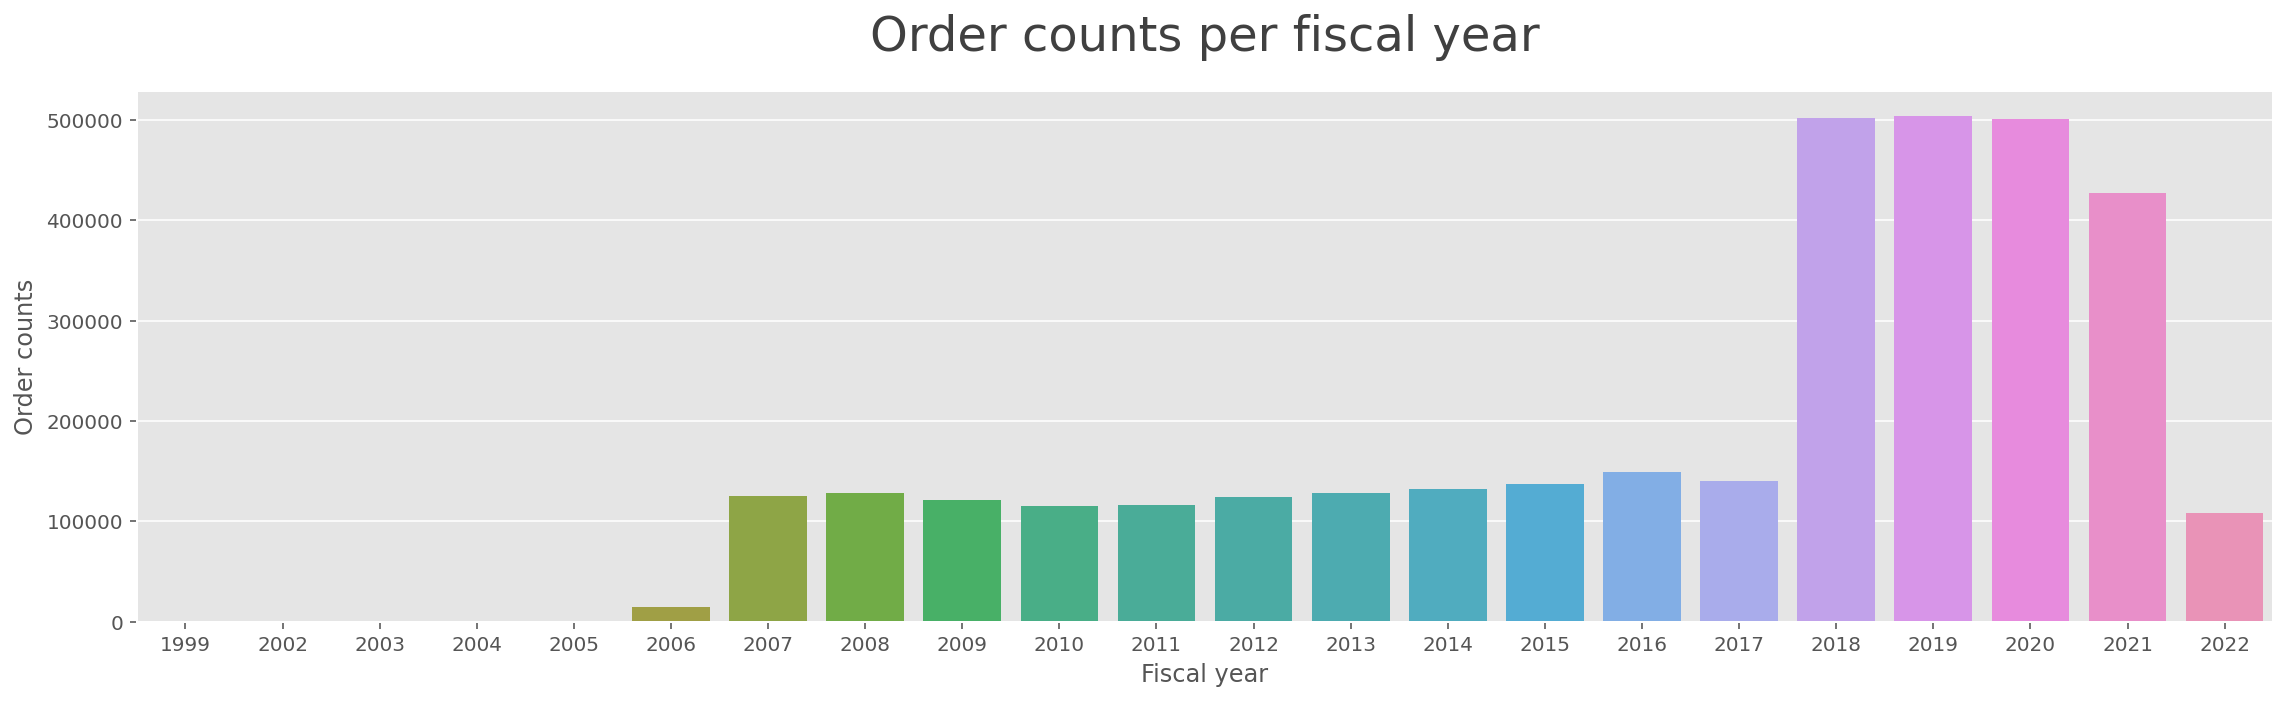

In [17]:
tmp = df.fiscal_year.value_counts().sort_index()
tmp = pd.DataFrame(tmp).reset_index()
tmp.columns = ["fiscal_year", "counts"]
plt.figure(figsize=(16,5))
sns.barplot(data=tmp, x="fiscal_year", y="counts")
plt.title("Order counts per fiscal year", size=TITLE_SIZE, pad=TITLE_PADDING)
plt.xlabel("Fiscal year")
plt.ylabel("Order counts")
plt.tight_layout()
plt.show()

Plotting the purchase volume in USD (rather than order counts) we see even more clearly the change of data collection:
- **The collected purchase data 2018 and onward is magnitudes higher.**
- **Purchase data before 2018 only accounts for ~1% of the total purchase volume** in the data set. 

In terms of the big picture these earlier years therefore likely can be ignored.

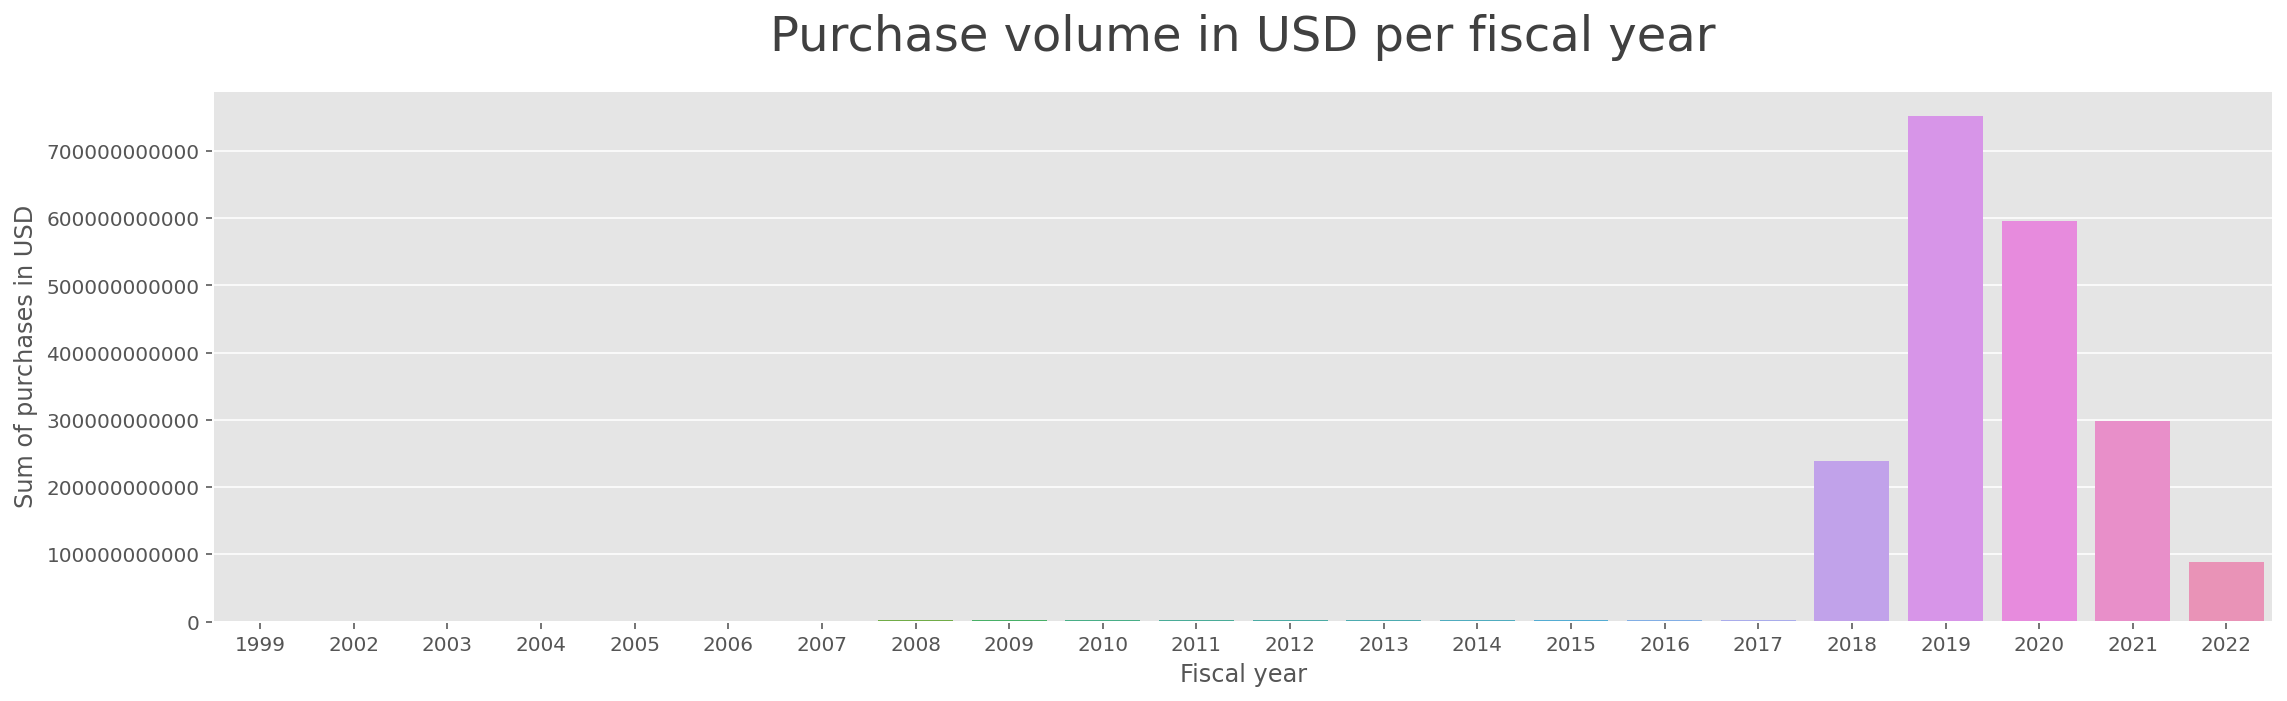

In [18]:
tmp = df.groupby("fiscal_year").price.sum().sort_index()
tmp = pd.DataFrame(tmp).reset_index()
tmp.columns = ["fiscal_year", "price"]
plt.figure(figsize=(16,5))
sns.barplot(data=tmp, x="fiscal_year", y="price")
plt.title("Purchase volume in USD per fiscal year", size=TITLE_SIZE, pad=TITLE_PADDING)
plt.ticklabel_format(axis="y", style="plain")
# plt.yscale("log")
plt.xlabel("Fiscal year")
plt.ylabel("Sum of purchases in USD")
plt.tight_layout()
plt.show()

In [19]:
before_2018 = tmp[tmp.fiscal_year <= 2017].price.sum()
after_2017 = tmp[tmp.fiscal_year > 2017].price.sum()
share_before = 100 / (before_2018 + after_2017) * before_2018
print(f"Data before fiscal year 2018 accounts for just {share_before:.2f}% of total purchase volume in the whole data set.")

Data before fiscal year 2018 accounts for just 1.17% of total purchase volume in the whole data set.


### Dates
- Over 2.2 million orders were updated later on. 
- The median time difference between first posting and updates is 105 days. 
- The maximum time difference between posting and update is 4'194 days.
- Missing data for order dates is found mostly in years 2007 to 2017
- Missing data for post dates is found mostly 2018 and later


**The system of data collection definitely has changed from 2017 to 2018.** 
- This **not only in terms of registered volume but rather in terms of methodology too.**
- Until 2018 post dates were collected. After that order dates are being used.

2,209,267 orders that have a different current date than post date.

           time_diff
count  167297.000000
mean      195.681124
std       276.556339
min       -32.000000
25%        23.000000
50%       105.000000
75%       286.000000
max      4194.000000


time_diff
-32.0           1
 1.0         5564
 2.0         3149
 3.0         2688
 4.0         3247
             ... 
 3014.0        11
 3072.0        34
 3100.0        15
 3343.0         5
 4194.0         7
Length: 1384, dtype: int64

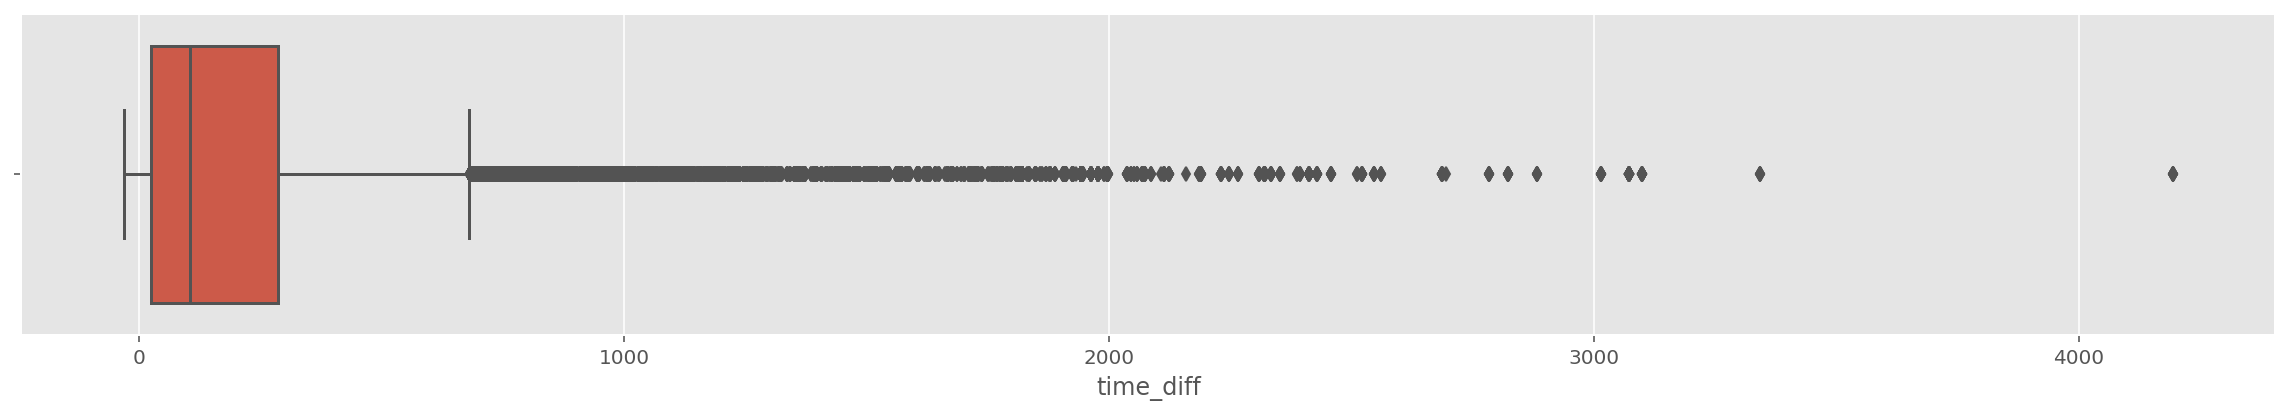

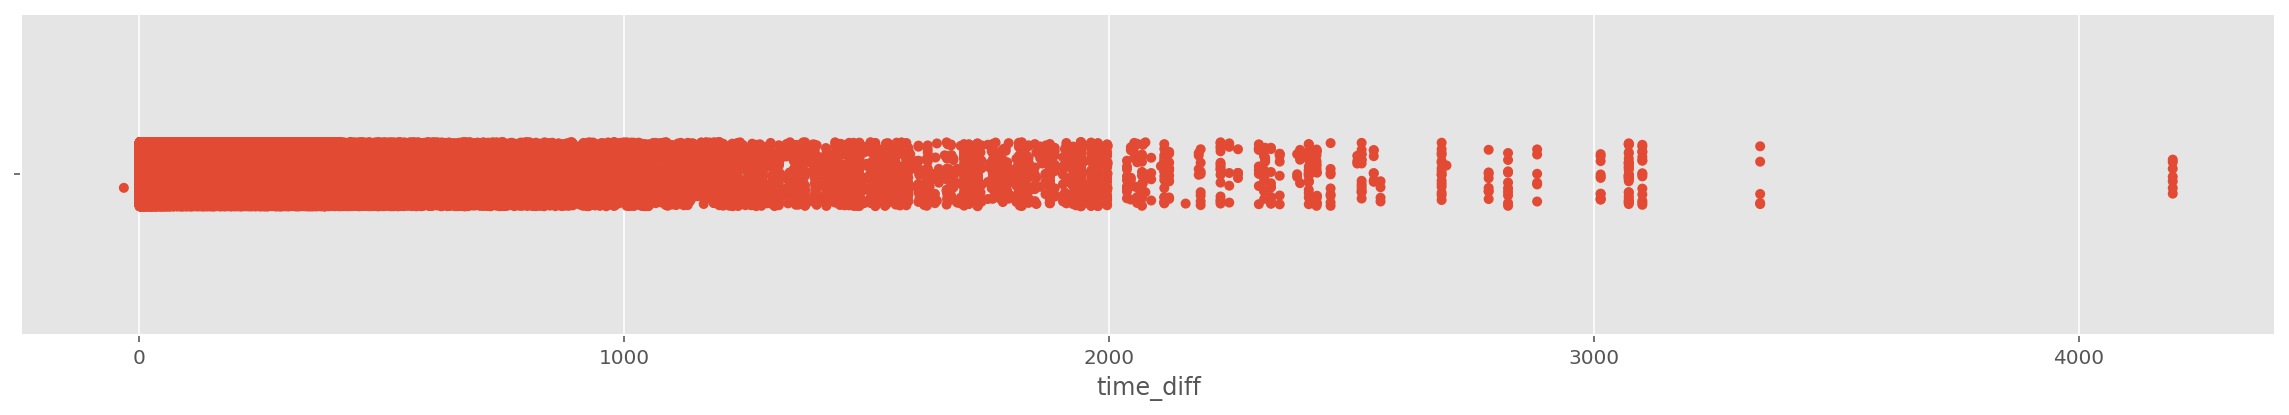

In [20]:
tmp = df.post_date_current - df.post_date_original
tmp = tmp.dt.days
df["time_diff"] = tmp.values

tmp = pd.DataFrame(tmp, columns=["time_diff"])
to_drop = tmp[tmp.time_diff==0].index
tmp.drop(to_drop, inplace=True)
print(f"{len(tmp):,.0f} orders that have a different current date than post date.\n")
print(tmp.describe())
display(tmp.value_counts().sort_index())

plt.figure(figsize=(16,3))
sns.boxplot(data=tmp, x="time_diff")
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,3))
sns.stripplot(data=tmp, x="time_diff")
plt.tight_layout()
plt.show()

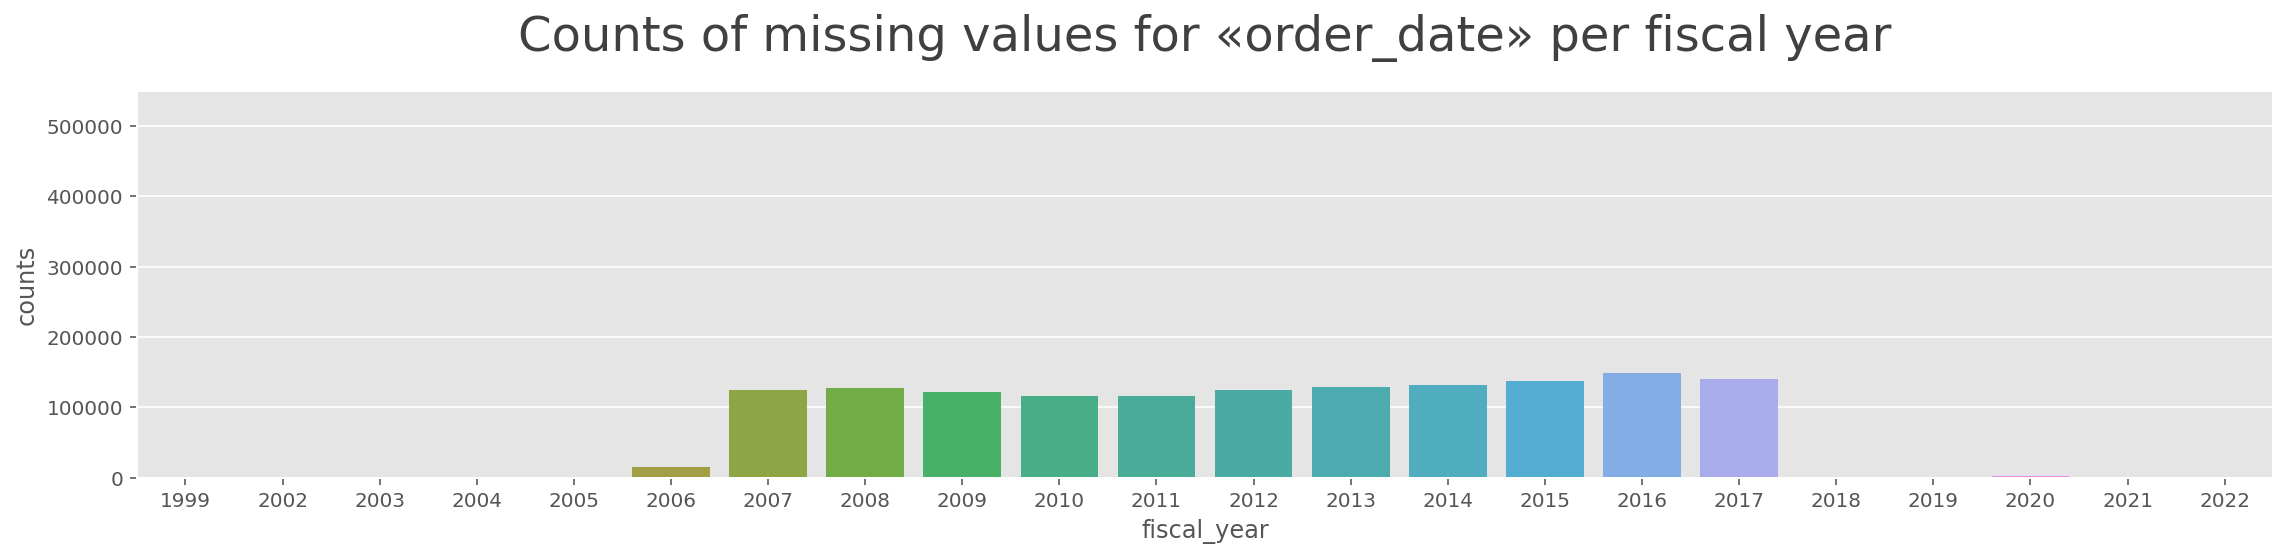

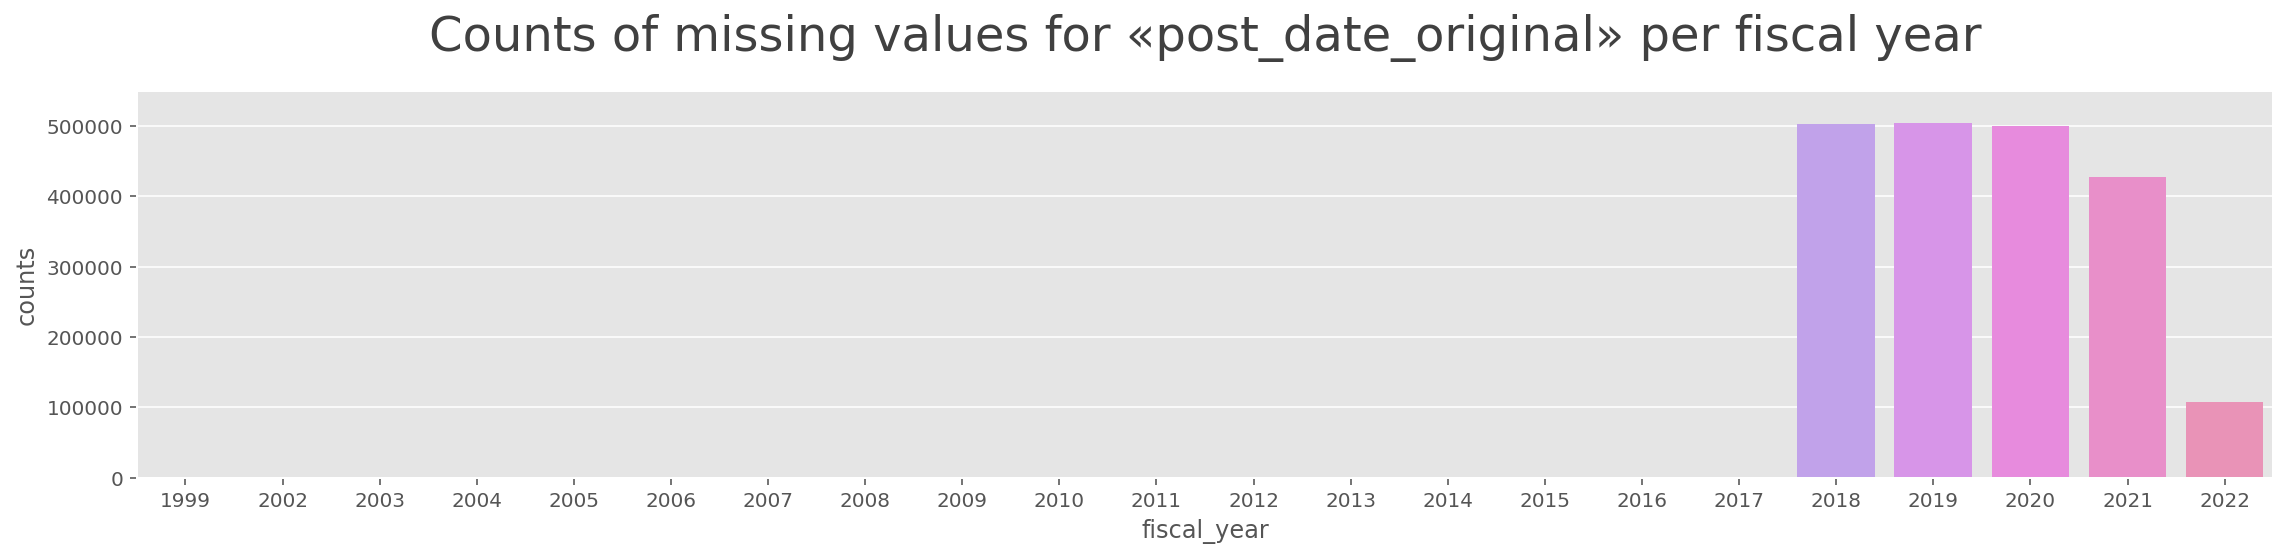

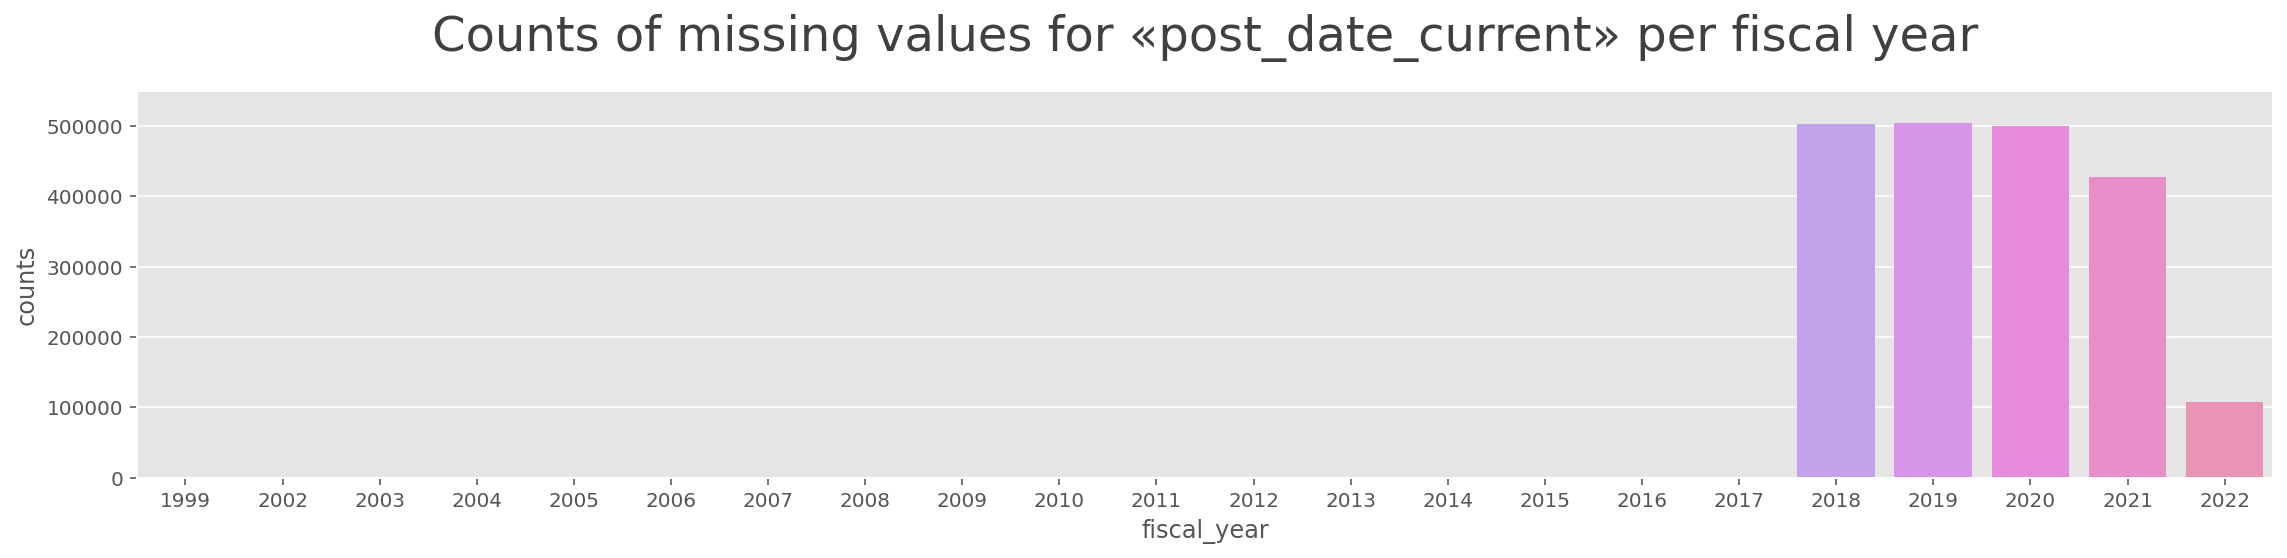

In [21]:
cols = ["order_date", "post_date_original", "post_date_current"]

for col in cols:
    tmp = df[df[col].isna()].fiscal_year.value_counts().sort_index()
    tmp = pd.DataFrame(tmp)
    tmp.columns = ["counts"]
    
    df_empty = pd.DataFrame(df.fiscal_year.unique(), columns=["fiscal_year"])
    df_empty["counts"] = np.nan
    df_empty.set_index("fiscal_year", inplace=True)
    df_empty.update(tmp, errors="raise")
    df_empty.reset_index(inplace=True)

    plt.figure(figsize=(16,4))
    sns.barplot(data=df_empty, x="fiscal_year", y="counts")
    plt.ylim(0, 550_000)
    plt.title(f"Counts of missing values for «{col}» per fiscal year", size=TITLE_SIZE, pad=TITLE_PADDING)
    plt.tight_layout()
    plt.show()

In [22]:
date_original = len(df[(df.order_date.isna()) & (df.post_date_original.notna())])
date_current = len(df[(df.order_date.isna()) & (df.post_date_current.notna())])
print(f"{date_original:,.0f} original post dates available where order dates are missing.")
print(f"{date_current:,.0f} current post dates available where order dates are missing.")
print()

order_date_original = len(df[(df.order_date.notna()) & (df.post_date_original.isna())])
order_date_current = len(df[(df.order_date.notna()) & (df.post_date_current.isna())])

print(f"{order_date_original:,.0f} order dates available where original post dates are missing.")
print(f"{order_date_current:,.0f} order dates available where current post dates are missing.")

1,432,744 original post dates available where order dates are missing.
1,432,600 current post dates available where order dates are missing.

2,038,793 order dates available where original post dates are missing.
2,038,793 order dates available where current post dates are missing.


### Intermediate cleaning step
To make further exploration easier and more meaningful I decide to:
- fill missing values for `order_date` with `post_date_current`
- remove columns for post dates
- remove data before 2007 and after 2021

In [23]:
# Fill missing order dates with post dates
to_fix = df[df.order_date.isna()].index
df.loc[to_fix, "order_date"] = df.loc[to_fix, "post_date_current"]

# Drop remaining samples with missing order dates
missing_order_dates = len(df[df.order_date.isna()])
print(f"{missing_order_dates:,.0f} samples that still have missing order dates. Removing these samples...")
to_drop = df[df.order_date.isna()].index
df.drop(to_drop, inplace=True)

# Create subset starting 2007 until most recent purchase
df_full = df[df.fiscal_year >= 2007].copy()

# Remove all data before fiscal year 2018 and after 2021
df = df[(df.fiscal_year >= 2007) & (df.fiscal_year <= 2021)].copy()
df.reset_index(drop=True, inplace=True)
df.drop(["post_date_original", "post_date_current"], axis=1, inplace=True)

# Drop time_diff feature
df.drop("time_diff", axis=1, inplace=True)

df.reset_index(drop=True, inplace=True)

3,177 samples that still have missing order dates. Removing these samples...


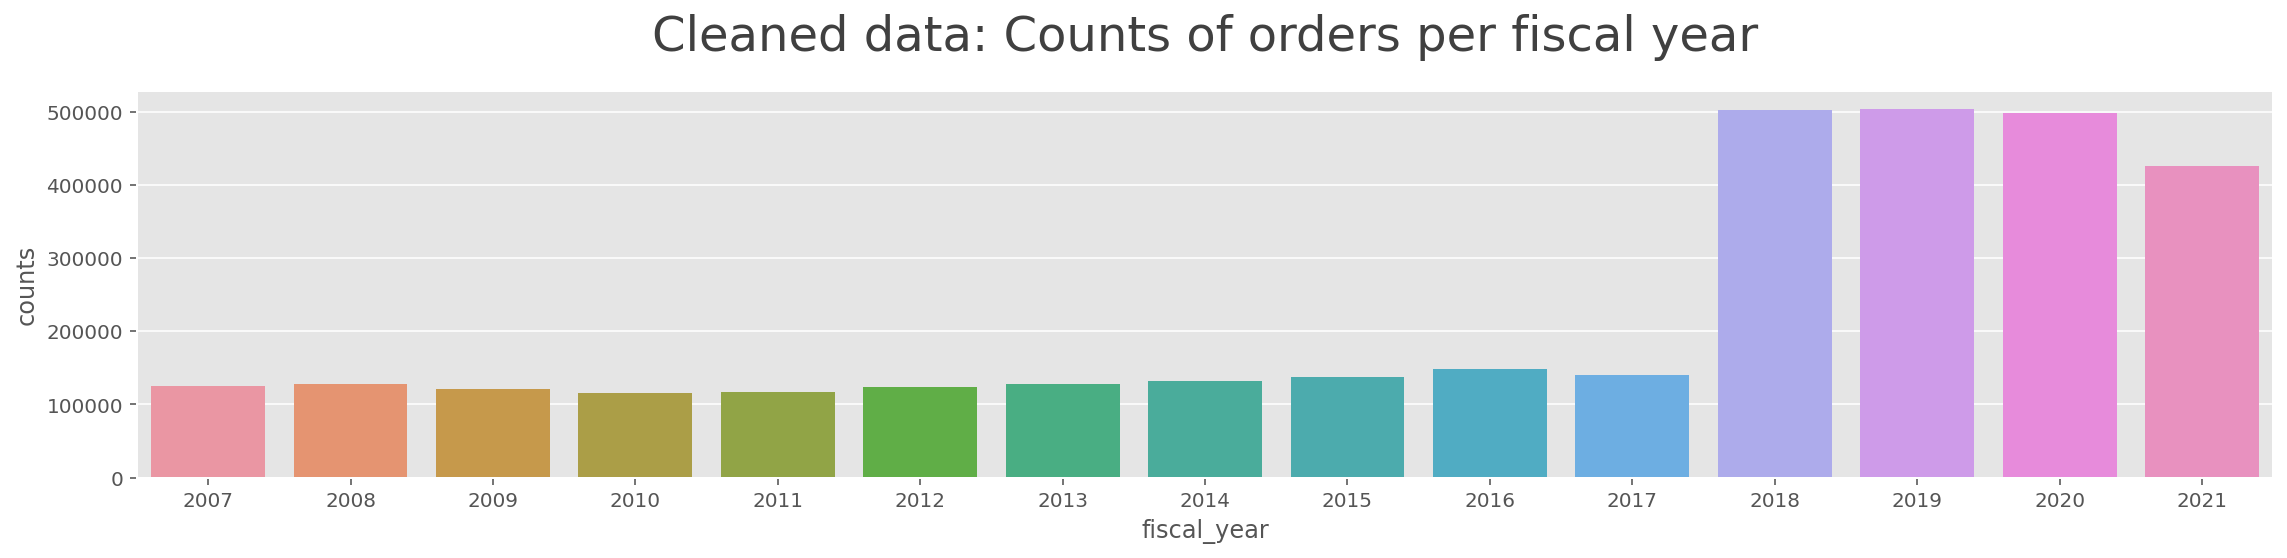

In [24]:
tmp = df.fiscal_year.value_counts().sort_index()

tmp = pd.DataFrame(tmp).reset_index()
tmp.columns = ["fiscal_year", "counts"]
    
plt.figure(figsize=(16,4))
sns.barplot(data=tmp, x="fiscal_year", y="counts")
plt.title(f"Cleaned data: Counts of orders per fiscal year", size=TITLE_SIZE, pad=TITLE_PADDING)
plt.tight_layout()
plt.show()

In [25]:
df.info(show_counts=True, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3347834 entries, 0 to 3347833
Data columns (total 11 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   fiscal_year            3347834 non-null  int16         
 1   order_date             3347834 non-null  datetime64[ns]
 2   order                  3347834 non-null  object        
 3   order_line             3347807 non-null  float64       
 4   purchasing_department  3347834 non-null  object        
 5   dept_title             3347834 non-null  object        
 6   commodity_code         3347834 non-null  object        
 7   commodity_title        3282194 non-null  object        
 8   supplier_name          3347834 non-null  object        
 9   quantity               3347834 non-null  float64       
 10  price                  3347834 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int16(1), object(6)
memory usage: 1.5 GB


### Exploration of purchases over time
Plotting all purchase prices along the time line I notice the following:
- Again – **the substantial change in data at the start of fiscal year 2018.** Much more data is collected. The purchases have a much wider price range. The structure seems different too.
- **There are clear vertical lines visible at the end/start of the fiscal years.** More purchases have been made around end of June and beginning of July.
- **There are clear horizontal lines visible too. These are fiscal limits for which regulations are in place.** E.g. below 10k USD only one offer of a vendor is necessary. Before 2018 most of the purchases have been made below this line.

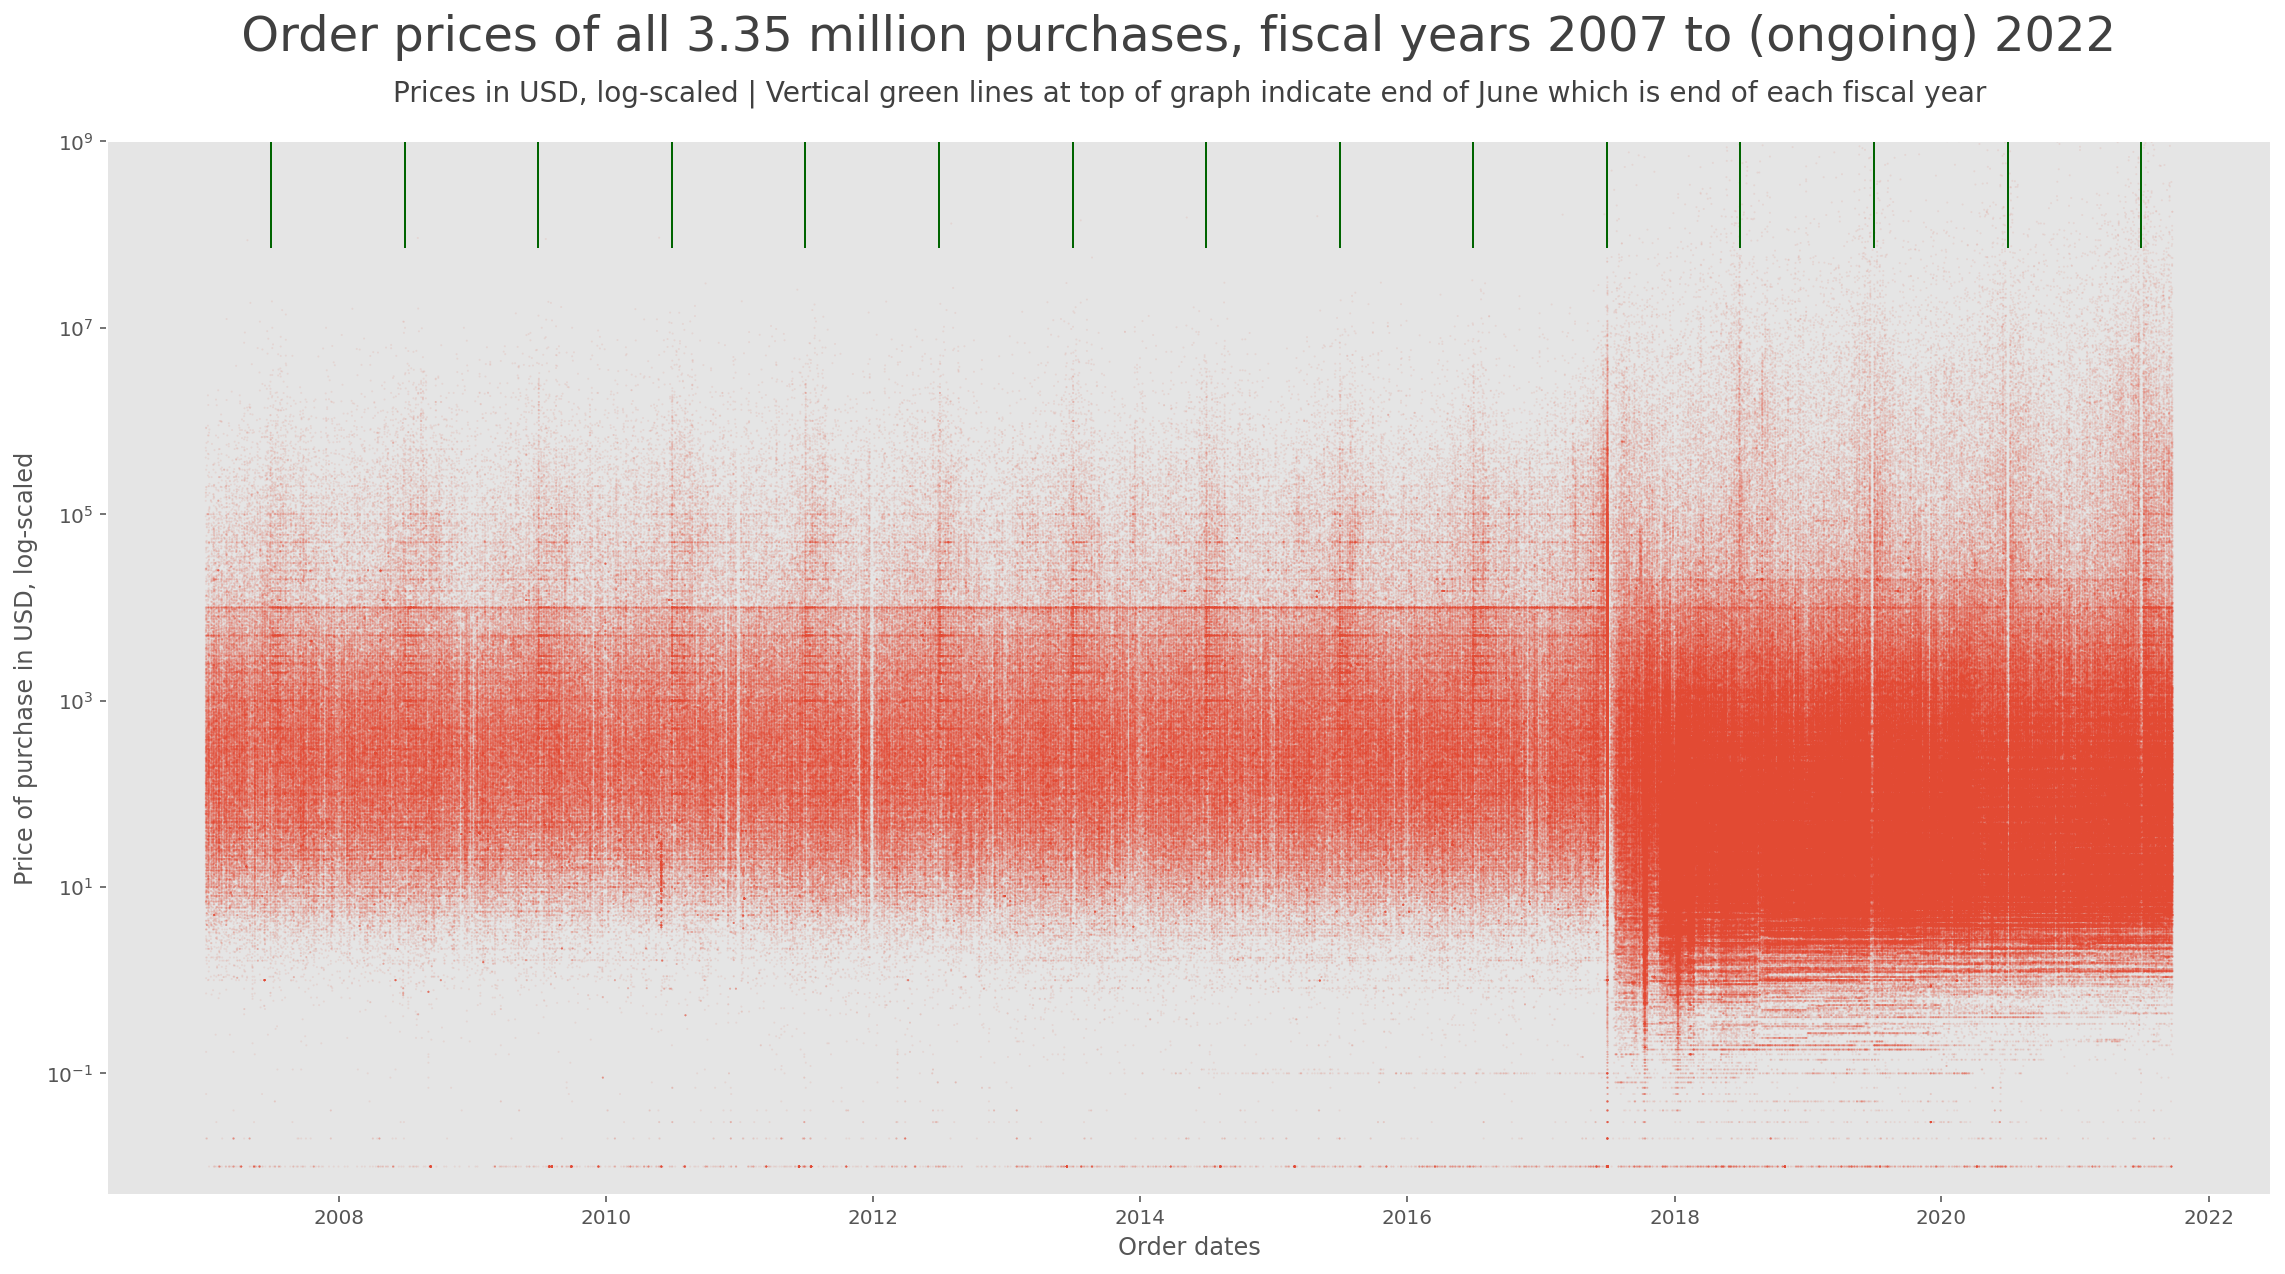

In [26]:
plt.figure(figsize=(16, 9))
ax = sns.scatterplot(data=df_full[df_full.order_date.dt.year >=2007], x="order_date", y="price", 
                alpha=.1, 
                s=1, 
                edgecolor='none'
               )
plt.yscale("log")
plt.ylim(0.005, 1_000_000_000)

for year in range(2007, 2022):
    plt.axvline(pd.to_datetime(f"{year}-06-30"), 0.9, color="darkgreen", linewidth=1)

plt.suptitle(f"     Order prices of all {df.shape[0]/1_000_000:.2f} million purchases, fiscal years 2007 to (ongoing) 2022", size=24)
plt.title("Prices in USD, log-scaled | Vertical green lines at top of graph indicate end of June which is end of each fiscal year", size=14, pad=20)
plt.xlabel("Order dates")
plt.ylabel("Price of purchase in USD, log-scaled")
plt.grid(visible=None)
plt.tight_layout()
plt.show()

By plotting sales volume in relation to months, weeks and weekdays I **observe more time related purchase patterns:**
- **There are distinct peaks of purchase volume in week 19 and 26.**
- **The high spending in June might be, because departments want to use their remaining budget before the end of the fiscal year** (end of June).
- **Most money was spent on Mondays and somewhat lesser on Fridays.**
- **These time related patterns can possibly be problematic** and **detrimental to the efficient use of the City's budget**. If these patterns actually are predictable a vendor might exploit these by asking higher prices than usual because he/she knows that the City likely wants to close an order.**

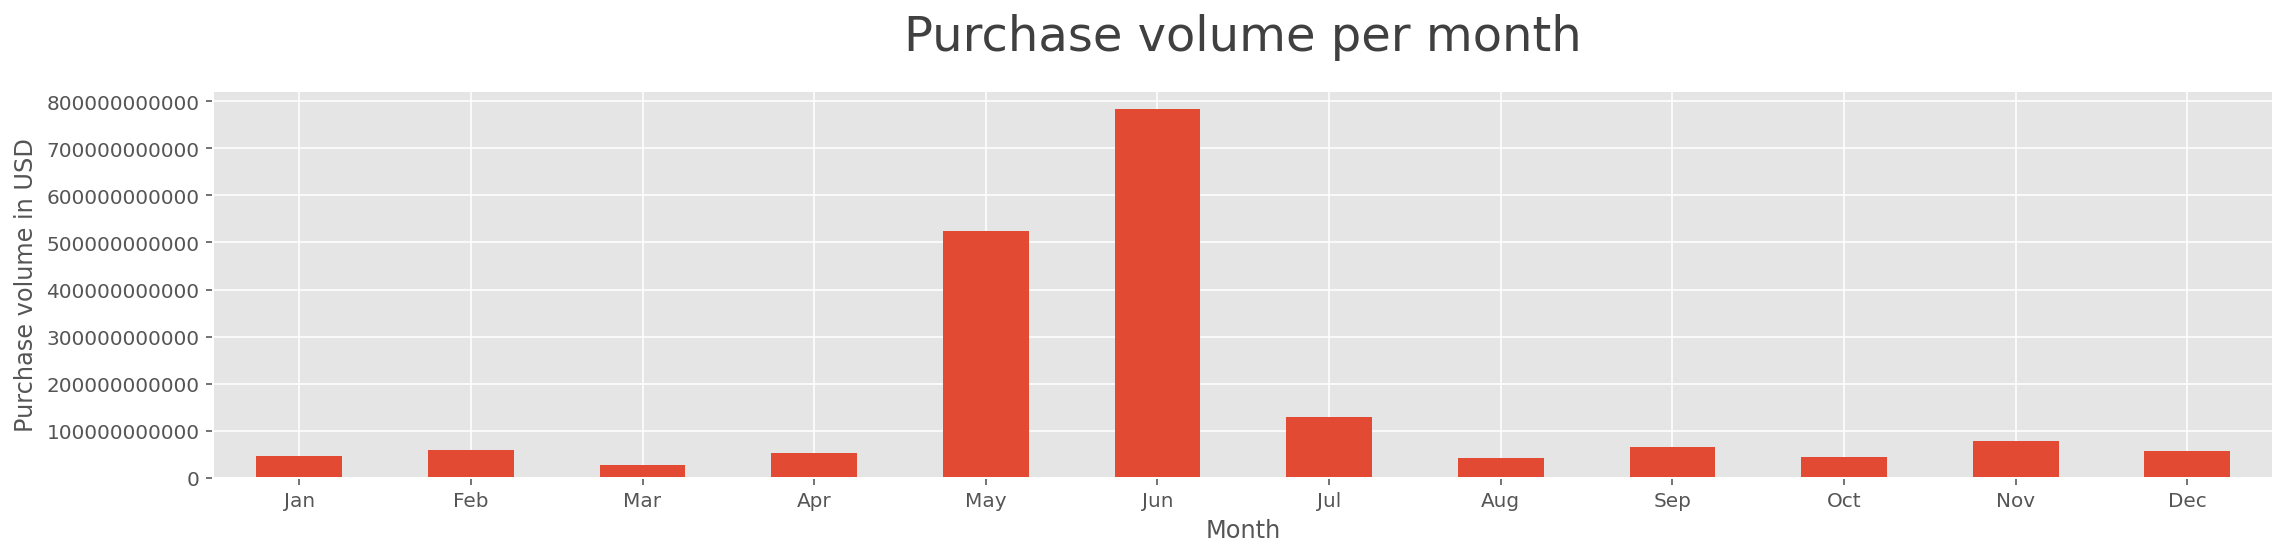

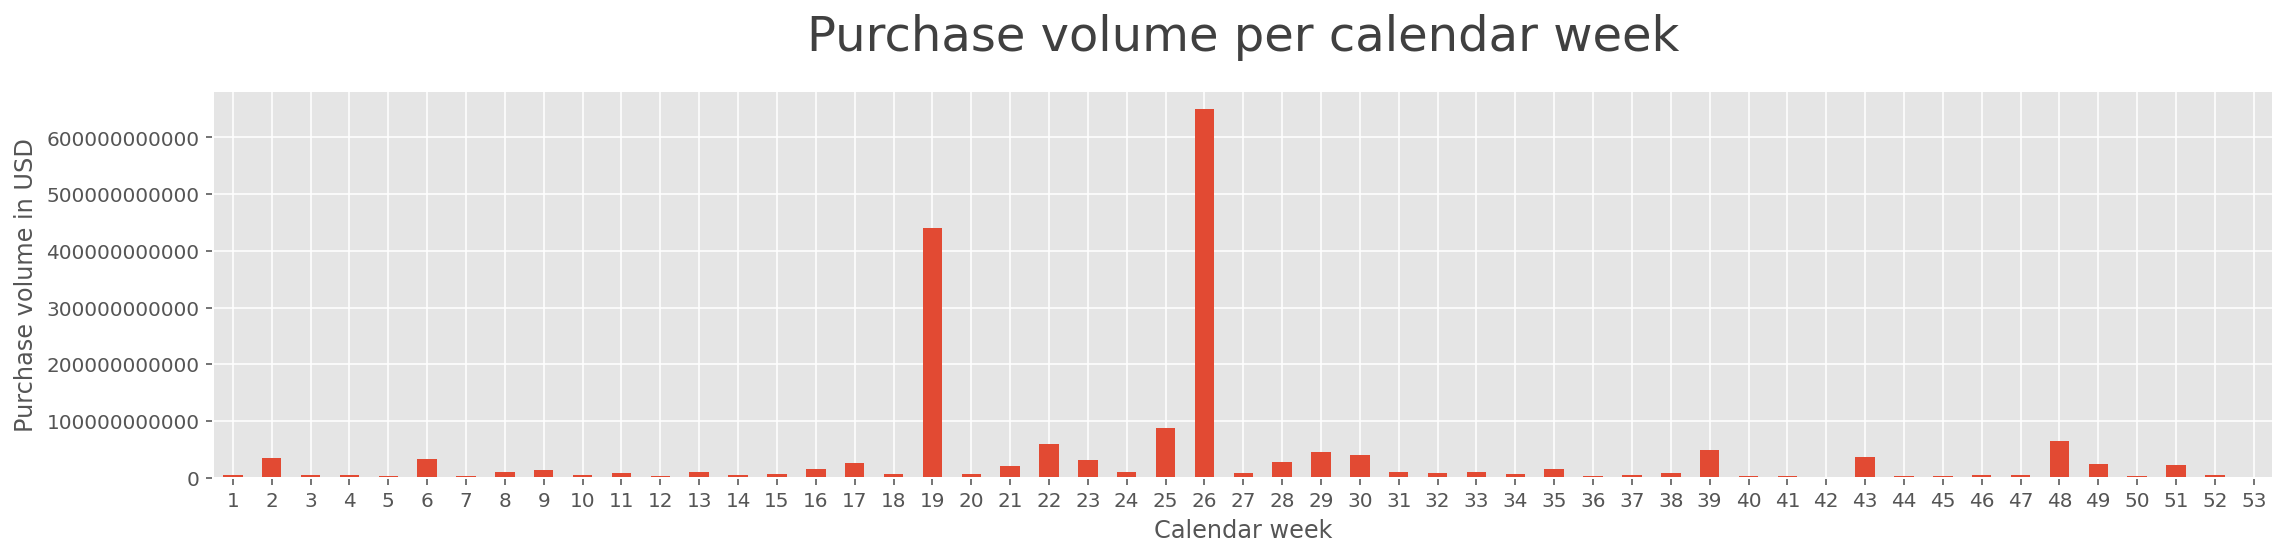

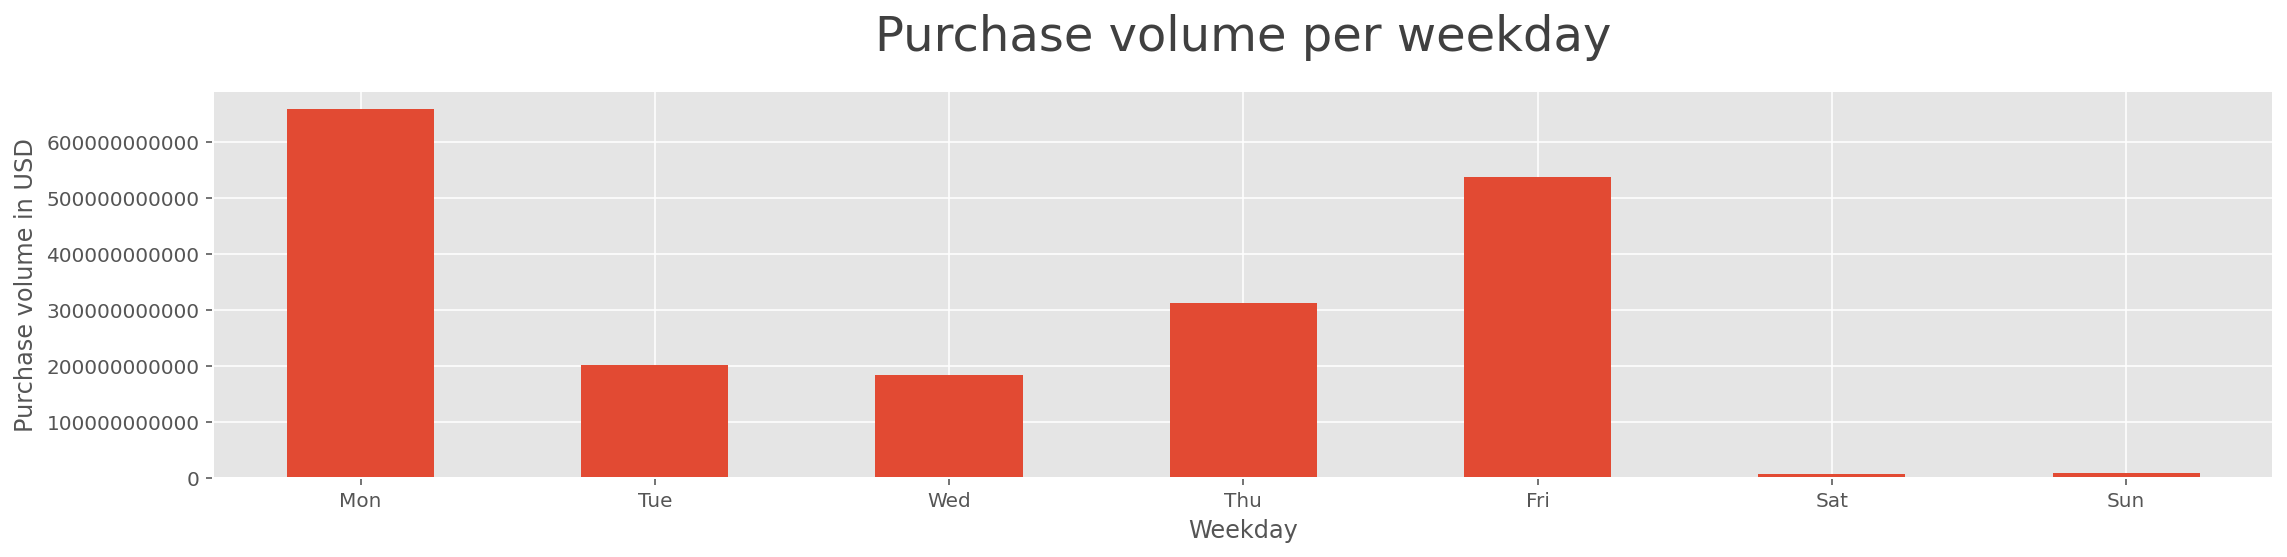

In [27]:
plt.figure(figsize=(16,4))
df.groupby(df.order_date.dt.month).price.sum().plot.bar()
plt.title(f"Purchase volume per month", size=TITLE_SIZE, pad=TITLE_PADDING)
plt.xticks(ticks=range(0, 12), labels=list(calendar.month_abbr[1:]), rotation=0)
plt.ticklabel_format(axis="y", style="plain")
plt.ylabel("Purchase volume in USD")
plt.xlabel("Month")
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,4))
df.groupby(df.order_date.dt.isocalendar().week).price.sum().plot.bar()
plt.title(f"Purchase volume per calendar week", size=TITLE_SIZE, pad=TITLE_PADDING)
plt.ticklabel_format(axis="y", style="plain")
plt.xticks(rotation=0)
plt.ylabel("Purchase volume in USD")
plt.xlabel("Calendar week")
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,4))
df.groupby(df.order_date.dt.weekday).price.sum().plot.bar()
plt.title(f"Purchase volume per weekday", size=TITLE_SIZE, pad=TITLE_PADDING)
plt.ticklabel_format(axis="y", style="plain")
plt.xticks(ticks=range(0, 7), labels=list(calendar.day_abbr), rotation=0)
plt.ylabel("Purchase volume in USD")
plt.xlabel("Weekday")
plt.tight_layout()
plt.show()

**Does this observation for time related patterns hold true if we split the data year by year? No, in general it does not.** 
- Patterns are still present, but shift from year to year.
- From 2007 until the system change in 2018 we see most money spent in the third quarter / first half of the fiscal year (which is the second half of the calendar year).
- 2018 and onward patterns change to very distinct peaks in single weeks.
- There neither is a clear pattern for weekdays though shifting days stick out over the years.

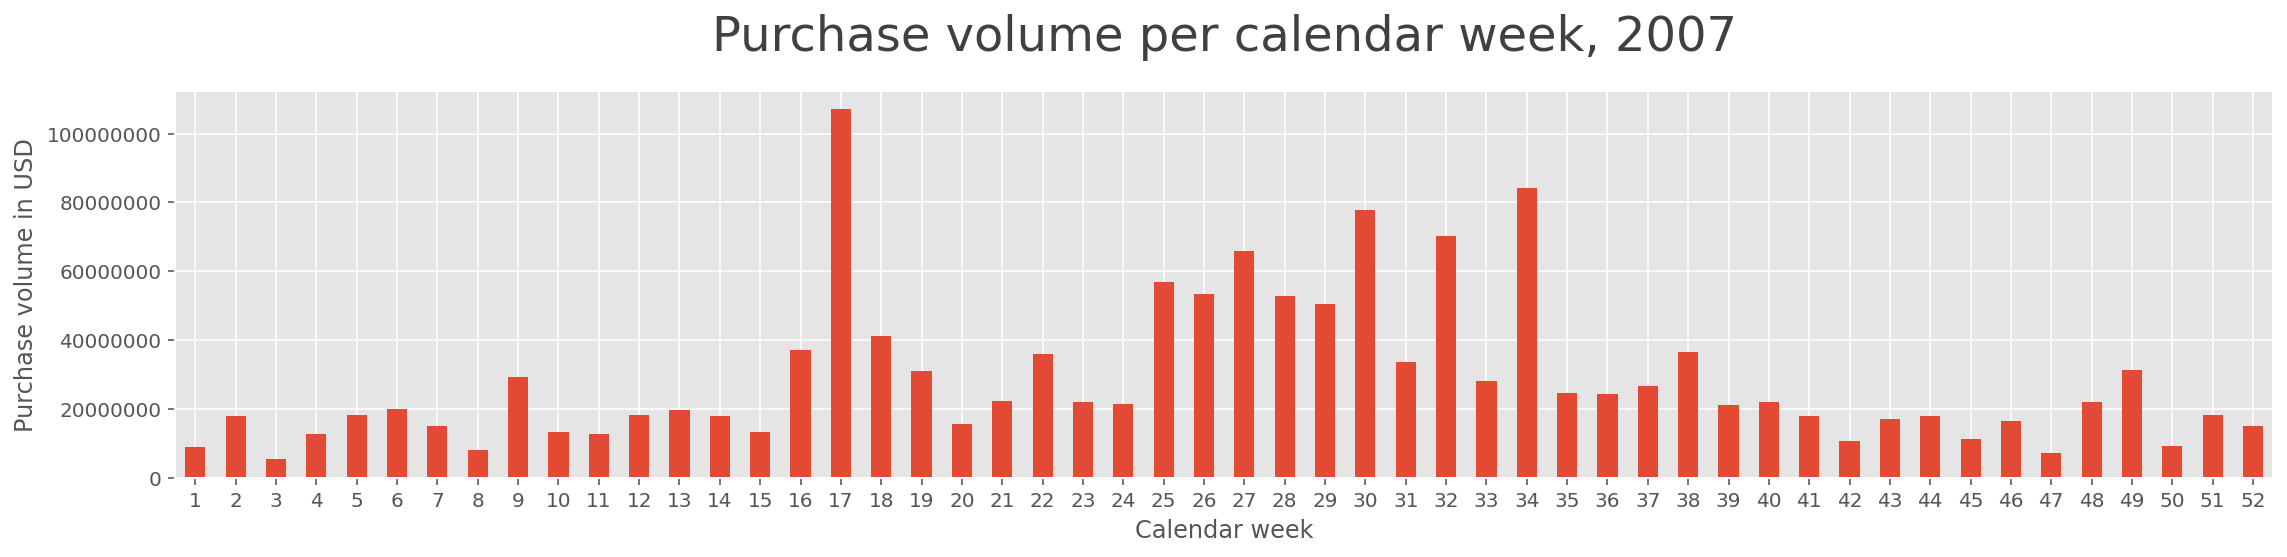

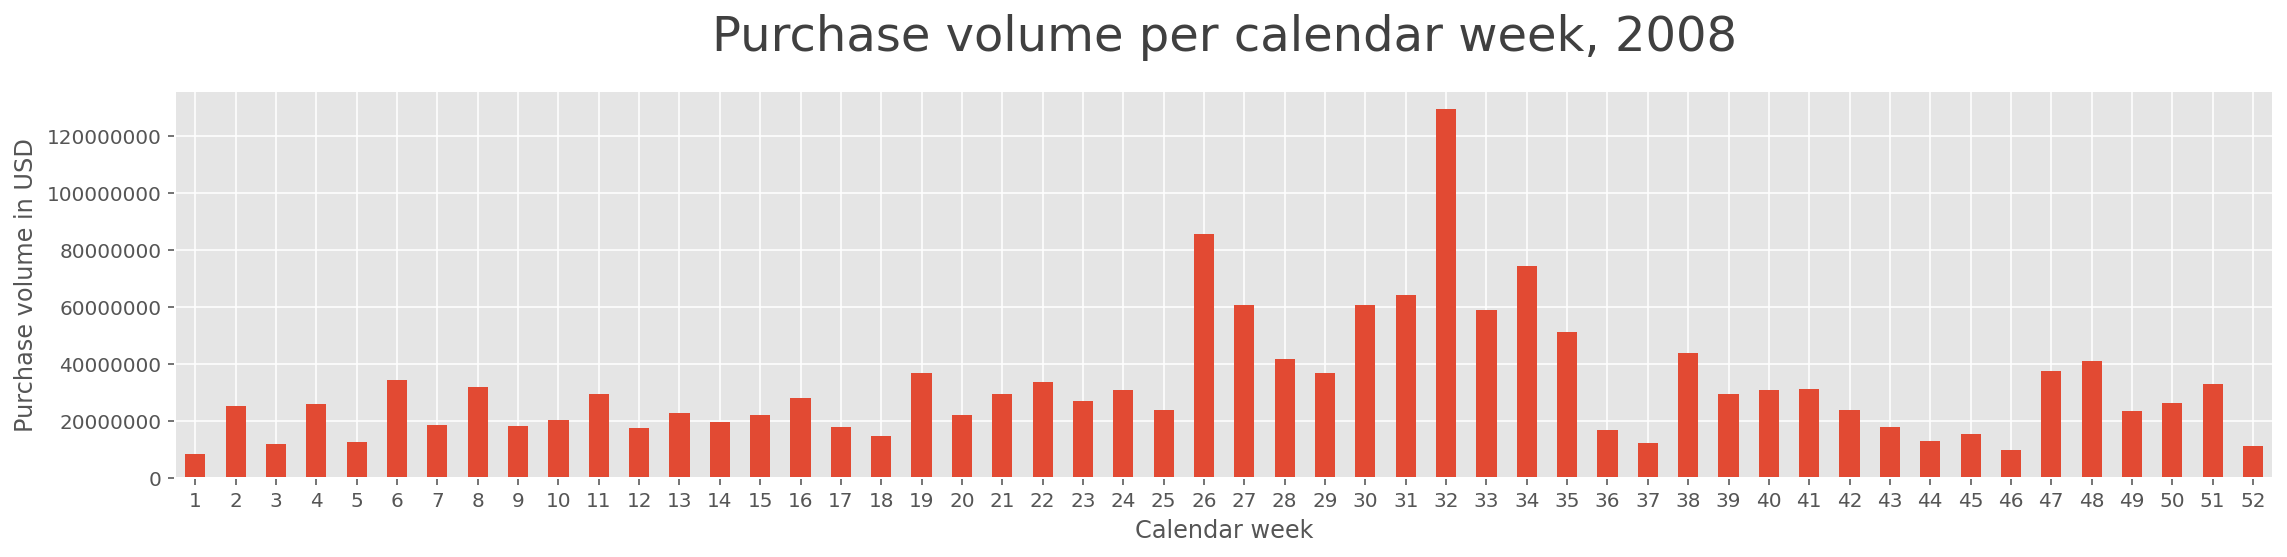

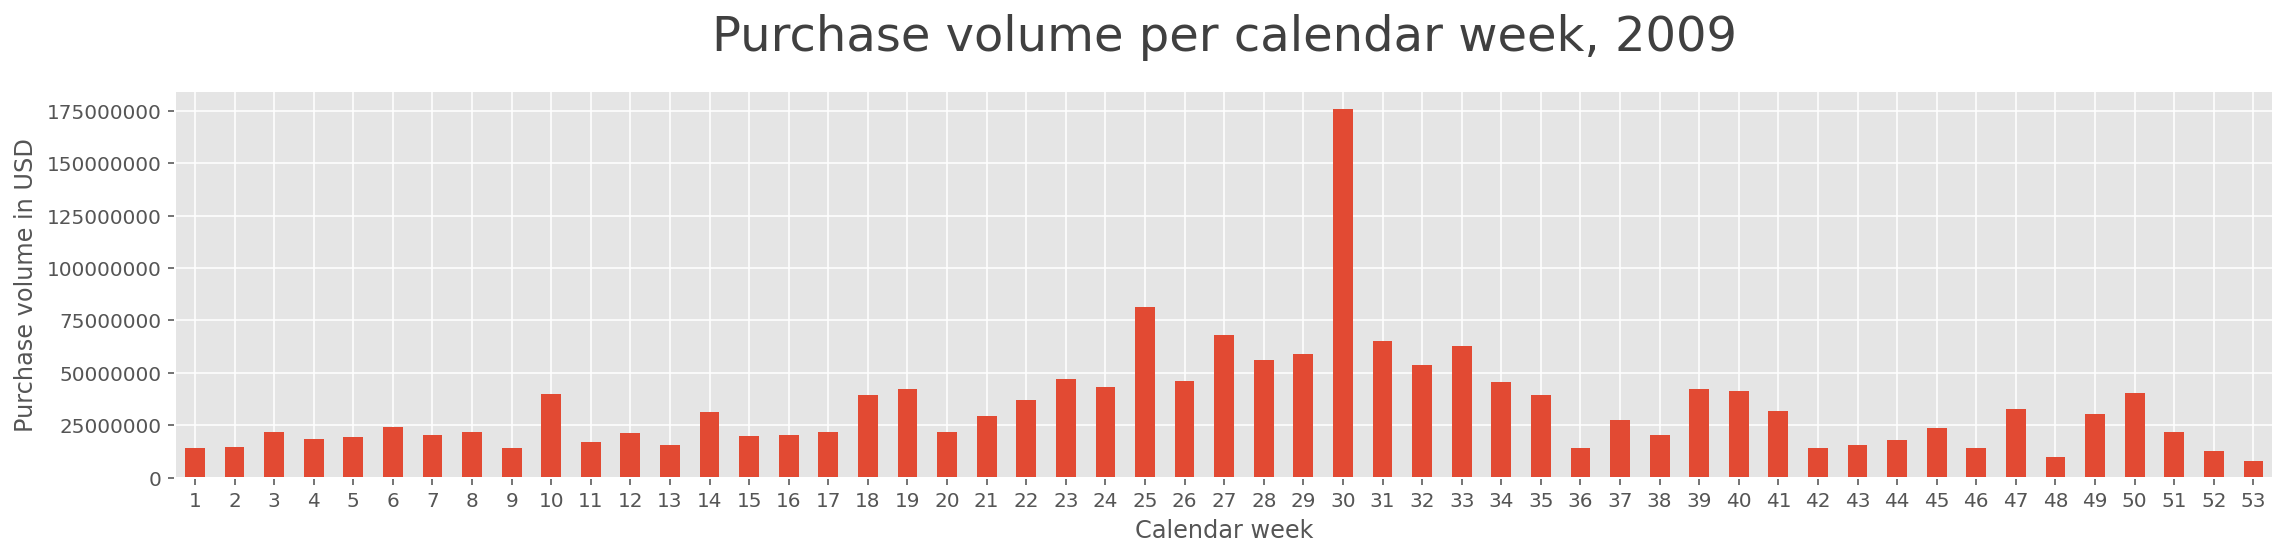

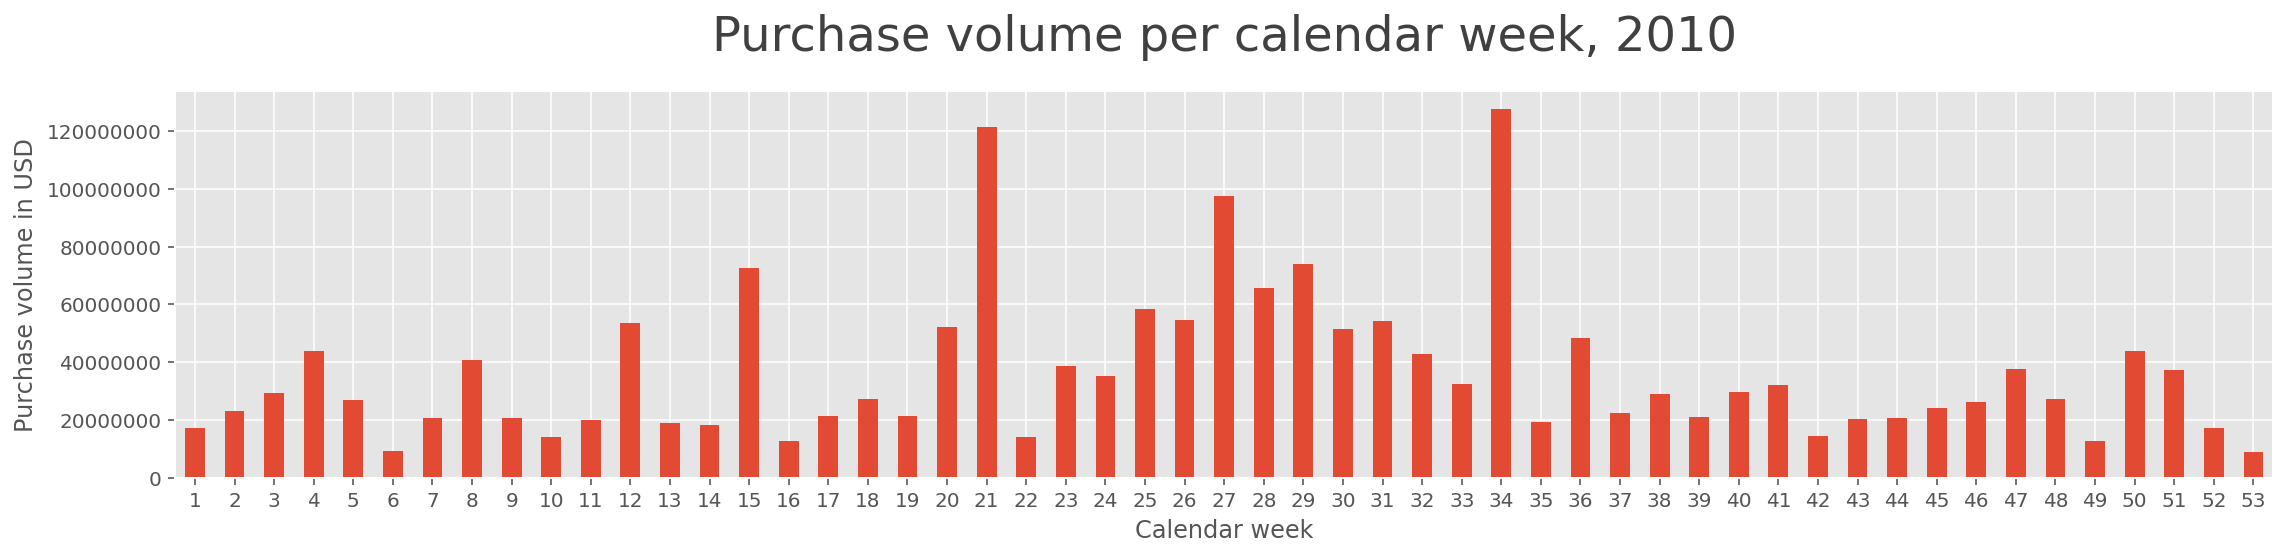

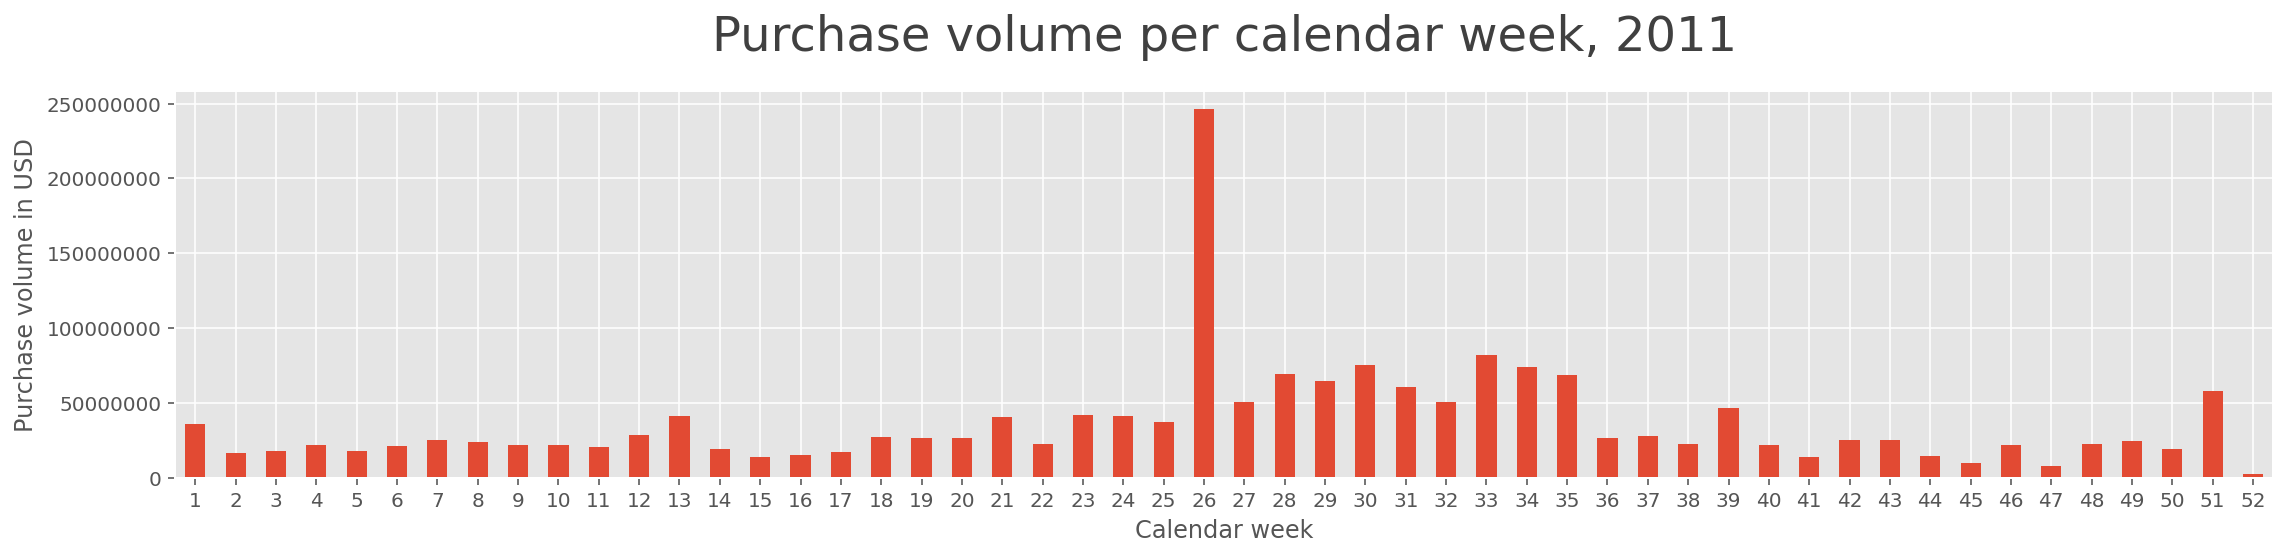

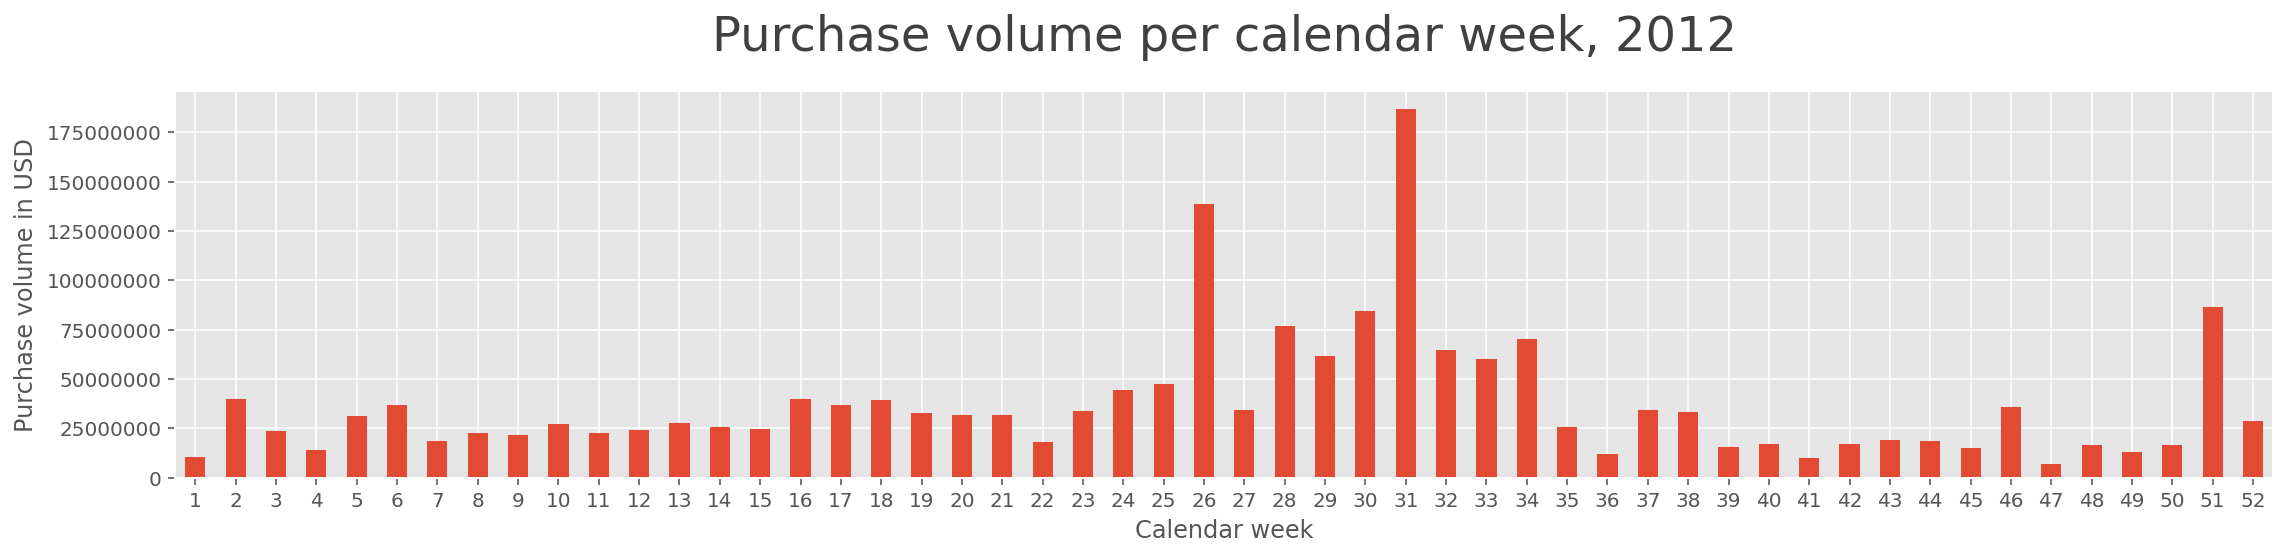

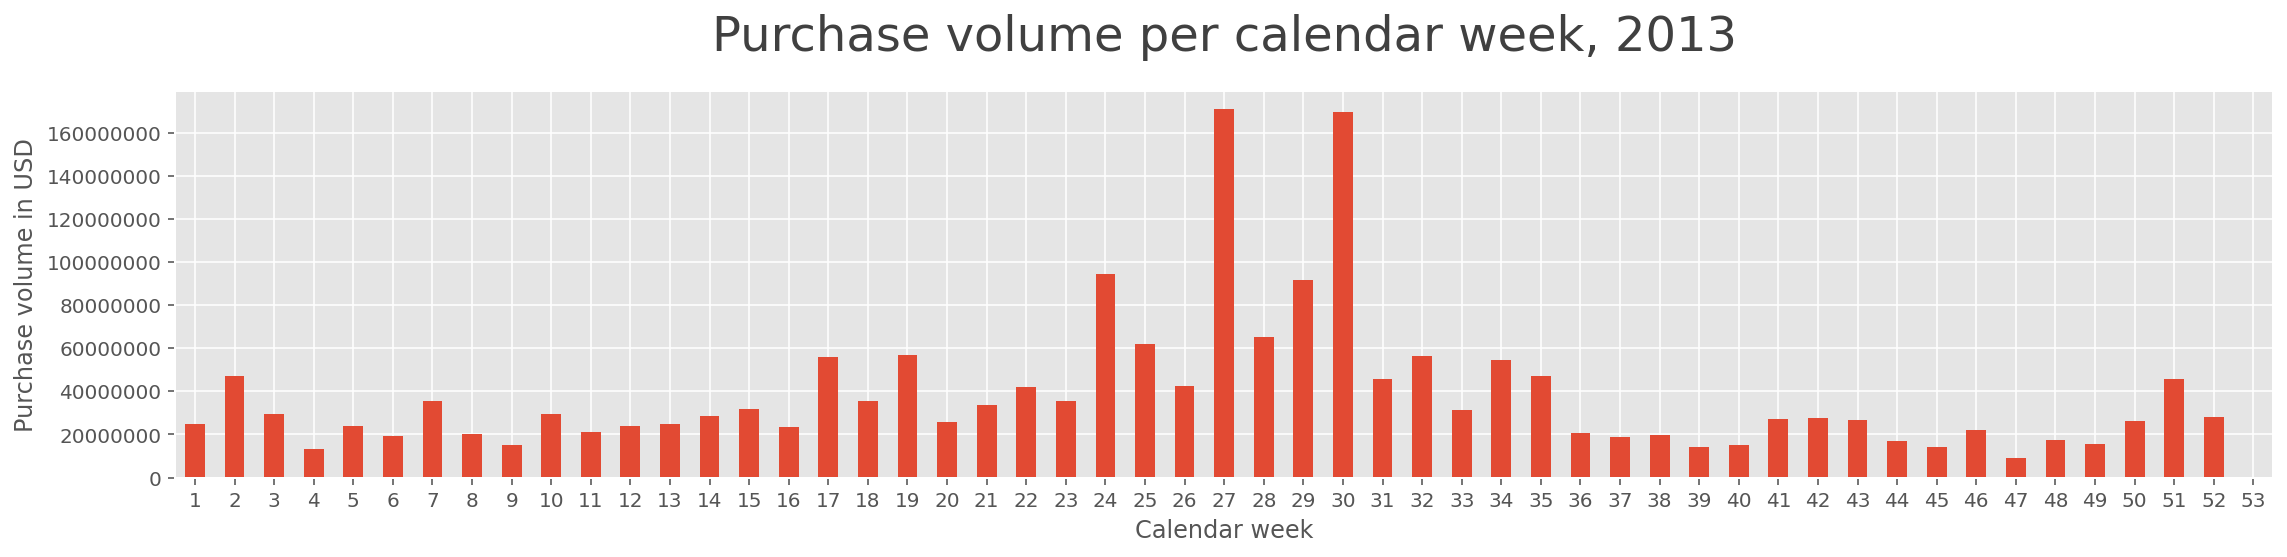

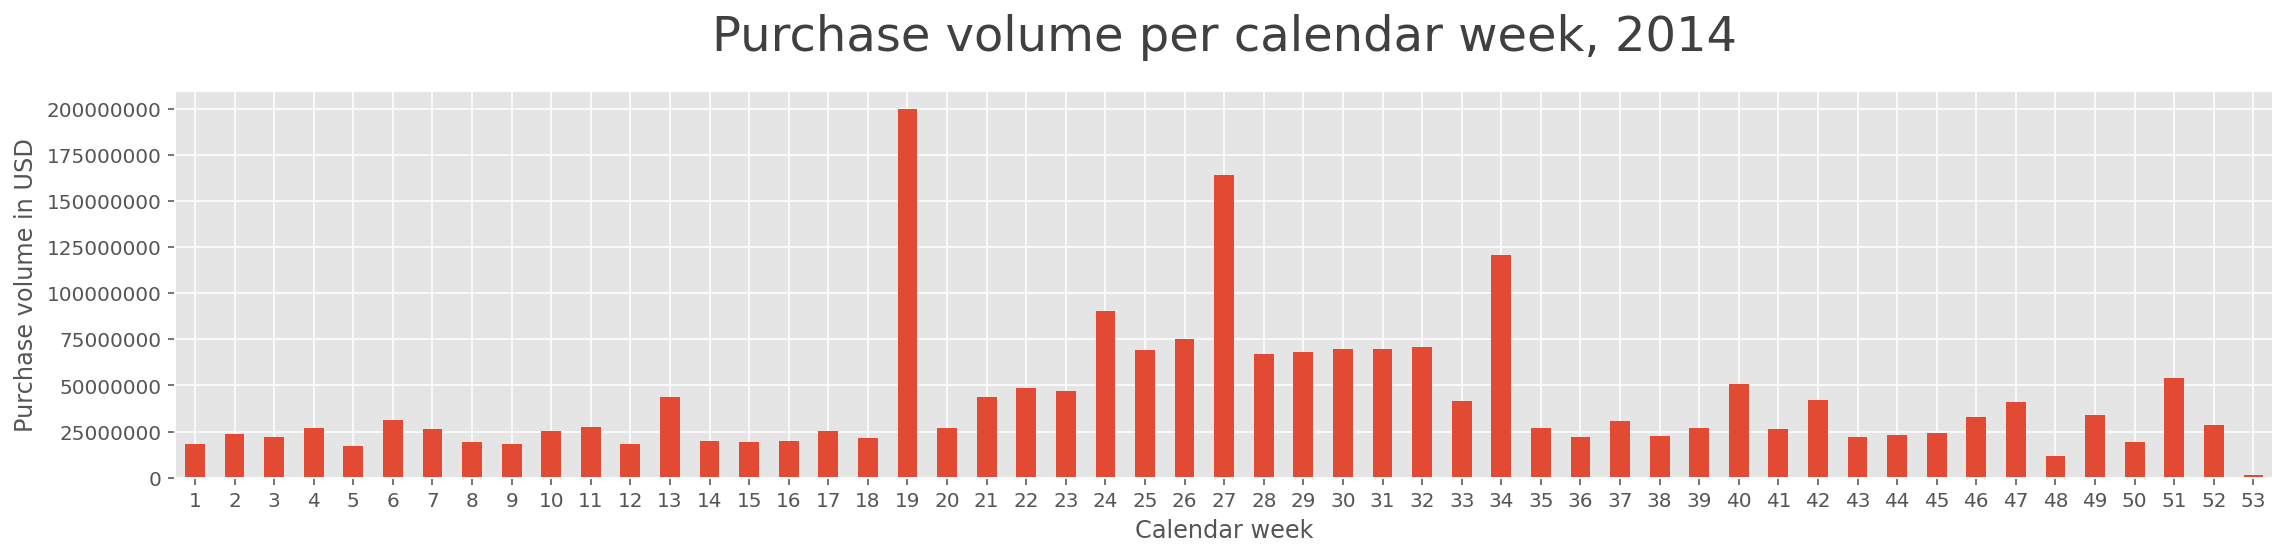

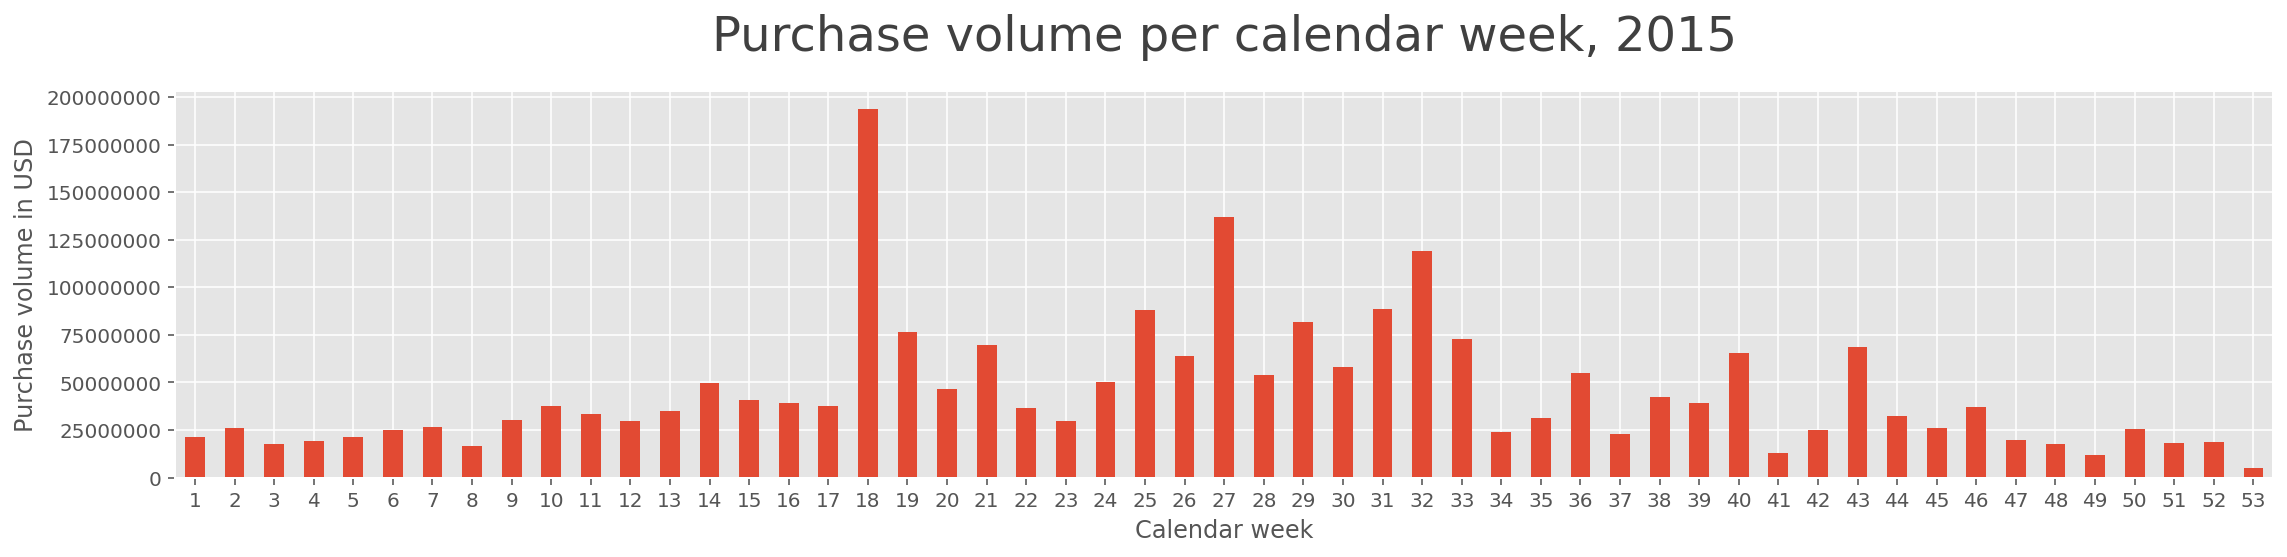

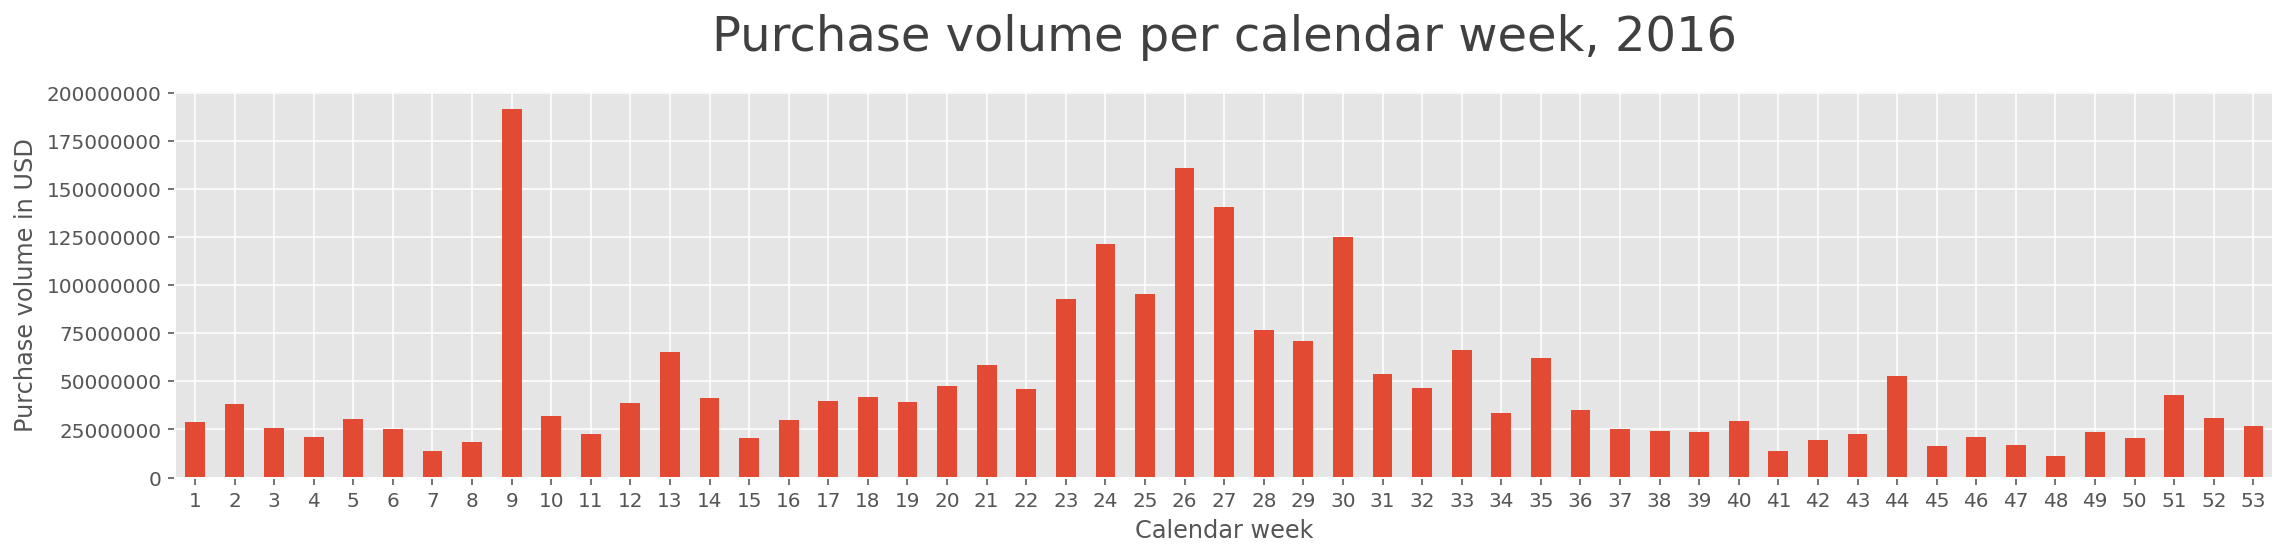

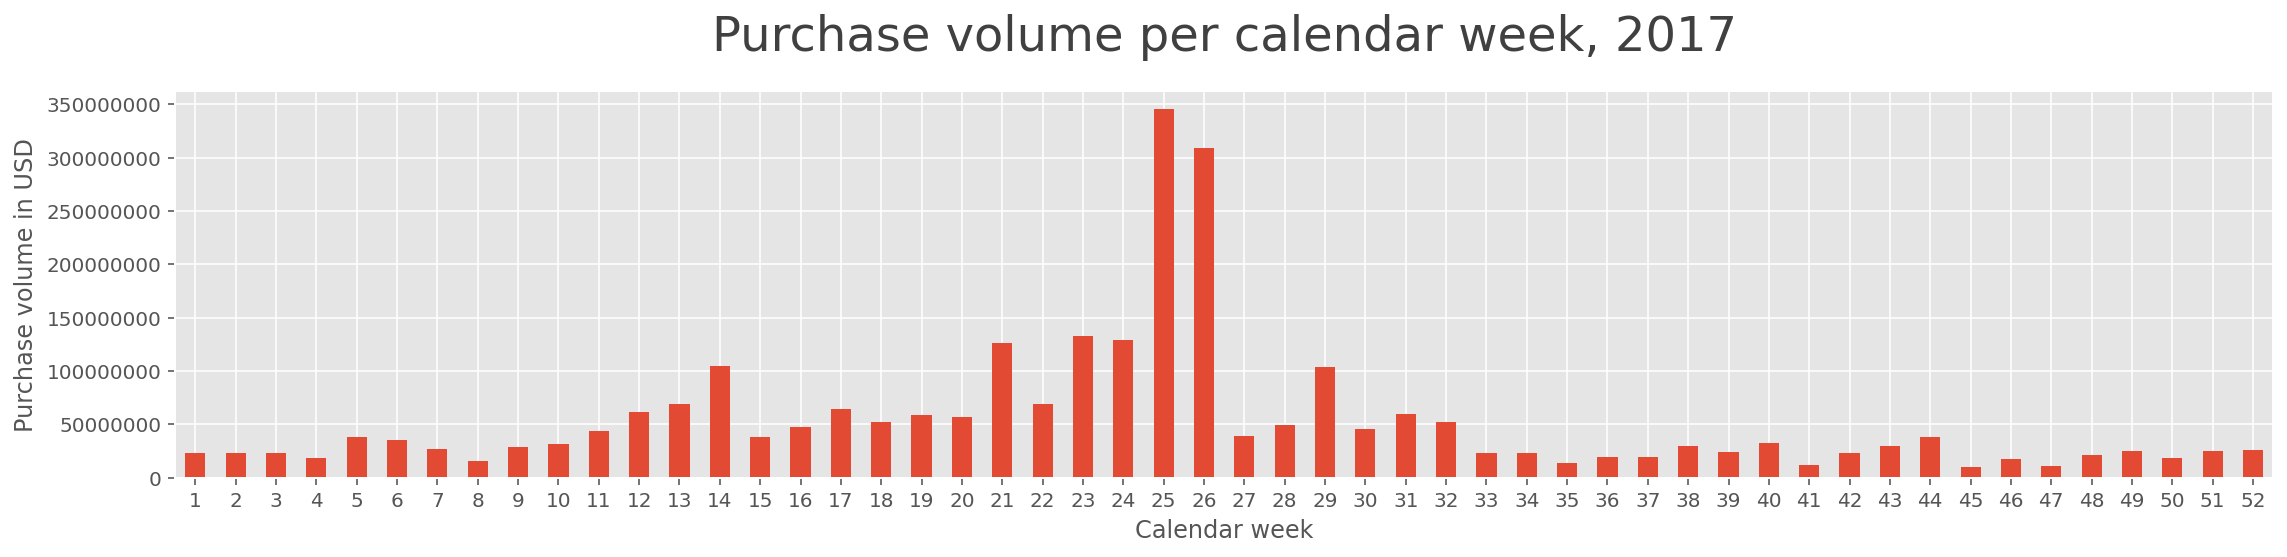

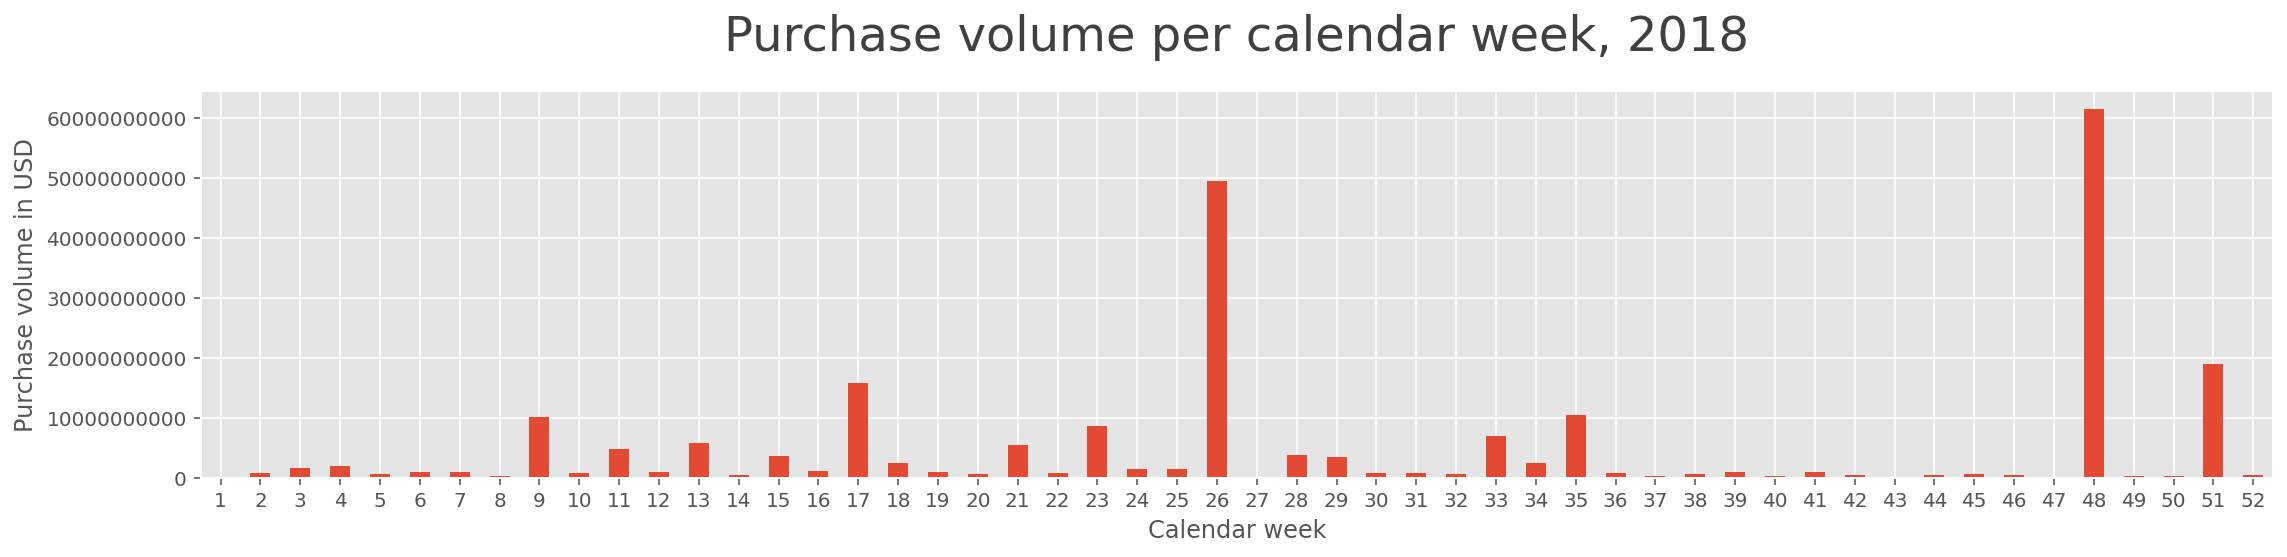

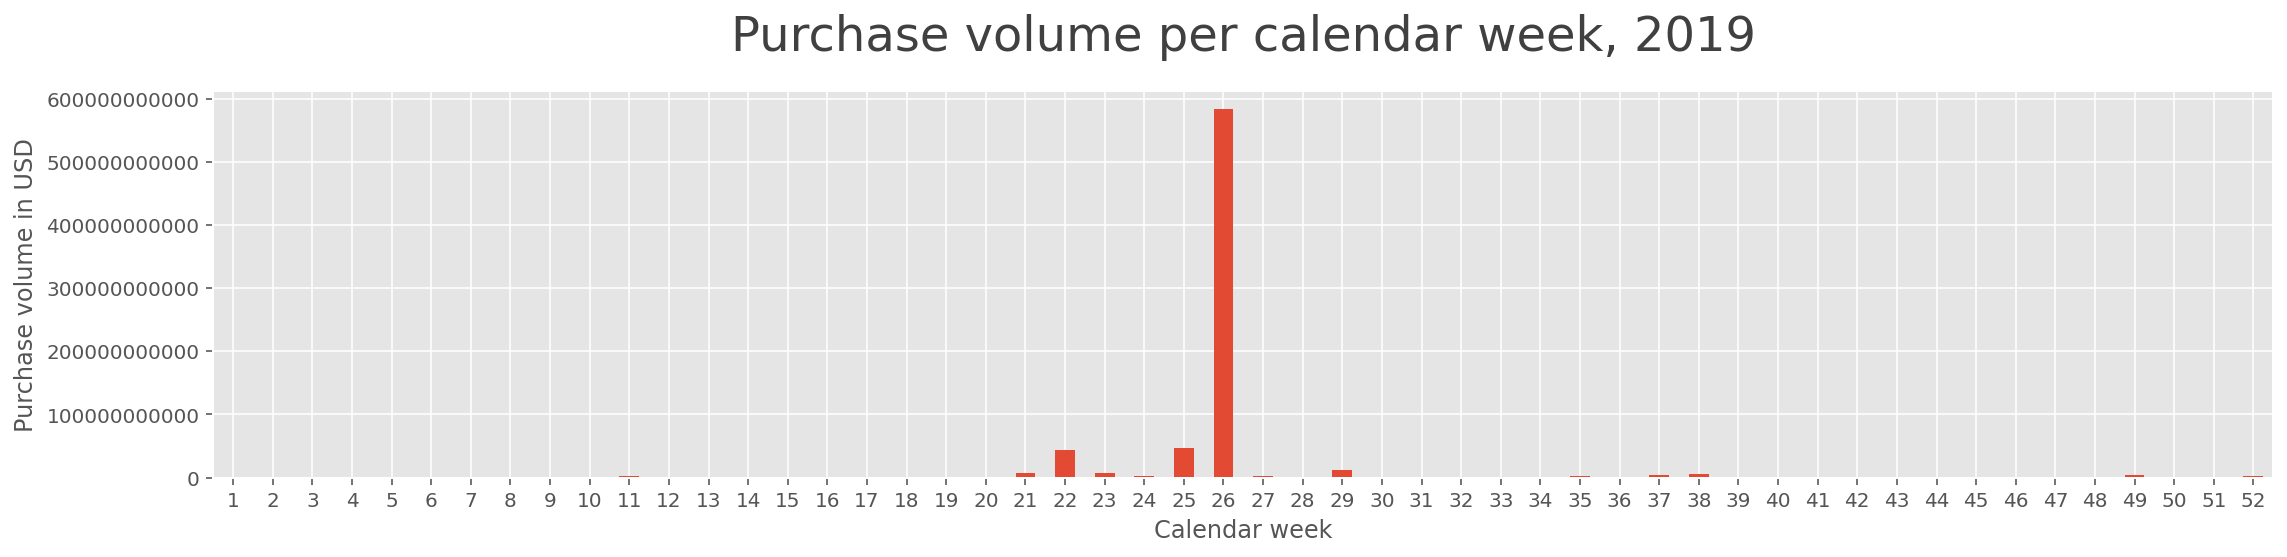

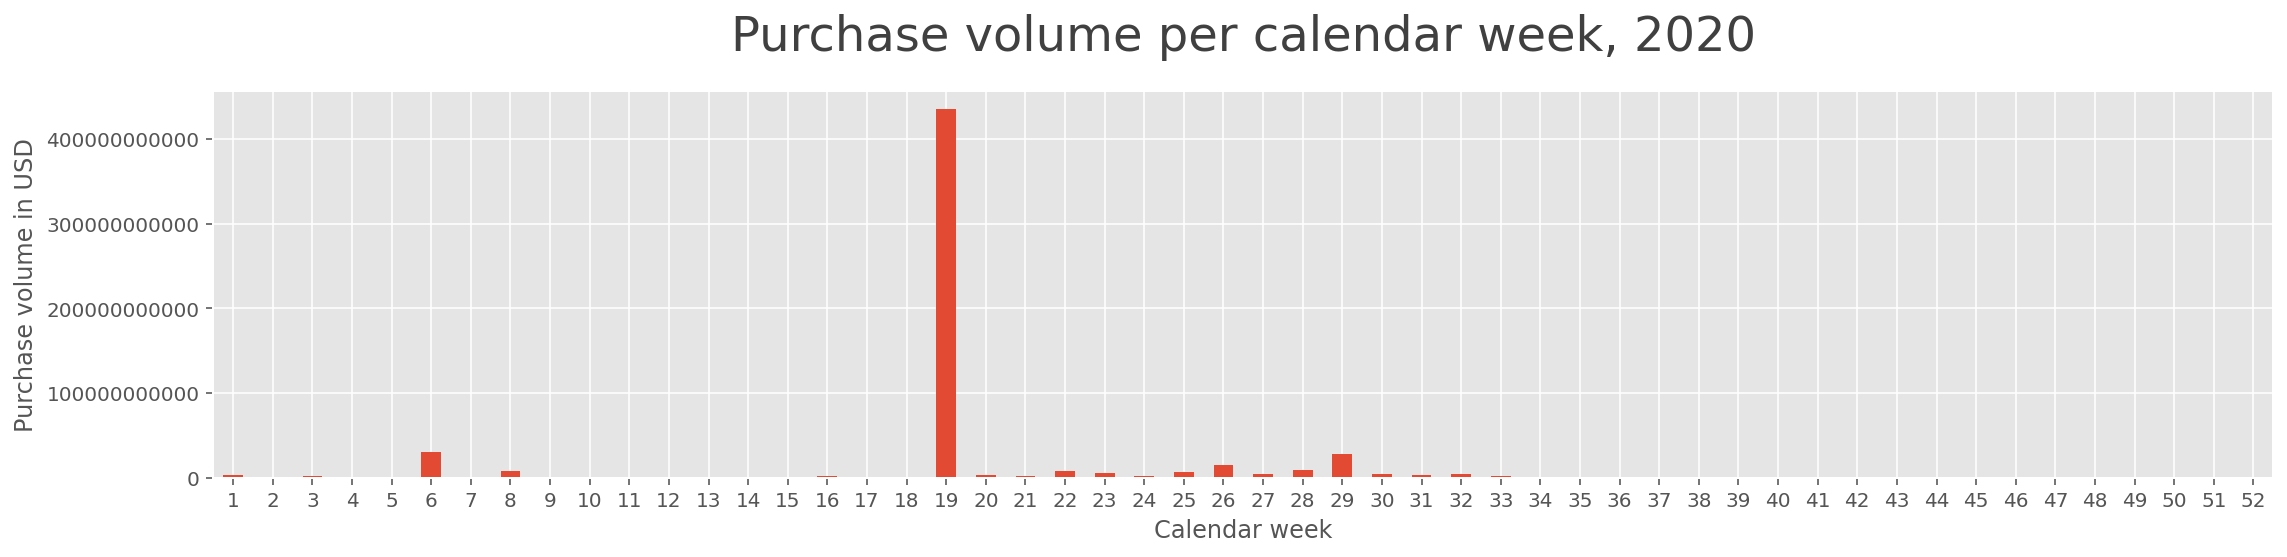

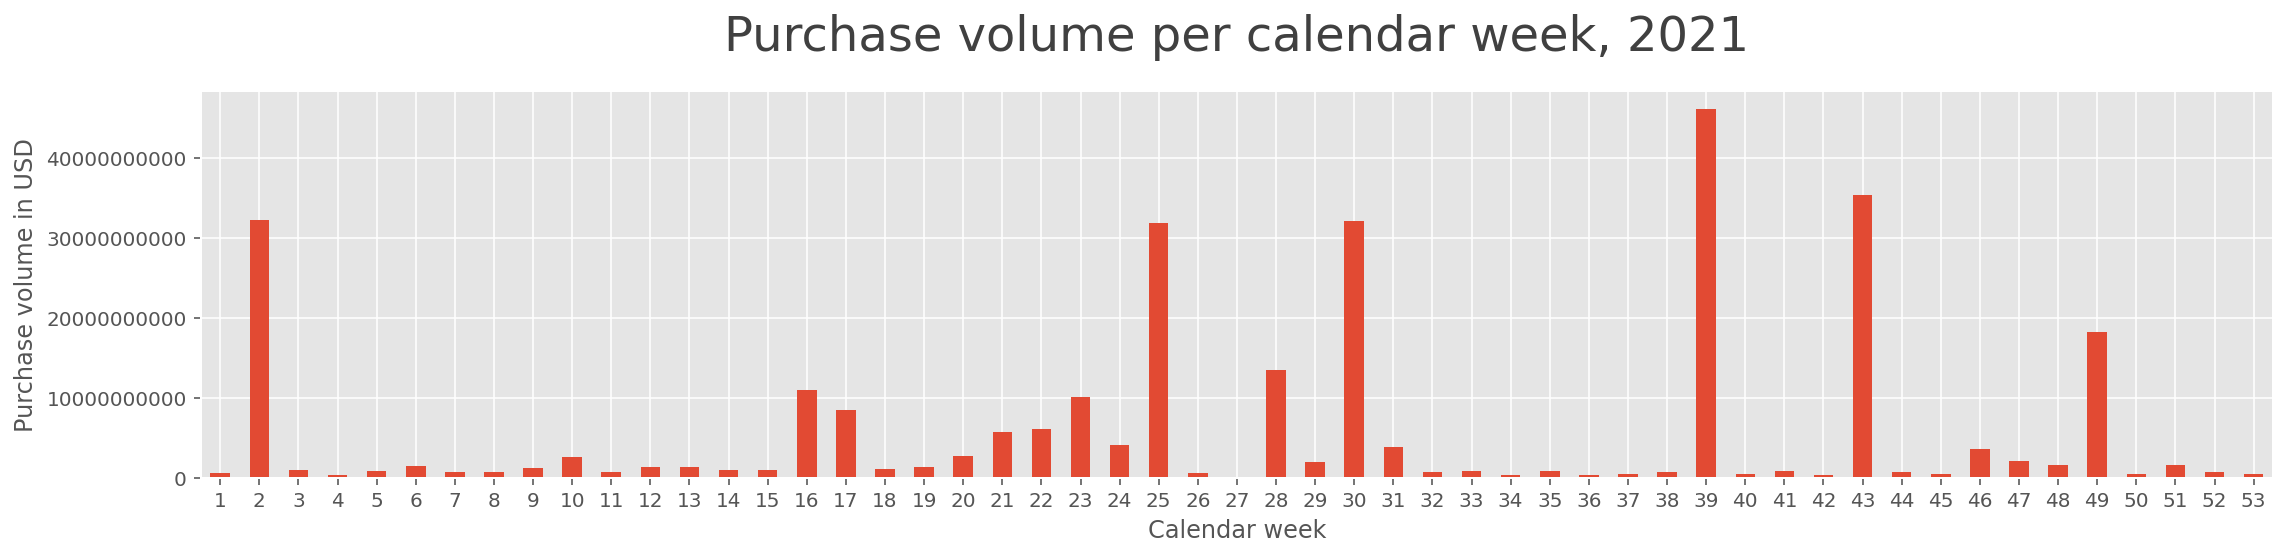

In [28]:
for year in sorted(df.fiscal_year.unique()):
    plt.figure(figsize=(16,4))
    tmp = df[df.fiscal_year==year]
    tmp.groupby(tmp.order_date.dt.isocalendar().week).price.sum().plot.bar()
    plt.title(f"Purchase volume per calendar week, {year}", size=TITLE_SIZE, pad=TITLE_PADDING)
    plt.ticklabel_format(axis="y", style="plain")
    plt.xticks(rotation=0)
    plt.ylabel("Purchase volume in USD")
    plt.xlabel("Calendar week")
    plt.tight_layout()
    plt.show()

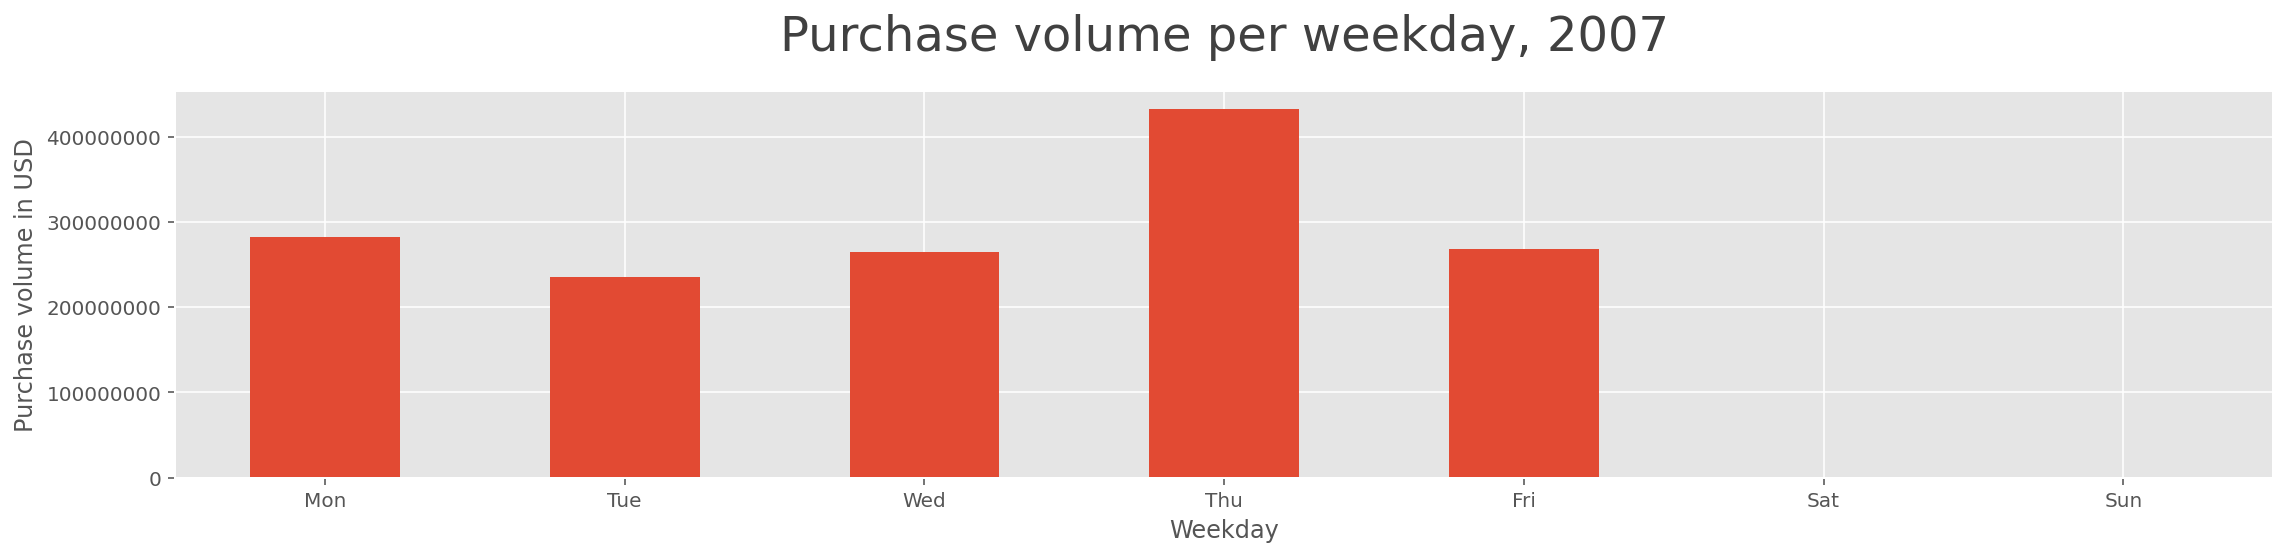

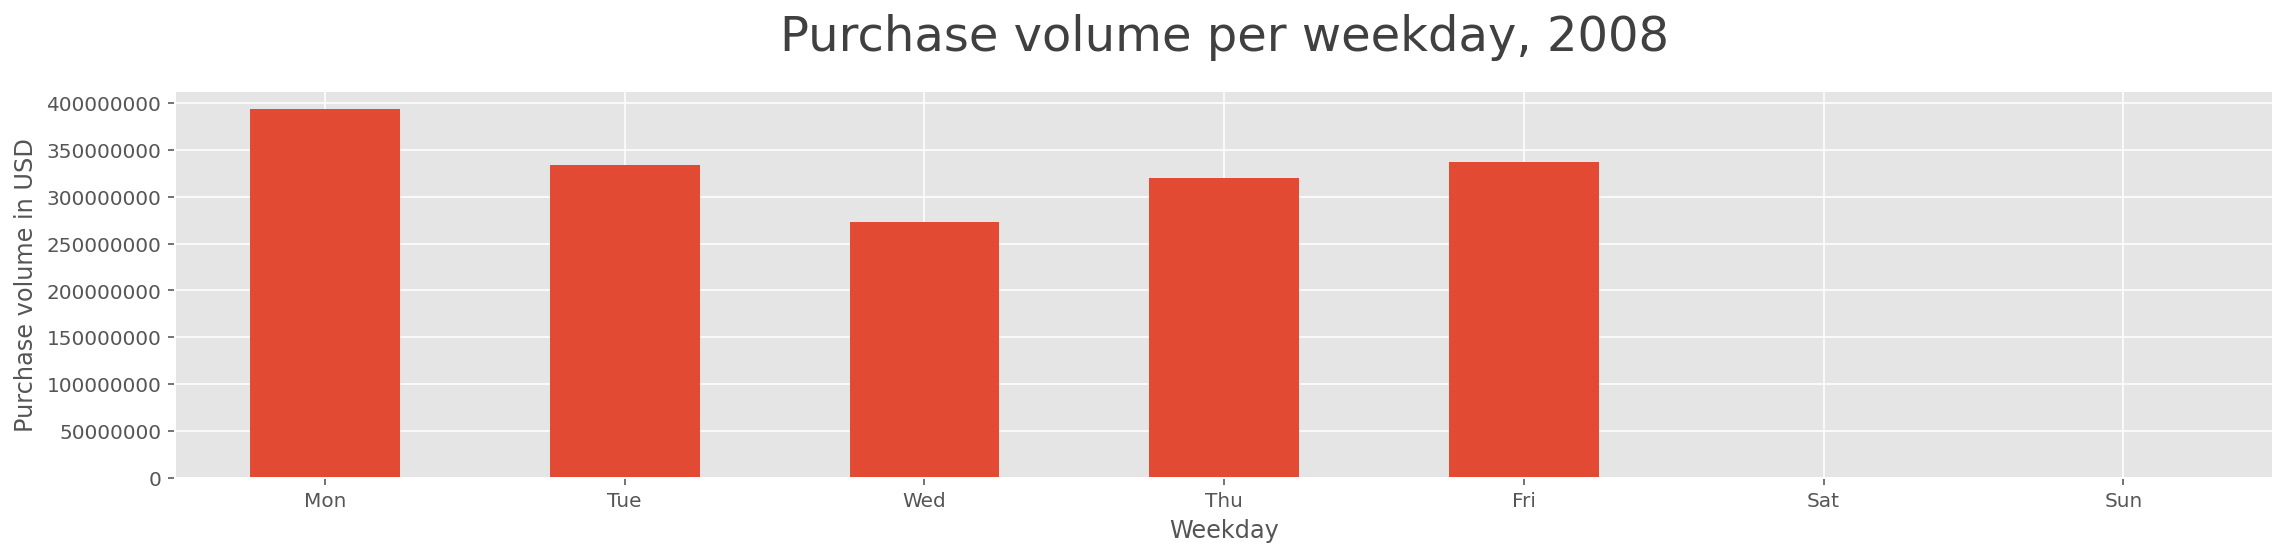

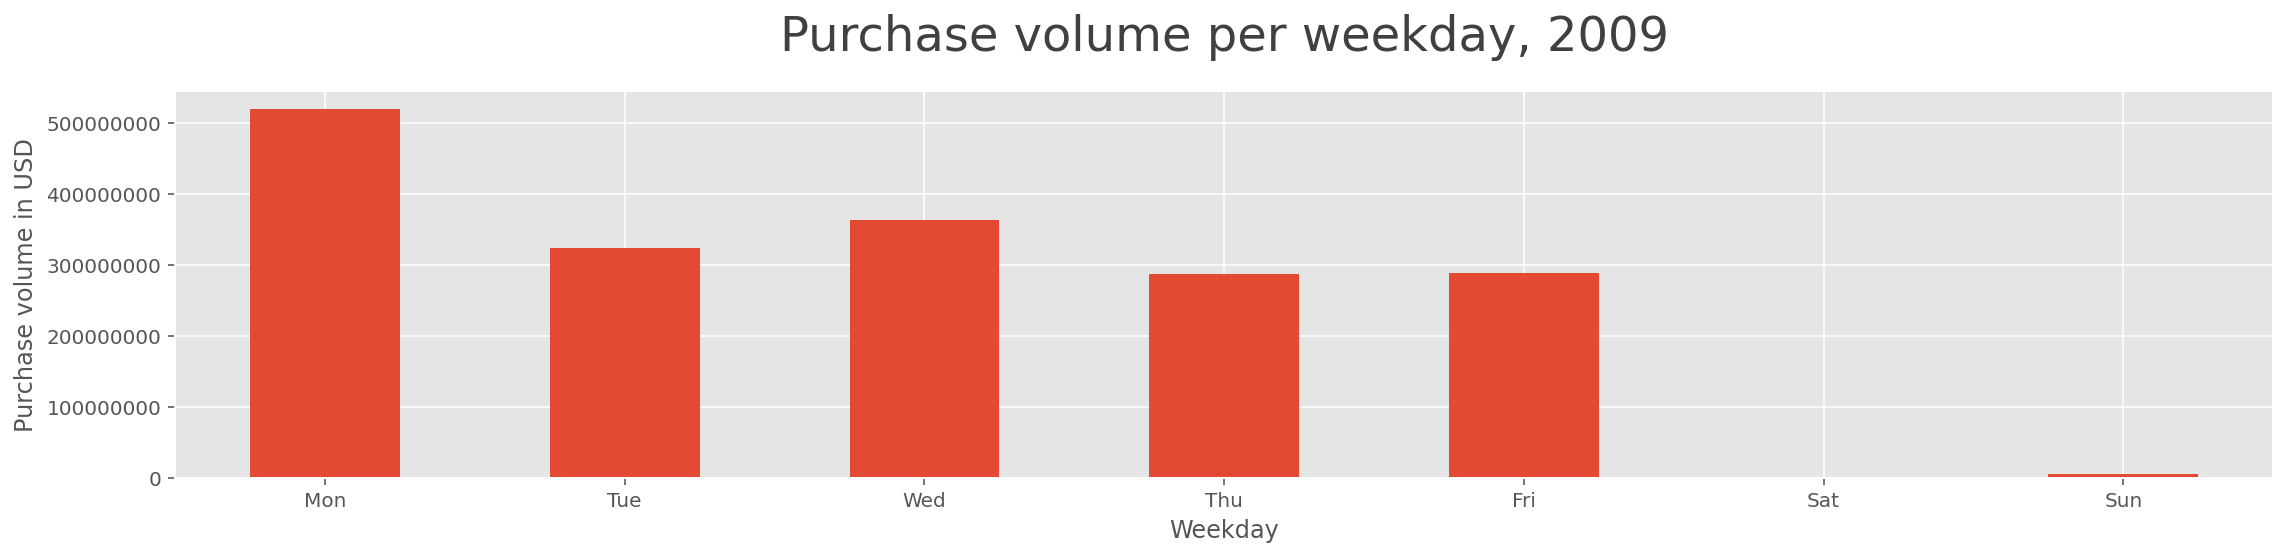

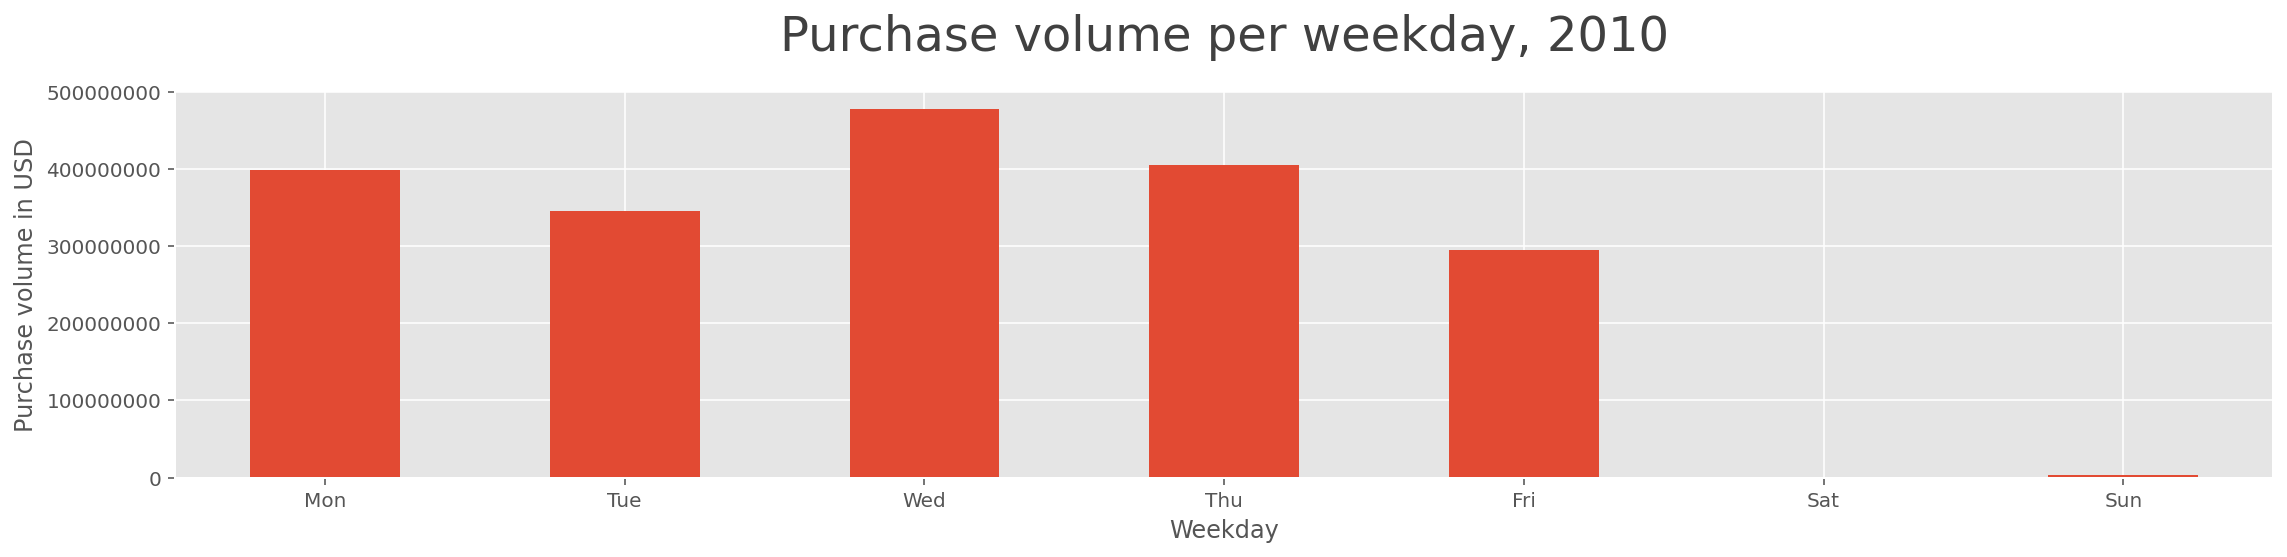

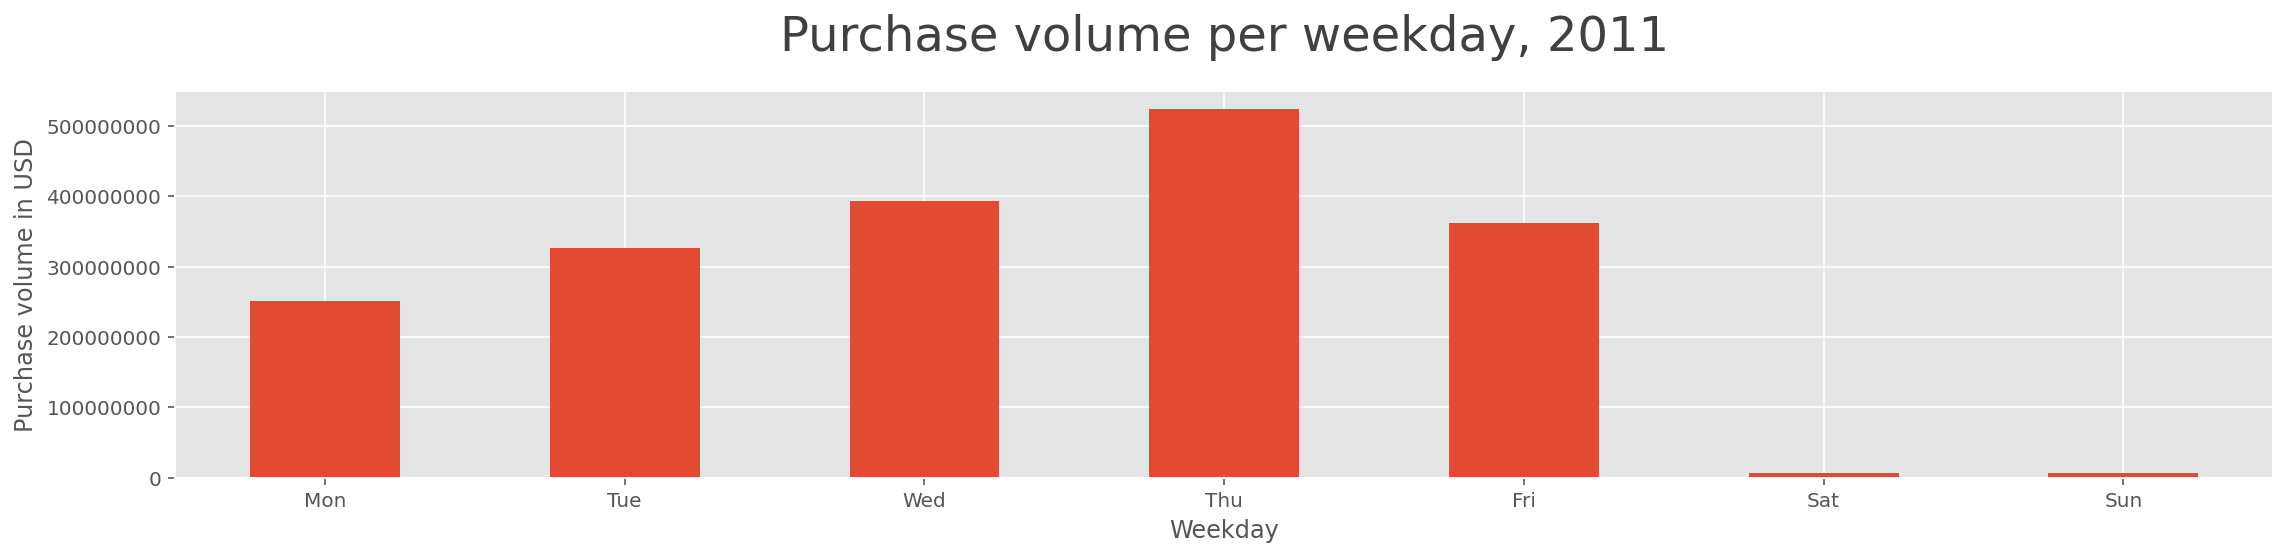

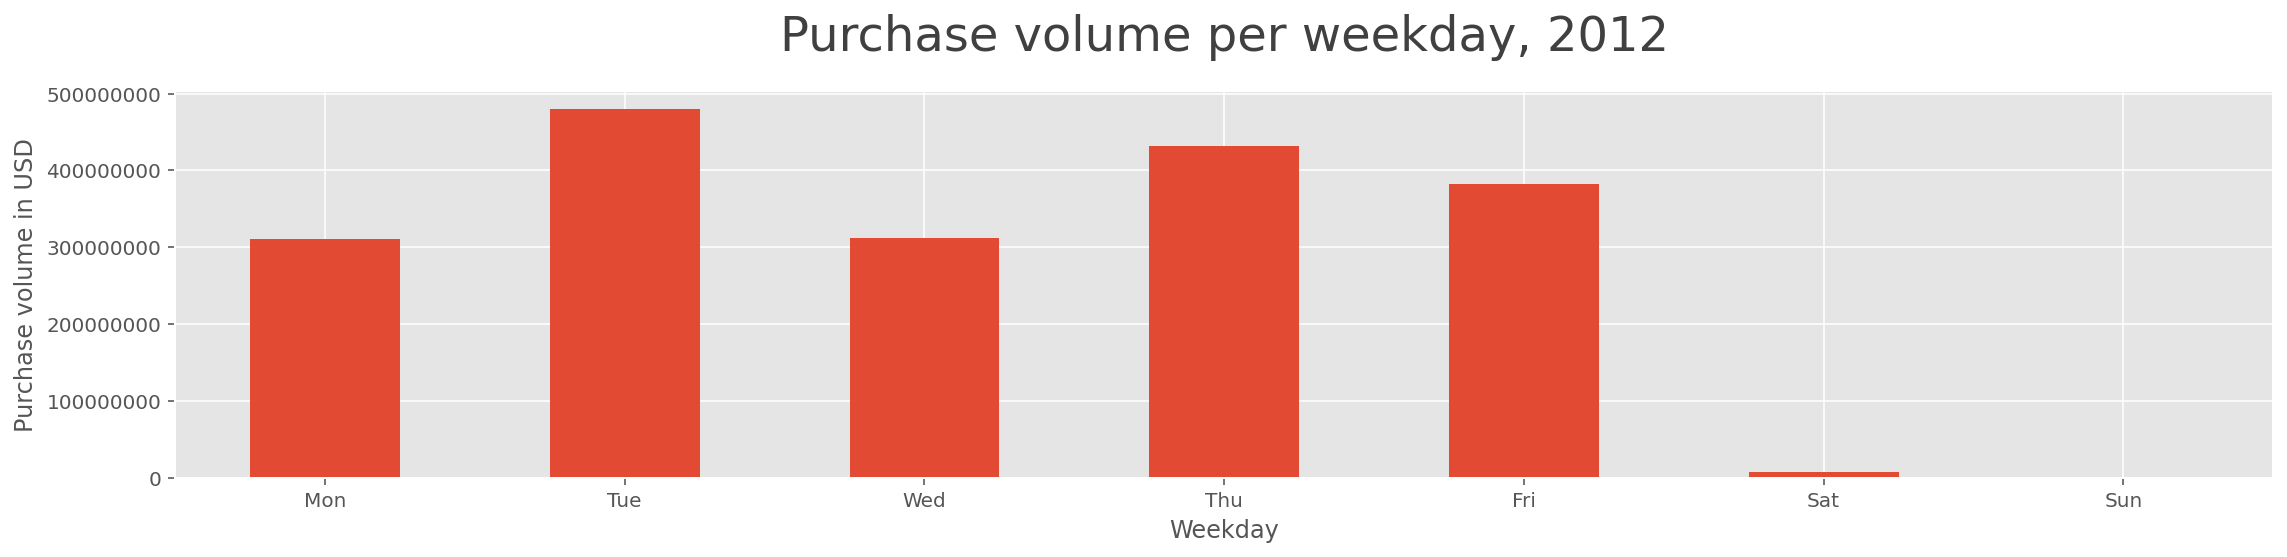

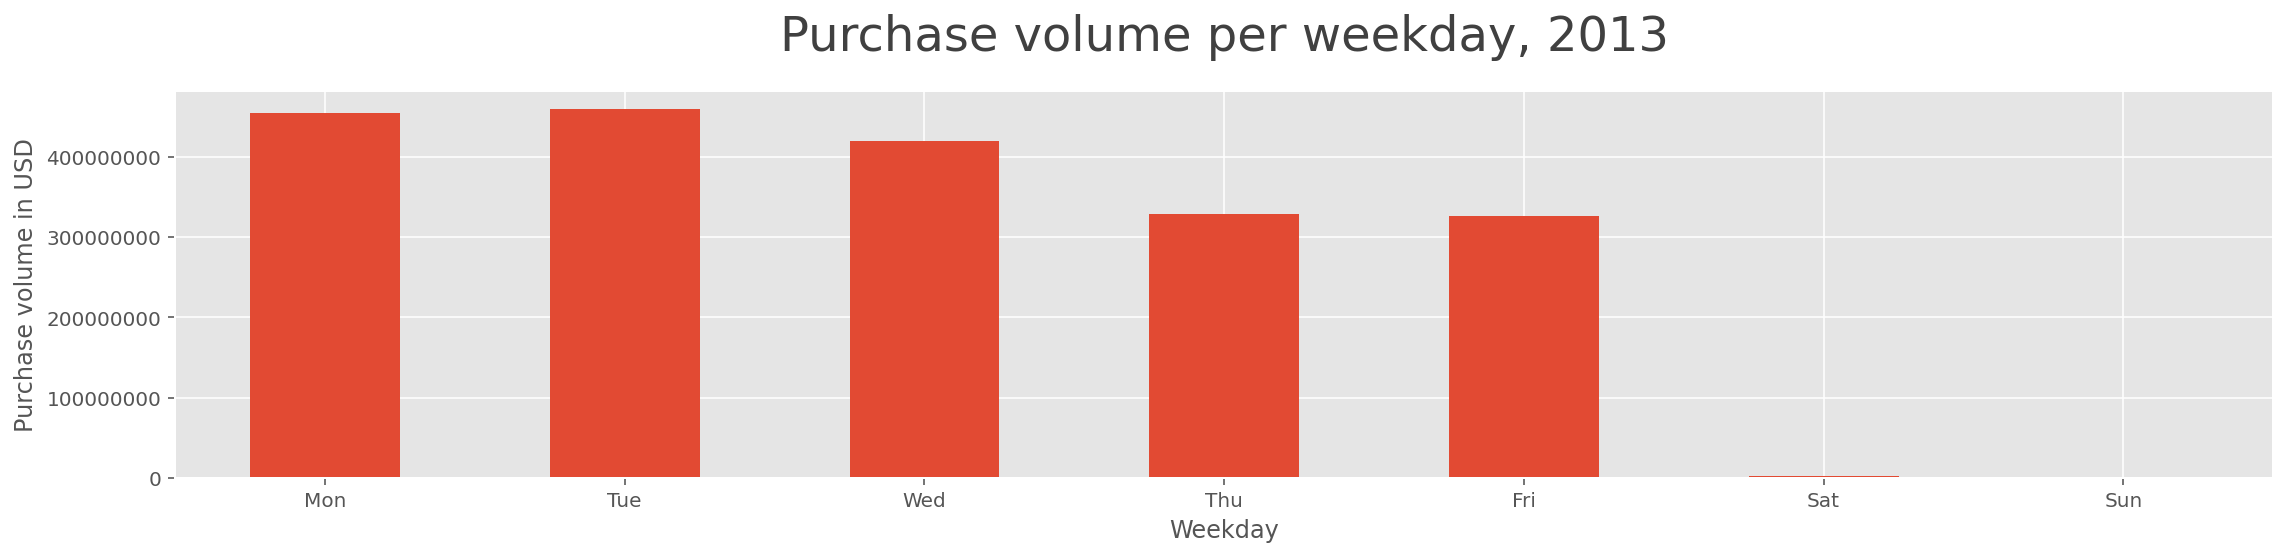

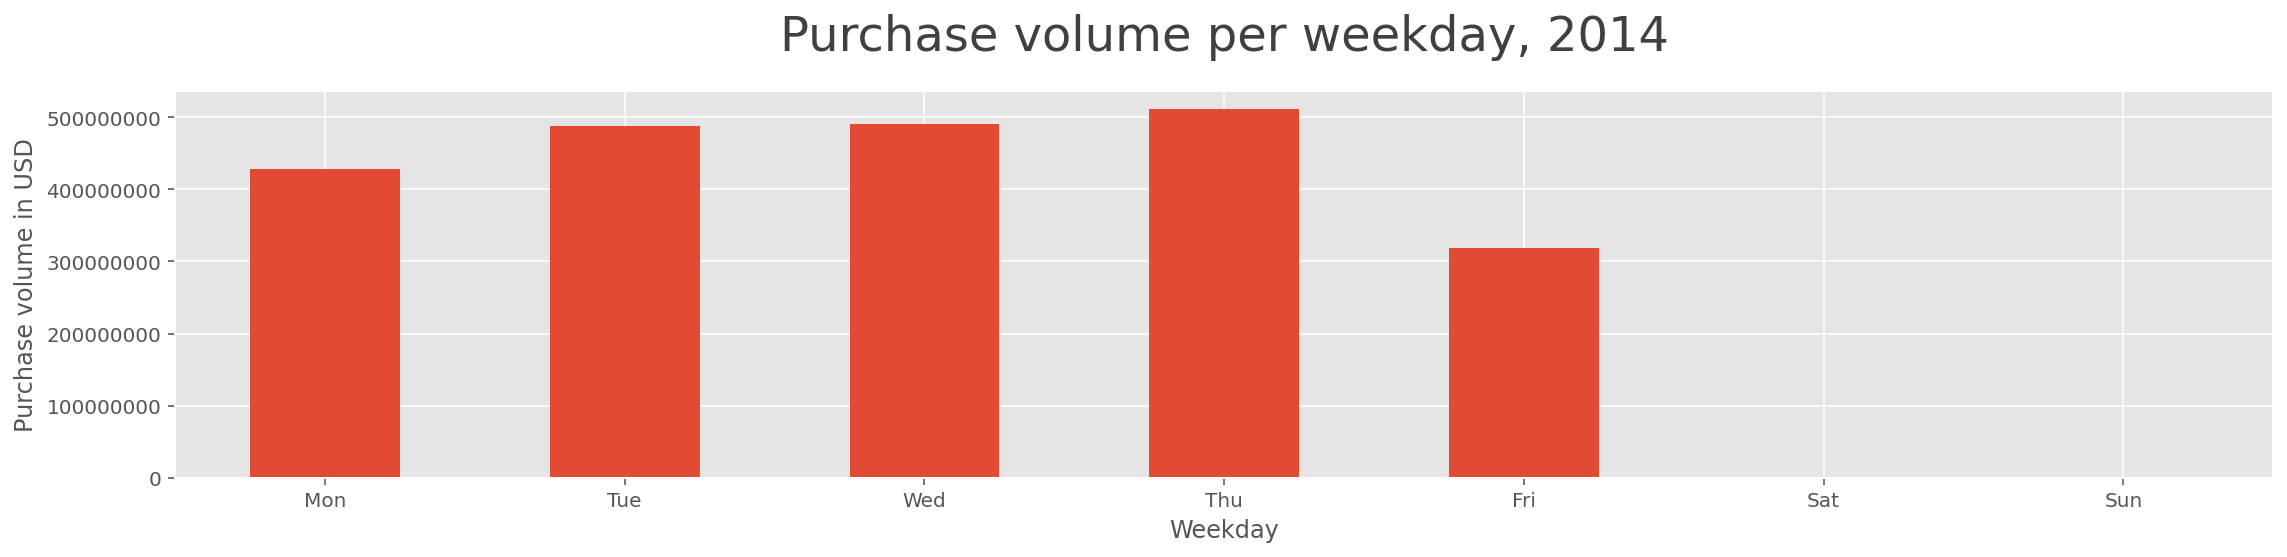

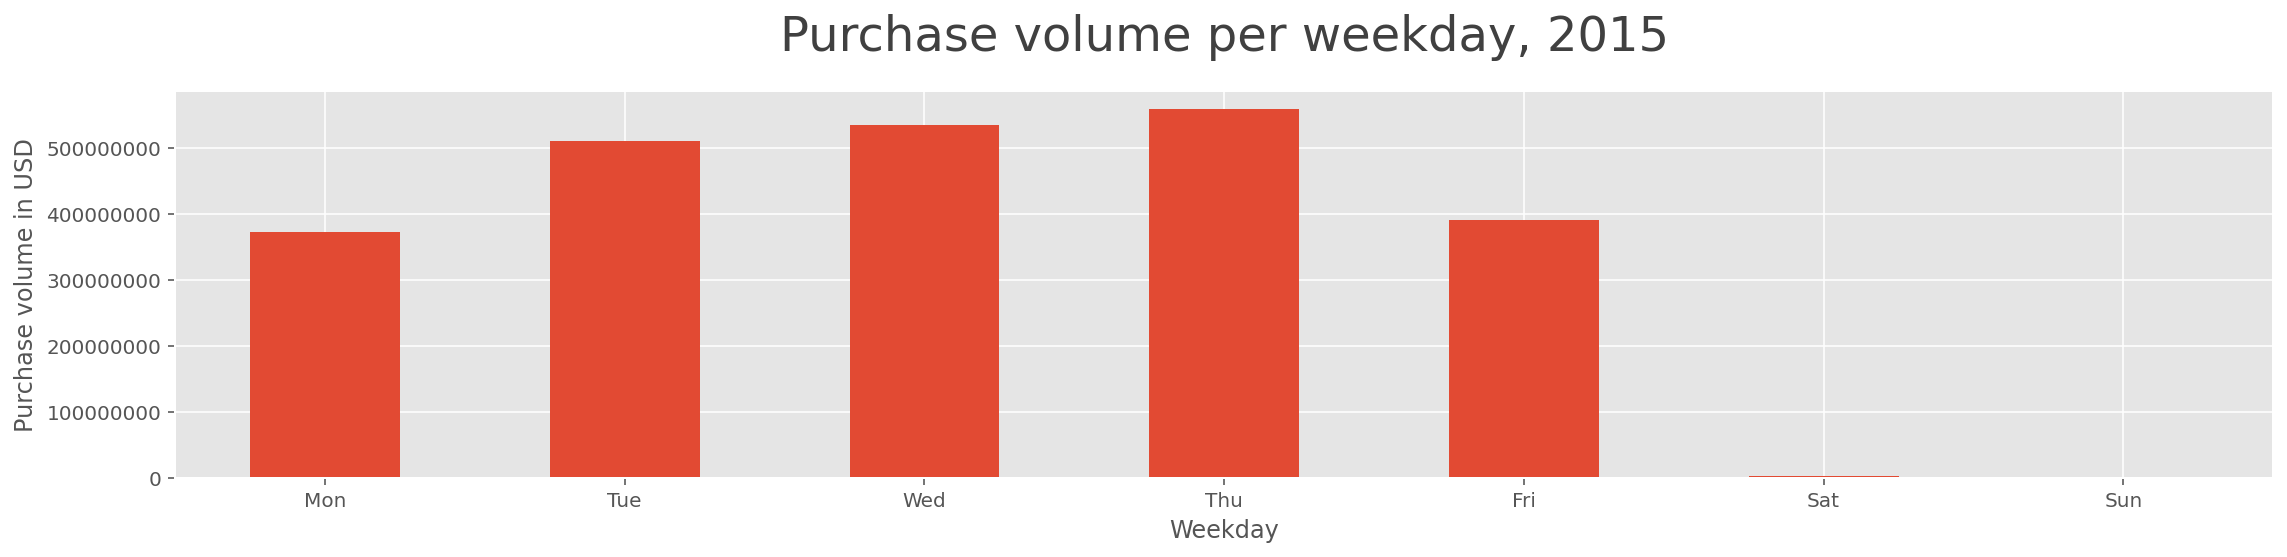

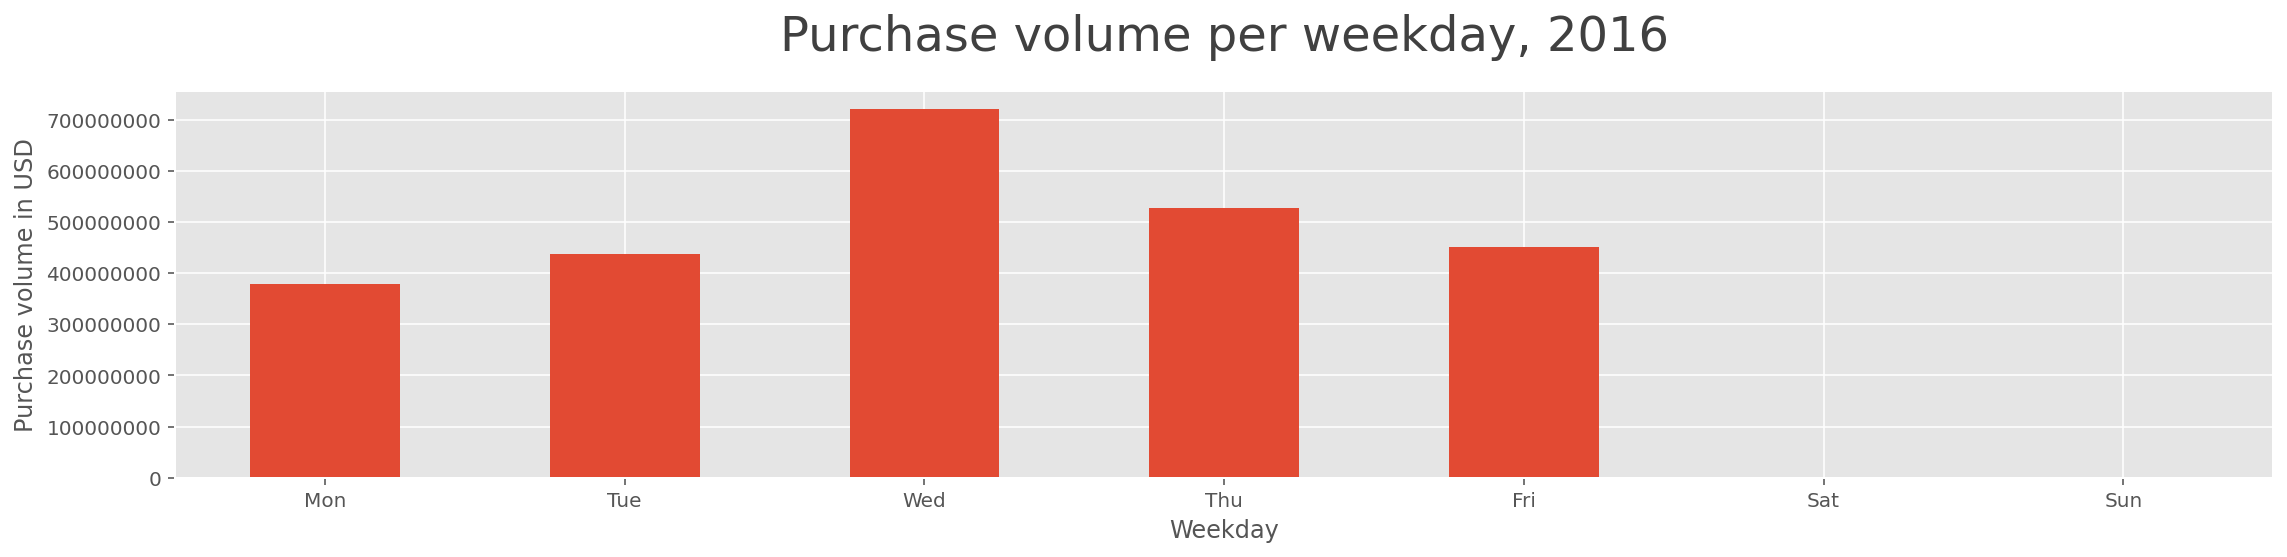

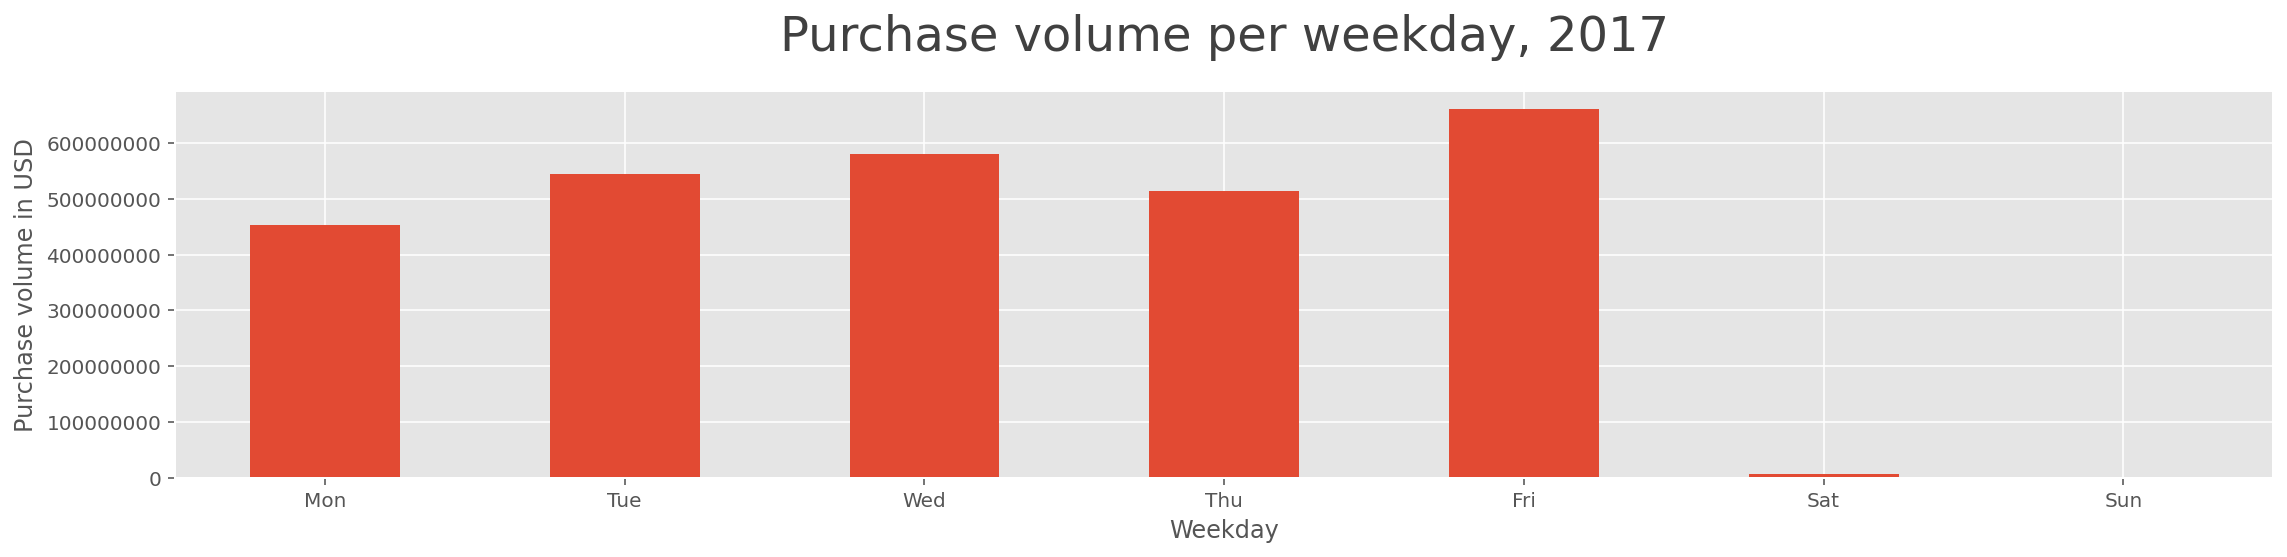

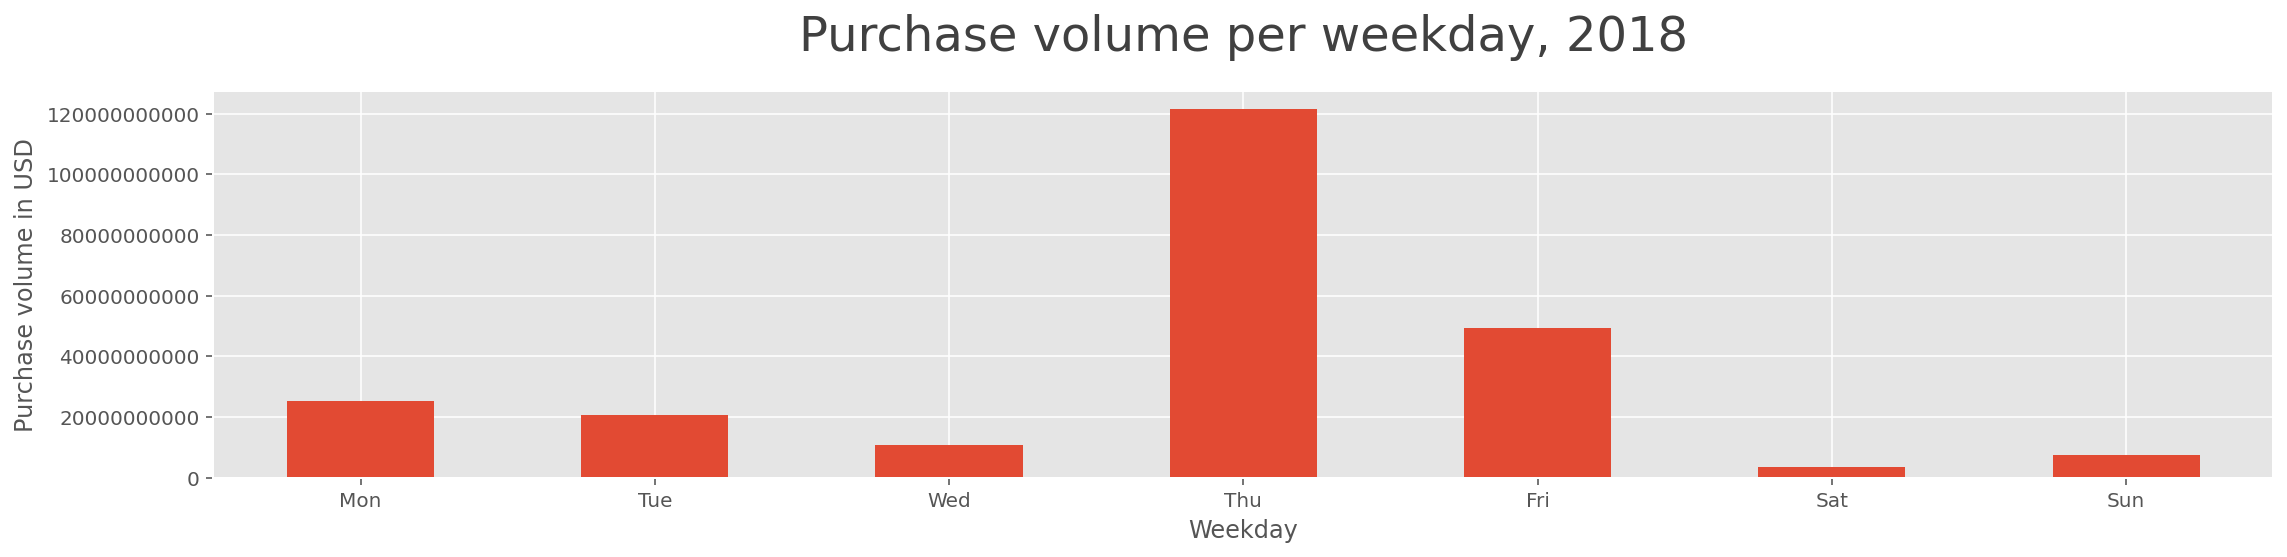

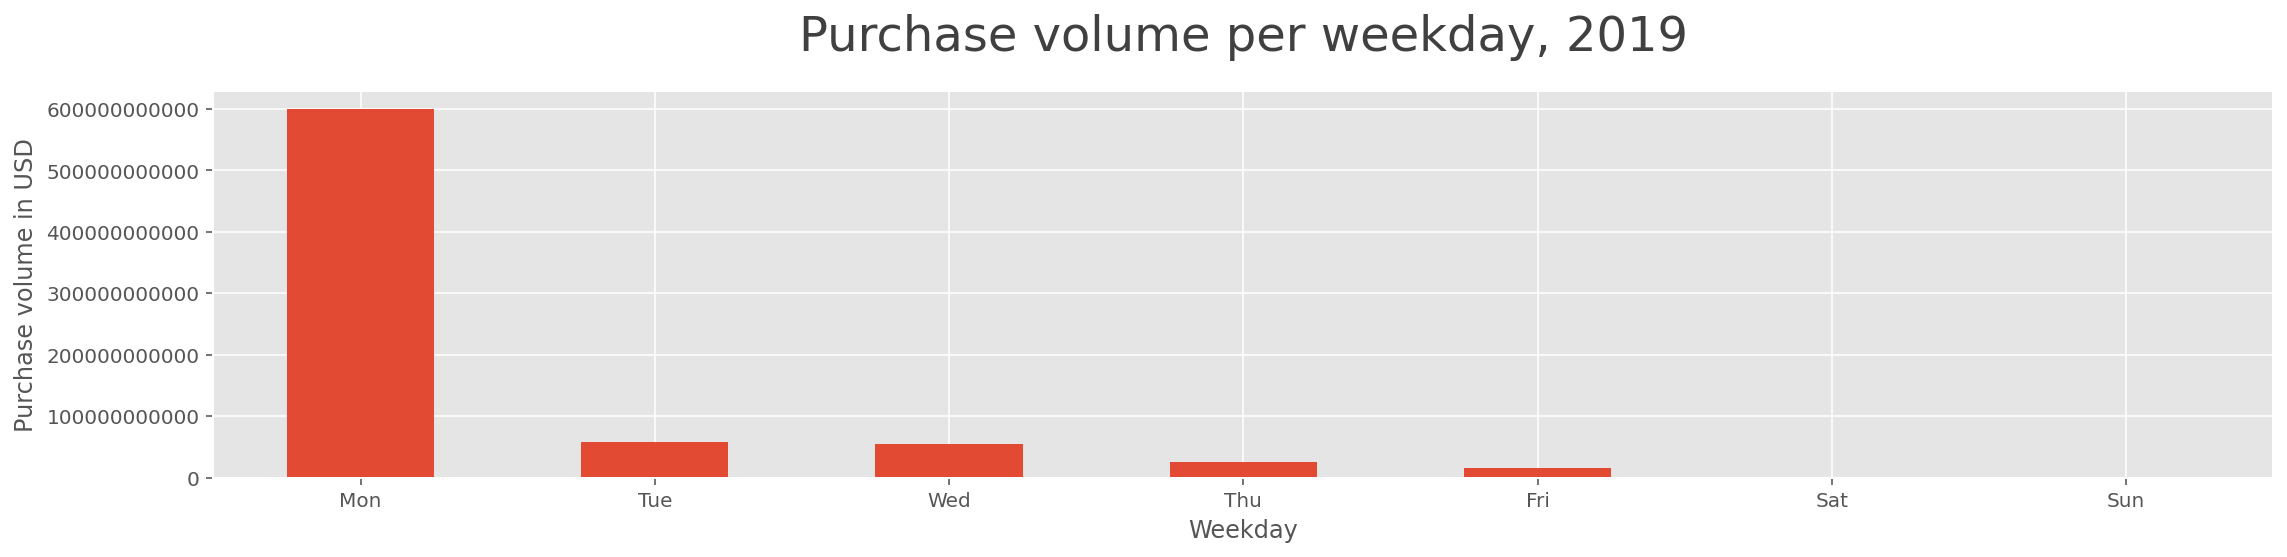

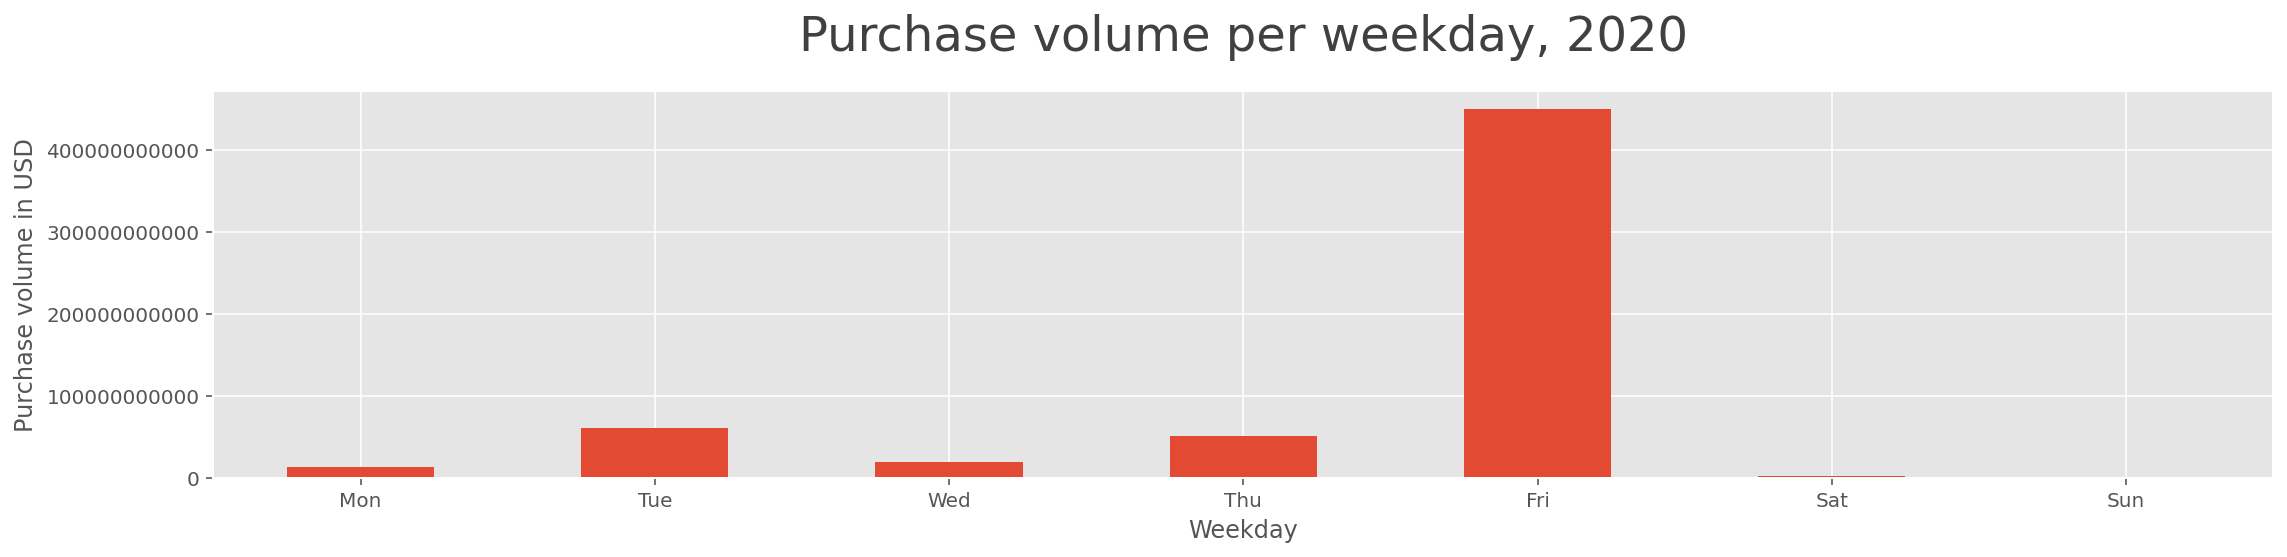

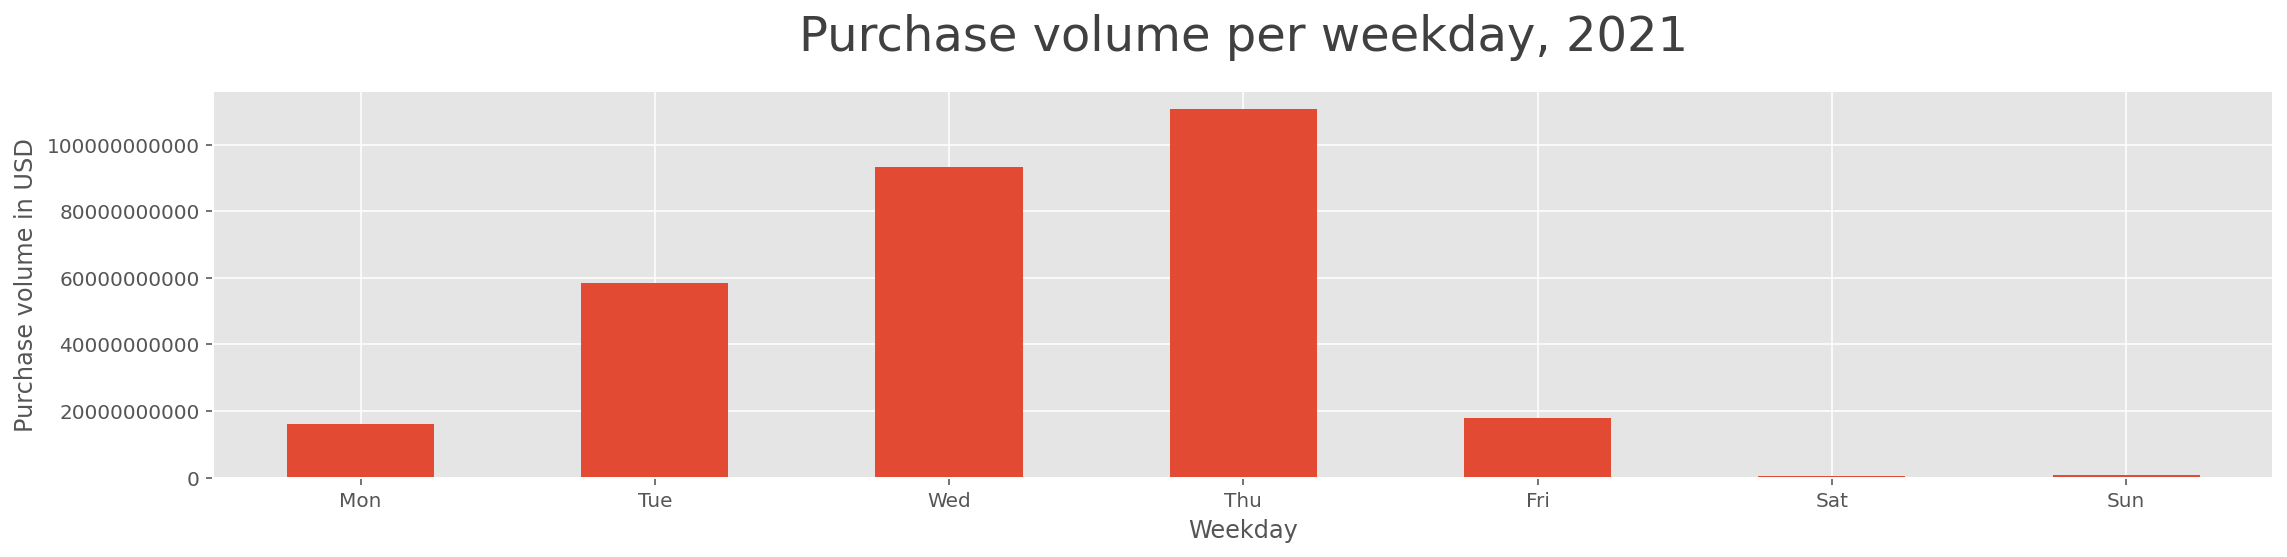

In [29]:
for year in sorted(df.fiscal_year.unique()):
    plt.figure(figsize=(16,4))
    tmp = df[df.fiscal_year==year]
    tmp.groupby(tmp.order_date.dt.weekday).price.sum().plot.bar()
    plt.title(f"Purchase volume per weekday, {year}", size=TITLE_SIZE, pad=TITLE_PADDING)
    plt.ticklabel_format(axis="y", style="plain")
    plt.xticks(ticks=range(0, 7), labels=list(calendar.day_abbr), rotation=0)
    plt.ylabel("Purchase volume in USD")
    plt.xlabel("Weekday")
    plt.tight_layout()
    plt.show()

Plotting **order counts** per time units I notice:
- There are above average order counts in week 2, 21 and 26 of the year. 
- Most orders are being made during working days, much less on weekends.

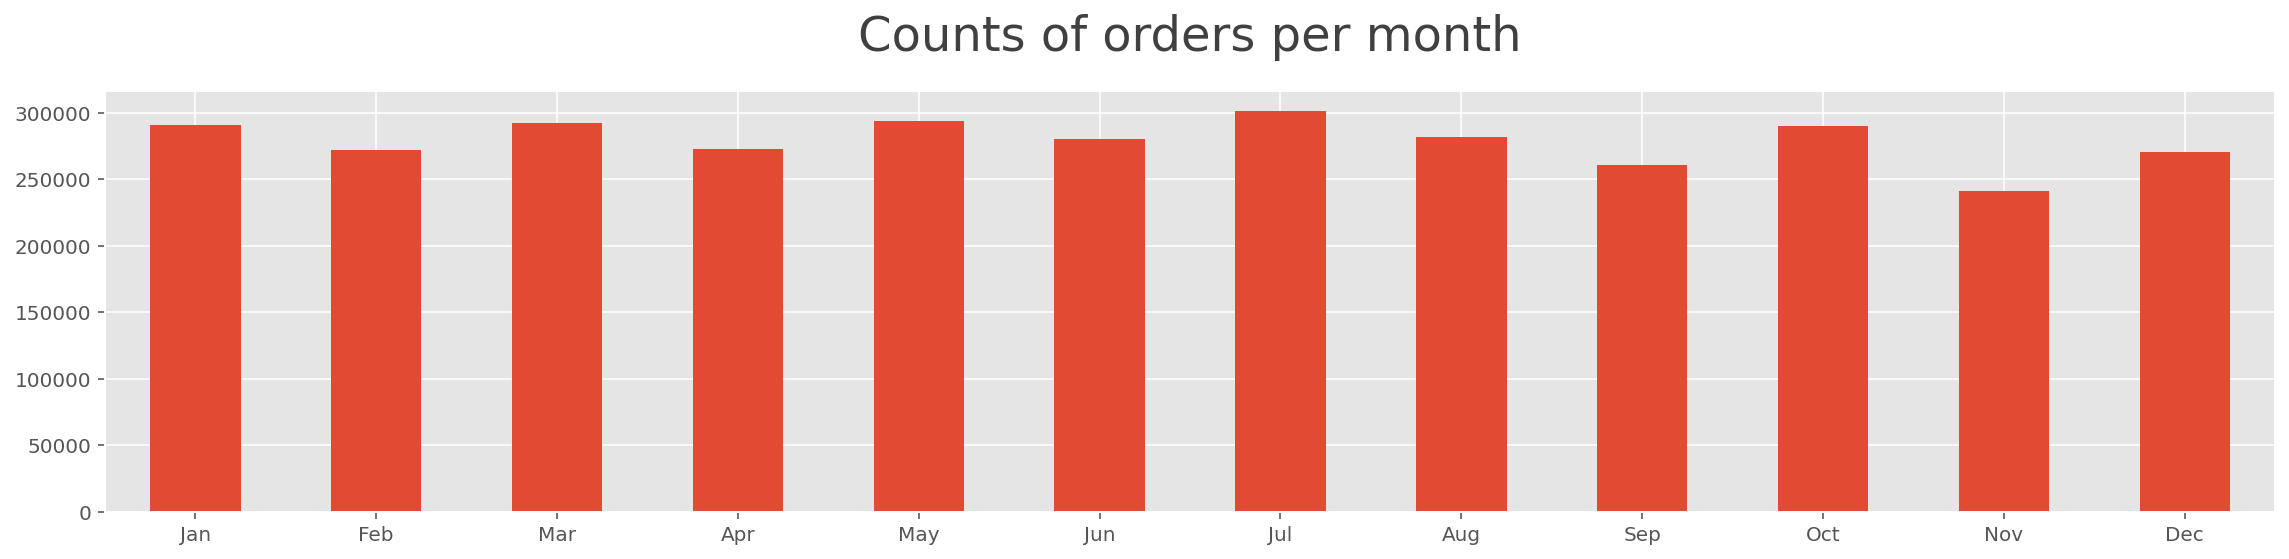

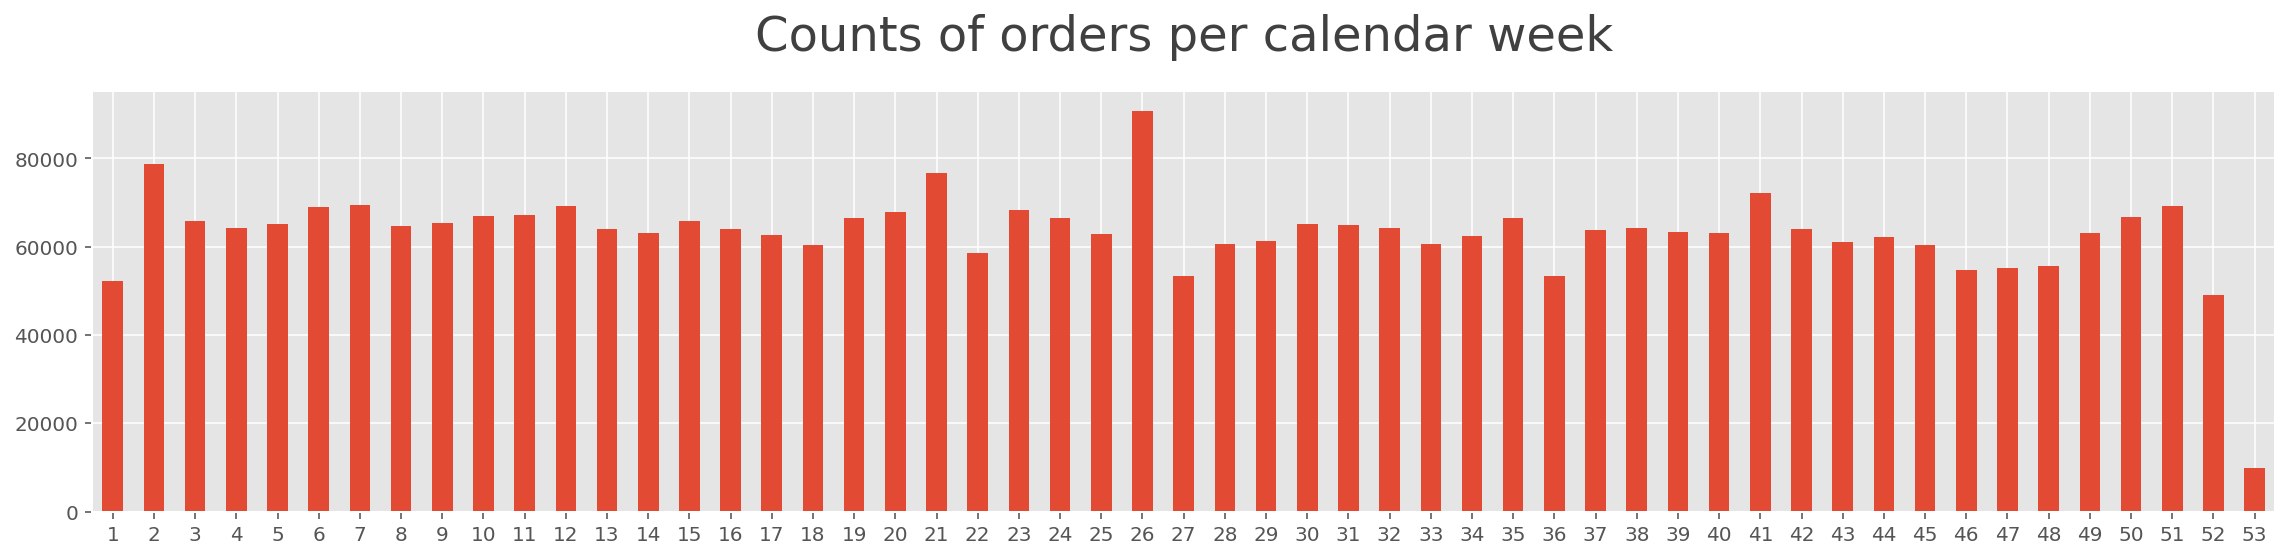

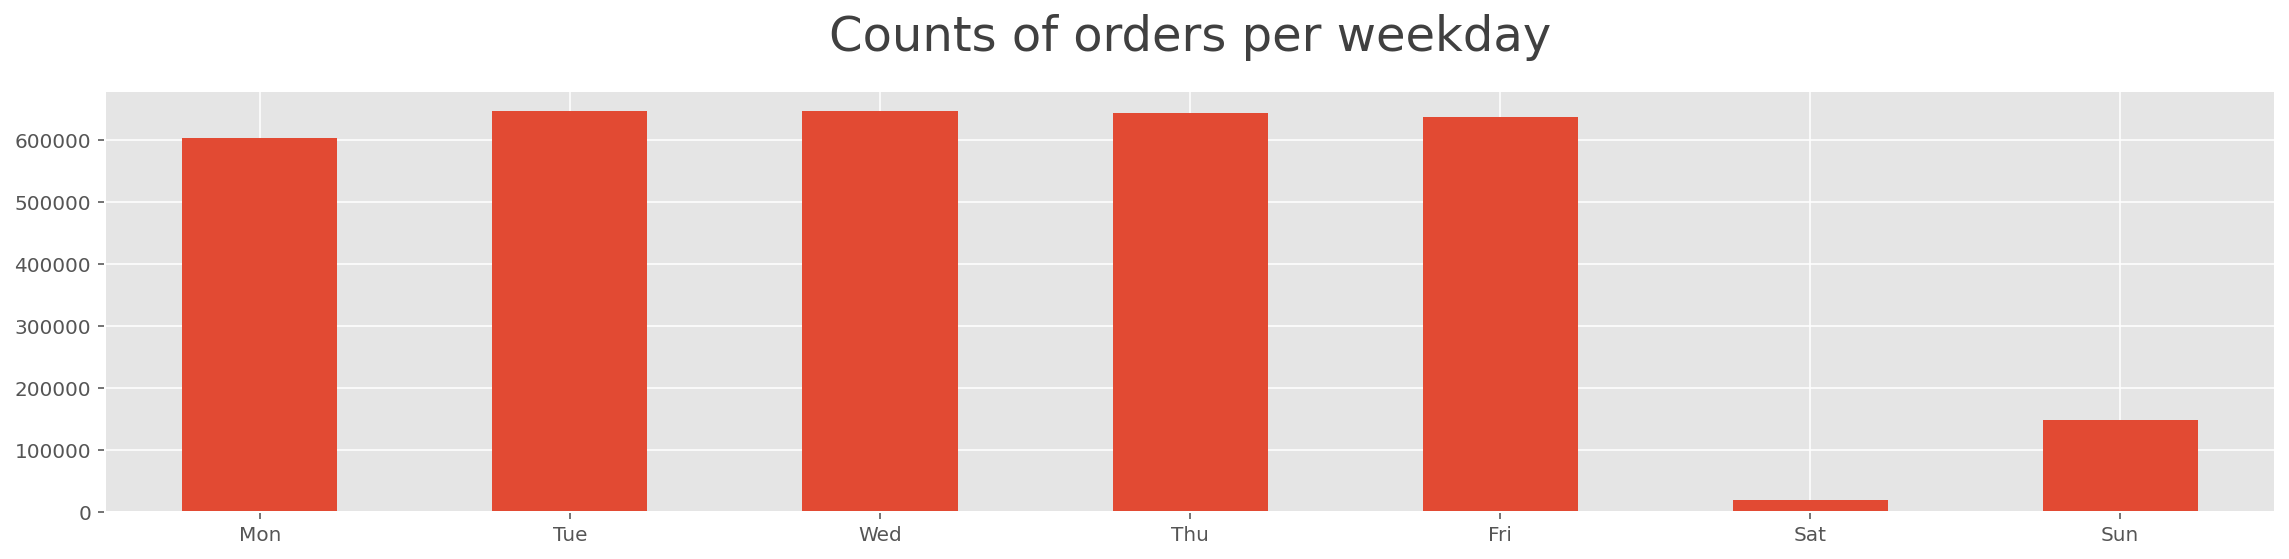

In [30]:
plt.figure(figsize=(16,4))
df.order_date.dt.month.value_counts().sort_index().plot.bar()
plt.title(f"Counts of orders per month", size=TITLE_SIZE, pad=TITLE_PADDING)
plt.xticks(ticks=range(0, 12), labels=list(calendar.month_abbr[1:]), rotation=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,4))
df.order_date.dt.isocalendar().week.value_counts().sort_index().plot.bar()
plt.title(f"Counts of orders per calendar week", size=TITLE_SIZE, pad=TITLE_PADDING)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16,4))
df.order_date.dt.weekday.value_counts().sort_index().plot.bar()
plt.title(f"Counts of orders per weekday", size=TITLE_SIZE, pad=TITLE_PADDING)
plt.xticks(ticks=range(0, 7), labels=list(calendar.day_abbr), rotation=0)
plt.tight_layout()
plt.show()

### Departments
- **Looking at the department codes I observe the substantial system change from 2017 to 2018 too.** 
- After 2017 all codes are three letters only and the number of unique codes / titles is reduced form 116 to 52.

In [31]:
before_2018 = sorted(df[df.fiscal_year < 2018].purchasing_department.unique())
after_2017 = sorted(df[df.fiscal_year > 2017].purchasing_department.astype(str).unique())
print(f"Before 2018: {len(before_2018)} unique department codes")
print(f"After  2017:  {len(after_2017)} unique department codes\n")

before_2018 = sorted(df[df.fiscal_year < 2018].dept_title.unique())
after_2017 = sorted(df[df.fiscal_year > 2017].dept_title.astype(str).unique())
print(f"Before 2018: {len(before_2018)} unique department titles")
print(f"After  2017:  {len(after_2017)} unique department titles\n")

print(sorted(df[df.fiscal_year < 2018].purchasing_department.unique()))
print()
print(sorted(df[df.fiscal_year > 2017].purchasing_department.astype(str).unique()))
print()

Before 2018: 116 unique department codes
After  2017:  52 unique department codes

Before 2018: 116 unique department titles
After  2017:  52 unique department titles

['AAM', 'ADMCR', 'ADP', 'AGE', 'AIR', 'ANC', 'ART', 'ASR', 'BOS', 'CAOAS', 'CAOAV', 'CAOBO', 'CAOCA', 'CAOEM', 'CAOGA', 'CAORM', 'CAT', 'CCL', 'CFC', 'CFM', 'CHF', 'CII01', 'CLP', 'CME', 'CON01', 'CON03', 'CON04', 'CON05', 'CON06', 'CON99', 'CPC', 'CRTSP', 'CSC', 'CSS', 'CWP', 'CWPA', 'DAT', 'DBI', 'DPT', 'DPT1', 'DPT2', 'DPWAT', 'DPWBR', 'DPWCN', 'DPWEN', 'DPWGA', 'DPWSE', 'DPWSM', 'DPWSR', 'DPWUF', 'DSS', 'ECD', 'ECDANC', 'ECDCME', 'ECDDPWAT', 'ECDDPWGA', 'ECDFIR', 'ECDHCH', 'ECDHRDCS', 'ECDPOL', 'ECDPRT', 'ECDPUC', 'ECDREC', 'ECDSHF', 'ECDTIS02', 'ENV', 'ETH', 'FAM', 'FIR', 'HCH', 'HGH', 'HHP', 'HLH', 'HMH', 'HOM', 'HRC', 'HRDCS', 'HRDHS', 'HRDWC', 'JUV', 'LIB', 'LLB', 'MTA', 'MYRAD', 'MYRBE', 'MYRCJ', 'MYRGA', 'MYRMO', 'OCALS', 'OCAPUR', 'OCC', 'PAB', 'PDR', 'POL', 'PRT', 'PTC', 'PUC', 'PUR', 'PUR02', 'PUR04', 'PURDP

Plotting the Top 20 ordering departments by count we also see that **department titles have changed after 2017**, e.g., `POLICE` changed to `POL Police`.

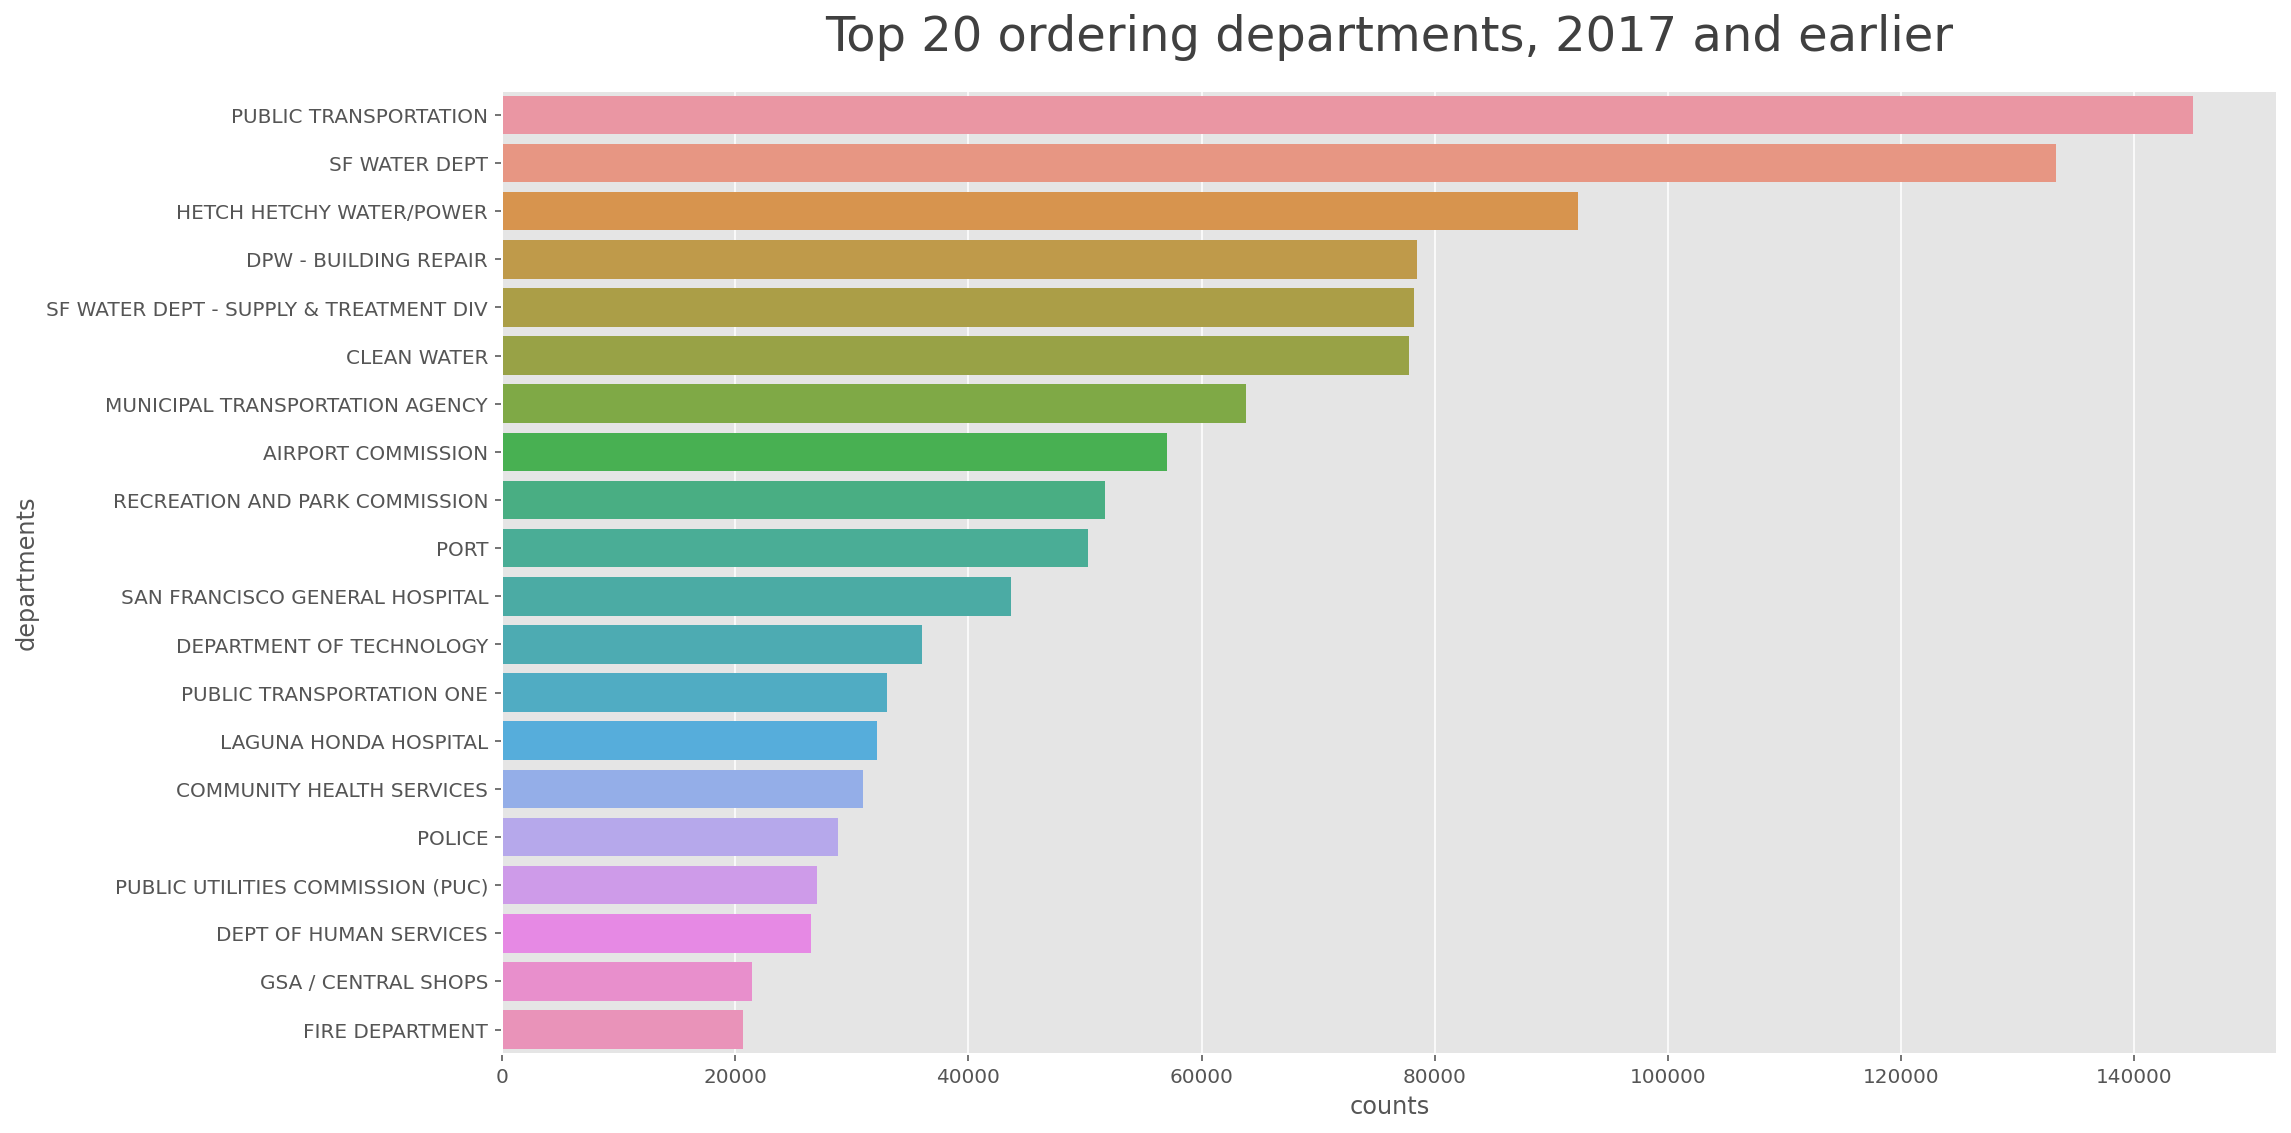

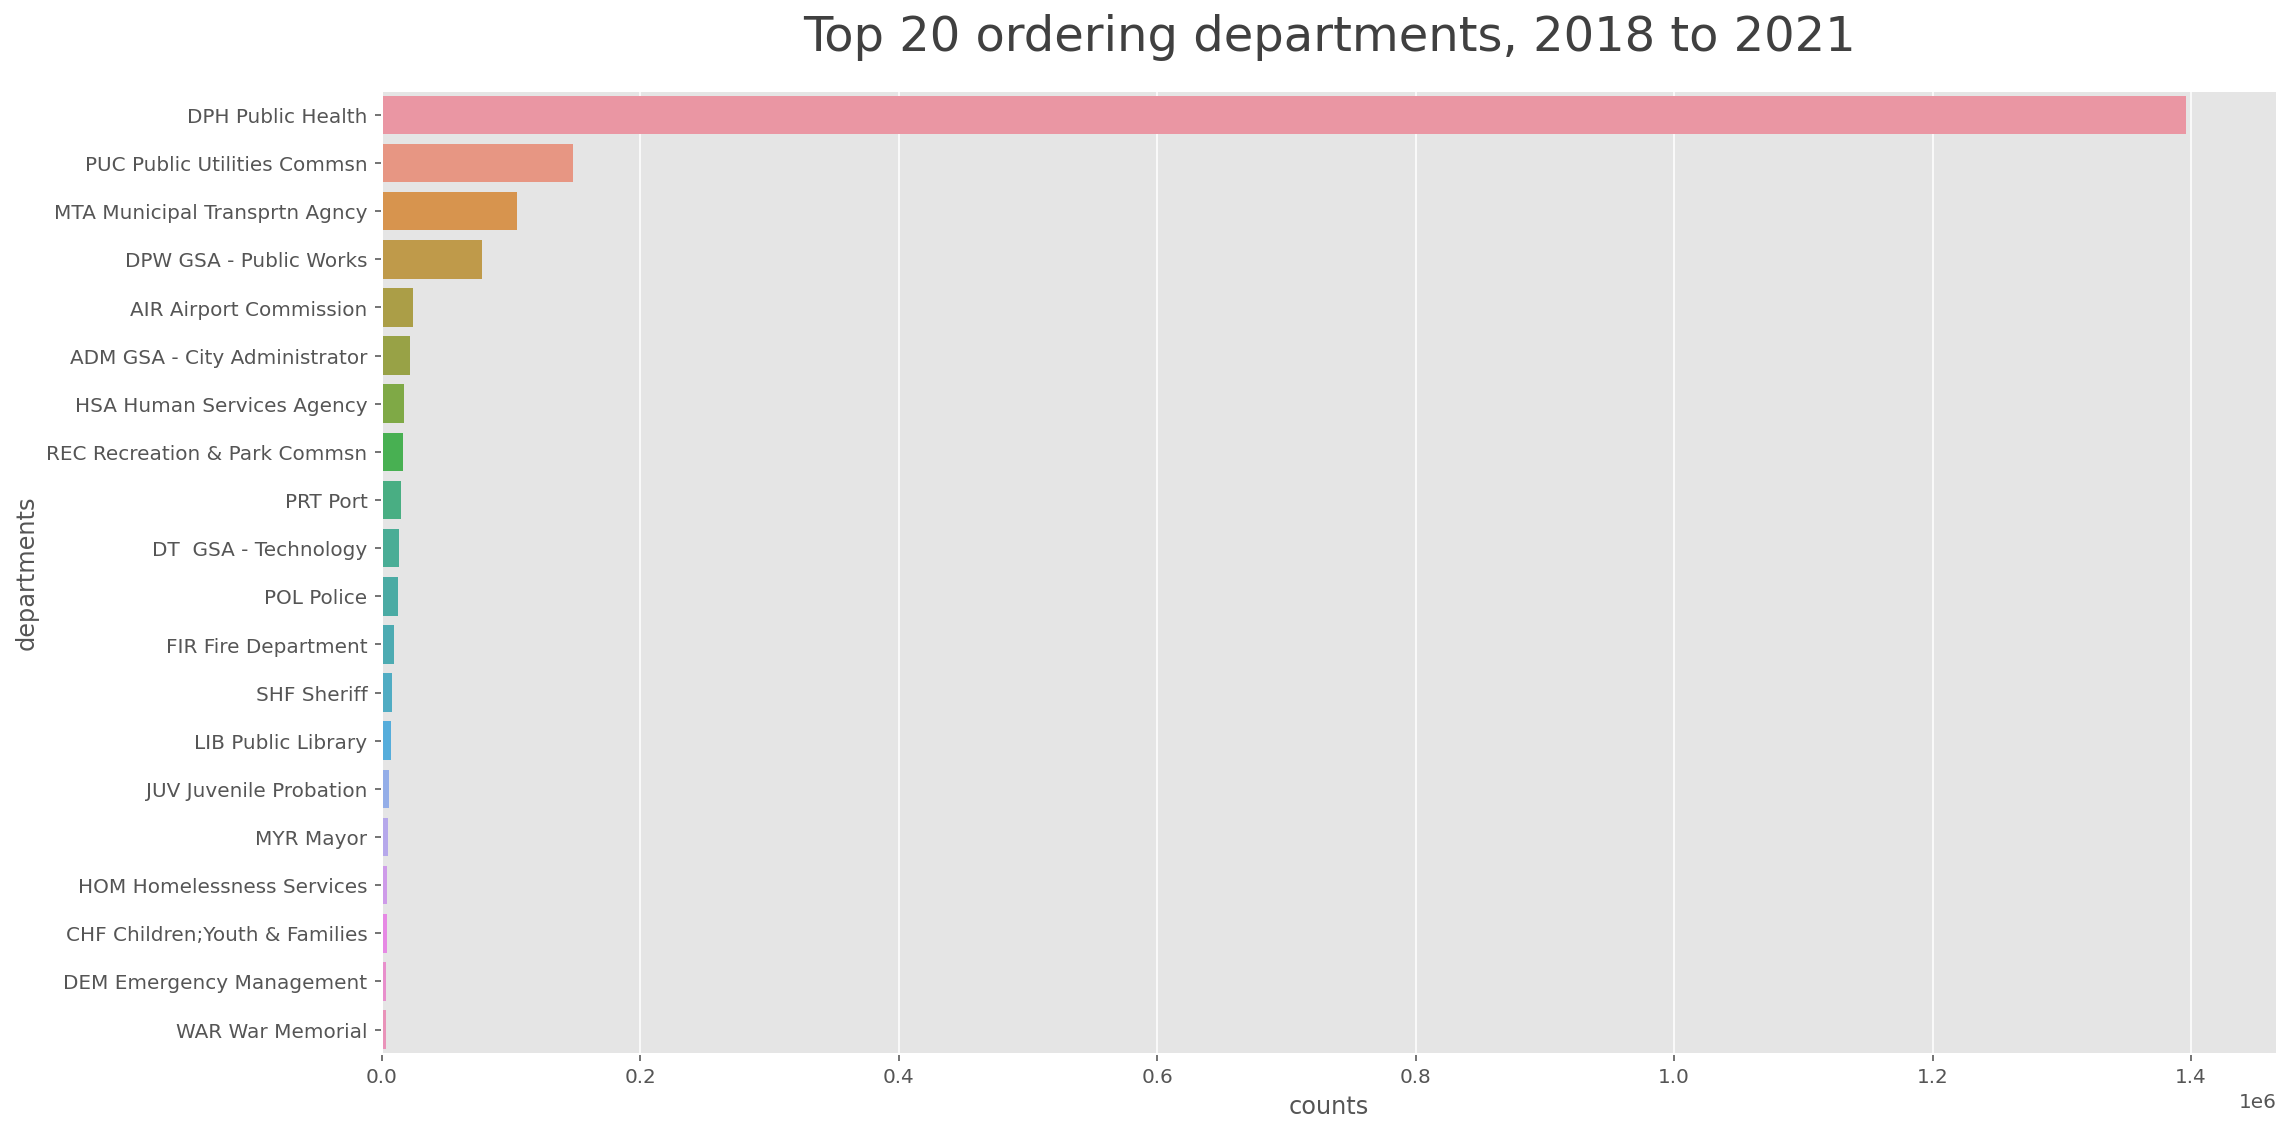

In [32]:
tmp = df[df.fiscal_year < 2018].dept_title.value_counts()[:20].sort_index()
tmp = pd.DataFrame(tmp).reset_index()
tmp.columns = ["departments", "counts"]
tmp.sort_values("counts", inplace=True, ascending=False)
plt.figure(figsize=(16,8))
sns.barplot(data=tmp, y="departments", x="counts")
plt.title(f"Top 20 ordering departments, 2017 and earlier", size=TITLE_SIZE, pad=TITLE_PADDING)
plt.tight_layout()
plt.show()

tmp = df[df.fiscal_year > 2017].dept_title.value_counts()[:20].sort_index()
tmp = pd.DataFrame(tmp).reset_index()
tmp.columns = ["departments", "counts"]
tmp.sort_values("counts", inplace=True, ascending=False)
plt.figure(figsize=(16,8))
sns.barplot(data=tmp, y="departments", x="counts")
plt.title(f"Top 20 ordering departments, 2018 to 2021", size=TITLE_SIZE, pad=TITLE_PADDING)
plt.tight_layout()
plt.show()

### Commodities
**The system change in 2018 refers to commodity codes and titles too.** None of the commodity codes or titles from 2017 and earlier is used after 2017. The city has introduced a somewhat larger system of categories.

In [33]:
comm_code_before = df[df.fiscal_year < 2018].commodity_code.unique()
comm_code_after = df[df.fiscal_year > 2017].commodity_code.unique()
print(f"{len(comm_code_before)} unique codes 2017 and earlier. \n{len(comm_code_after)} unique codes 2018 and later.")
print(f"{len([x for x in comm_code_before if x in comm_code_after])} common commodity code(s) after system change.\n")

comm_title_before = df[df.fiscal_year < 2018].commodity_title.unique()
comm_title_after = df[df.fiscal_year > 2017].commodity_title.unique()
print(f"{len(comm_title_before)} unique codes 2017 and earlier. \n{len(comm_title_after)} unique codes 2018 and later.")
print(f"{len([x for x in comm_title_before if x in comm_title_after])} common commodity title(s) after system change.\n")

4738 unique codes 2017 and earlier. 
5425 unique codes 2018 and later.
0 common commodity code(s) after system change.

4676 unique codes 2017 and earlier. 
5333 unique codes 2018 and later.
0 common commodity title(s) after system change.



### Suppliers
- **The system change has affected supplier titles as well.**

In [34]:
suppliers_before = df[df.fiscal_year < 2018].supplier_name.unique()
suppliers_after = df[df.fiscal_year > 2017].supplier_name.unique()
print(f"{len(suppliers_before)} unique suppliers 2017 and earlier. \n{len(suppliers_after)} supplier 2018 and later.")
print(f"{len([x for x in suppliers_before if x in suppliers_after])} common supplier names after system change.")

12259 unique suppliers 2017 and earlier. 
8380 supplier 2018 and later.
5092 common supplier names after system change.


### Quantity of orders
- The distribution of order quantities is extremely skewed. 
- The median is 4 units, the mean 172.
- The standard variation (sensitive to outliers like the mean) is more than 39k units.
- Quantities range from 0 to a whopping 59'816'000 units (possibly paper and/or toner for printers).
- Most orders are in the range of 0 to 50.

In [35]:
display(df.quantity.describe().astype(int))

count     3347834
mean          172
std         39005
min             0
25%             1
50%             4
75%            20
max      59816000
Name: quantity, dtype: int64

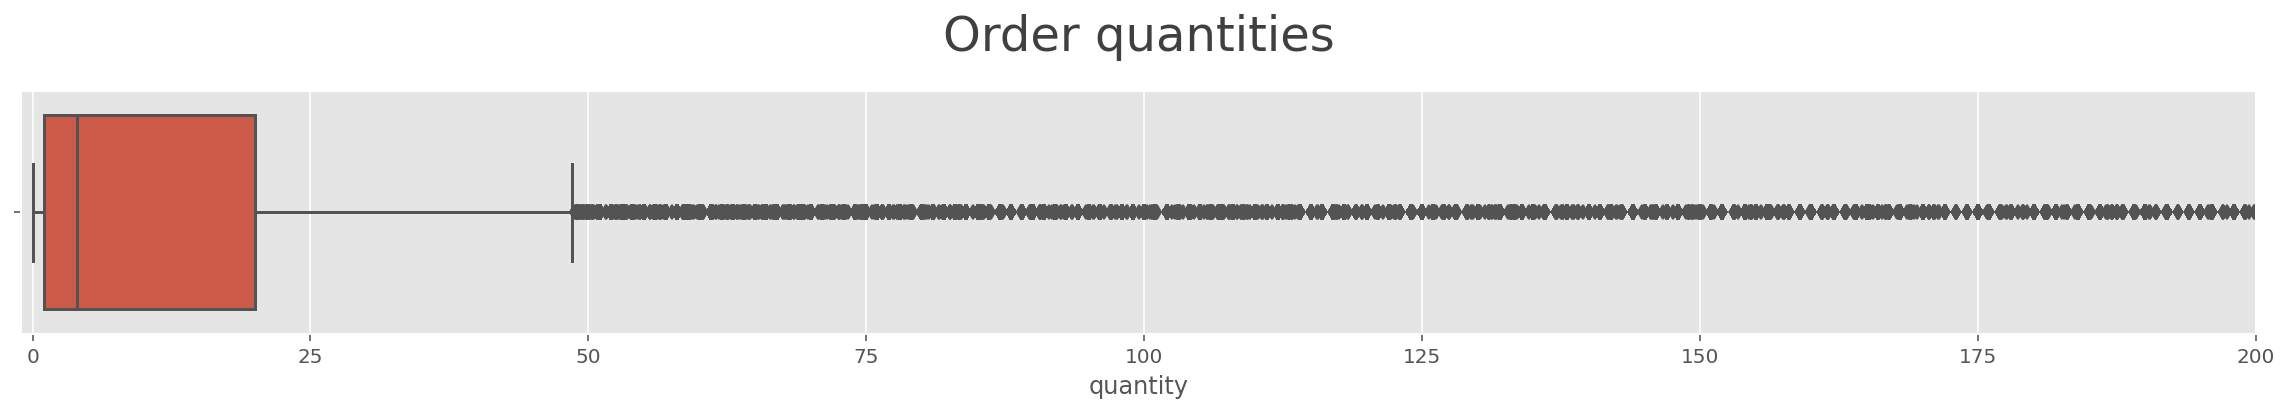

In [36]:
plt.figure(figsize=(16,3))
sns.boxplot(data=df, x="quantity")
plt.title(f"Order quantities", size=TITLE_SIZE, pad=TITLE_PADDING)
plt.xlim(-1, 200)
plt.tight_layout()
plt.show()

In [37]:
# Order with highest quantity in data set
display(df[df.quantity > 50_000_000])

fiscal_year order_date       order  order_line purchasing_department  \
1549504         2018 2018-03-23  0000106138         1.0                   MTA   

                            dept_title commodity_code commodity_title  \
1549504  MTA Municipal Transprtn Agncy    Unspecified             NaN   

                        supplier_name    quantity      price  
1549504  DIGITAL PRINTING SYSTEMS INC  59816000.0  158356.88

### Prices
- **The distribution of order prices is extremely skewed.**
- The median is 140 USD, the mean ~570k.
- The standard variation (sensitive to outliers like the mean) is almost ~398 million USD.
- Prices range from close to 0 to a whopping 58'177'718'847 (an order made to the pharmaceutical company [McKesson](https://www.mckesson.com/) which is the oldest and largest healthcare company in the US).
- Most orders are in the range of 0 to 2'200.

count         3347834
mean           569537
std         397753080
min                 0
25%                25
50%               140
75%               867
max      583177718847
Name: price, dtype: int64

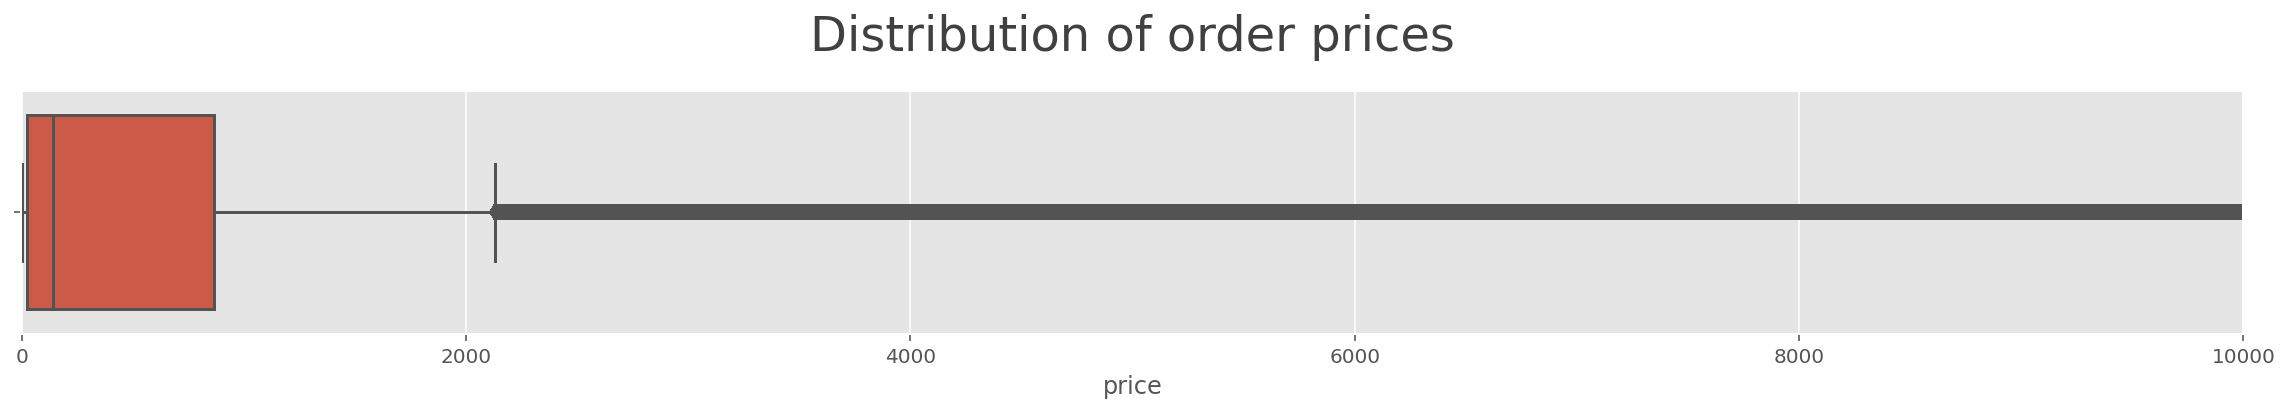

fiscal_year order_date       order  order_line purchasing_department  \
1562257         2018 2017-11-30  0000109360         1.0                   DPH   
1981546         2019 2019-06-24  0000212808         1.0                   DPH   
2439660         2020 2020-05-08  0000327943         1.0                   DPH   

                dept_title commodity_code            commodity_title  \
1562257  DPH Public Health          26900  DRUGS AND PHARMACEUTICALS   
1981546  DPH Public Health          26900  DRUGS AND PHARMACEUTICALS   
2439660  DPH Public Health          26900  DRUGS AND PHARMACEUTICALS   

                supplier_name  quantity         price  
1562257  MCKESSON CORPORATION       0.0  6.124300e+10  
1981546  MCKESSON CORPORATION       0.0  5.831777e+11  
2439660  MCKESSON CORPORATION       0.0  4.175012e+11

In [38]:
display(df.price.describe().astype(int))
print()

plt.figure(figsize=(16,3))
sns.boxplot(data=df, x="price")
plt.title(f"Distribution of order prices", size=TITLE_SIZE, pad=TITLE_PADDING)
plt.xlim(-1, 10_000)
plt.tight_layout()
plt.show()
print()

# Most costly orders in data set
display(df[df.price > 50_000_000_000])

### Prices per unit
- **The distribution of prices per unit is extremely skewed too.**
- The median is 12 USD, the mean 481.
- The standard variation is 21'960.
- Unit prices range from close to 0 to a 34'344'044 – an order for construction services **with the hard to interpret quantity of 0.0847**.
- Most unit prices are in the range of 0 to ~200.

count     2923229
mean          481
std         21960
min             0
25%             1
50%            12
75%            85
max      34344044
Name: price_per_unit, dtype: int64

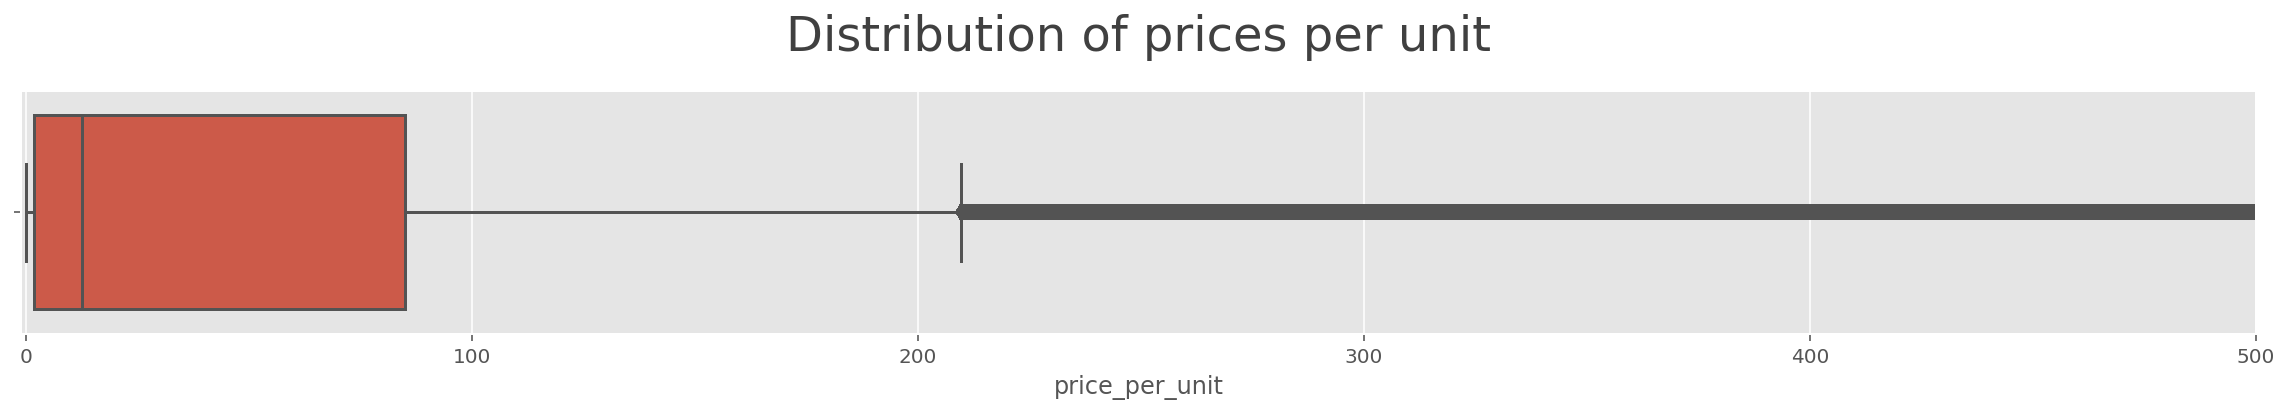

fiscal_year order_date       order  order_line purchasing_department  \
1455938         2018 2017-11-01  0000077524        31.0                   PUC   

                          dept_title commodity_code  \
1455938  PUC Public Utilities Commsn          91200   

                                           commodity_title  \
1455938  CONSTRUCTION SERVICES GENERAL (INCL. MAINTENAN...   

                                    supplier_name  quantity       price  \
1455938  DRAGADOS USA/FLATIRON WEST/SUKUT CNST JV    0.0847  2908940.56   

         price_per_unit  
1455938    3.434404e+07

In [39]:
tmp = df[df.quantity>0].copy()
tmp["price_per_unit"] = tmp.price / tmp.quantity

display(tmp.price_per_unit.describe().astype(int))
print()

plt.figure(figsize=(16,3))
sns.boxplot(data=tmp, x="price_per_unit")
plt.title(f"Distribution of prices per unit", size=TITLE_SIZE, pad=TITLE_PADDING)
plt.xlim(-1, 500)
plt.tight_layout()
plt.show()
print()

# Most costly orders in data set
display(tmp[tmp.price_per_unit > 30_000_000])

# Conclusion from EDA

**There are two crucial findings:**

1. **We have ~450k orders with 0 quantity in the data that account for 99.6% of the total purchase volume.**
2. **We actually have two data sets at hand that aren't compatible.** 
   - On the one hand there is data from 2007 to 2017 with a specific system of date collection and naming for commodity, departement and supplier. This first chunk of data only accounts for ~1% of the total sales volume in the data set. It has its specific purchase patterns too.
   - On the other hand we have data from 2018 to 2021 that is collected and named differently. Around 4 times the amount of order data is available for these recent years than for the previous ones (that account for ~99% of total purchase volume in the whole data set).


Other findings:
- Data before 2007 is sparse. 
- Data for fiscal year 2022 still is incomplete. 
- It makes sense to remove all orders with prices of 0 or negative values (likely refunds, rebates, settlements).
- We need to take care of values `Unspecified` in commodity titles as well as check the 306 duplicates.


Decision:
- **Because the data is not sufficiently homogenic I decide to concentrate on the recent data chunk from 2018 to 2021.** 
- **I don't have enough information to properly interpret the transactions with zero quantity.** According to the data description these are service contracts. Nonetheless, the total amount of almost 1.8 trillion USD doesn't seem plausible in context of the city's yearly budget of «just» ~16 billion USD. I therefore decide to **exclude these zero quantity transactions from the next step of analysis**.
- If the data chunk from 2007 to 2017 is of interest for the customer, this older chunk could be analyzed in a later project step.